In [3]:
"this notebook goes through the process of collecting data and etc "

'this notebook goes through the process of collecting data and etc '

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import seaborn as sns
#from dataClasses import Trial,Neuron
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report
#import intertools 
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from imblearn.pipeline import  Pipeline

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import boto3
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy import stats
import numpy as np
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.utils import resample


In [3]:
s3 = boto3.client('s3') 
bucket_name = 'sussexwork'

In [4]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Defining the RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        
        # RNN forward pass
        out, _ = self.rnn(x)
        
        # Use only the last time step's output
        out = out[:, -1]  # Take the output from the last sequence step
        
        # Fully connected layer
        out = self.fc(out)
        
        return out


In [5]:
def get_data_ready(brain_area, type_of_analysis):
    all_trials=np.load("processed_data/"+ brain_area + "_all_trials.npy",allow_pickle=True)
    trial_list=np.empty((all_trials.shape[0],3))
    trial_dff=np.empty((all_trials.shape[0],41)) 
    trial_licks=np.empty((all_trials.shape[0],41))
    # Here we get the data based on the conditions that we want (i.e: if it is is lick, or go) 
    
    for trial in range(all_trials.shape[0]):
        
        trial_list[trial,0]=all_trials[trial].neuron_num
    
        
        if type_of_analysis=="GO":
            # for labelling go nogo
            if (all_trials[trial].trial_type)=="go":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_type)=="nogo":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        elif type_of_analysis=="LICK":    
            #for labelling lick nolick
            if (all_trials[trial].trial_outcome)=="FA":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Hit":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Miss":
                trial_list[trial,1]=0
            elif (all_trials[trial].trial_outcome)=="CR":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        else:
            print("Type of analysis can only be 'GO' or 'LICK'")
        
        trial_list[trial,2]=all_trials[trial].mouse_id
        if (all_trials[trial].trial_outcome)=="FA" or (all_trials[trial].trial_outcome)=="Hit":
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #rebase  dff 
            trial_licks[trial,:]=all_trials[trial].licks
            lick_start=np.argmax(trial_licks[trial,:]==1,axis=0)
            trial_dff_rel_licks=np.zeros(trial_licks.shape[1])
            new_start=lick_start-4
            if new_start>=0:                    
                # move the array of licks left so that timeseries starst at lick time
                trial_dff_rel_licks[0:trial_licks.shape[1]-new_start]=all_trials[trial].dff[new_start: ]
                ## need to mske the last few timesteps on the new series = final timestep on original series
                trial_dff_rel_licks[trial_licks.shape[1]-new_start :]=all_trials[trial].dff[-1]
            else: 
                # move the array of licks right so that timeseries starst at lick time
                trial_dff_rel_licks[0-new_start :]=all_trials[trial].dff[0:all_trials[trial].dff.shape[0]+new_start]
                ## need to mske the first few timesteps on the new series = first timestep on original series
                trial_dff_rel_licks[0:-new_start]=all_trials[trial].dff[ 0 ]
                #trial_dff[trial,41:82]=trial_dff_rel_licks
        else:
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #trial_dff[trial,41:82]=all_trials[trial].dff
    return trial_list, trial_dff


In [6]:
'''
Population level analysis 
'''

'\nPopulation level analysis \n'

In [7]:
#First we rearrange the data to have all the neurons for one session in one dataframe (num_trials, num_time_steps, num_neurons)
def get_pop_data_ready(brain_area, type_of_analysis):
    all_trials=np.load("processed_data/"+brain_area + "_all_trials.npy",allow_pickle=True)
    trial_list=np.empty((all_trials.shape[0],4))
    trial_dff=np.empty((all_trials.shape[0],41)) 
    trial_licks=np.empty((all_trials.shape[0],41))
    
    for trial in range(all_trials.shape[0]):
        
        if type_of_analysis=="GO":
            # for labelling go nogo
            if (all_trials[trial].trial_type)=="go":
                all_trials[trial].trial_id=1
            elif (all_trials[trial].trial_type)=="nogo":
                all_trials[trial].trial_id=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        elif type_of_analysis=="LICK":
            #for labelling lick nolick
            if (all_trials[trial].trial_outcome)=="FA":
                all_trials[trial].trial_id=1
            elif (all_trials[trial].trial_outcome)=="Hit":
                all_trials[trial].trial_id=1
            elif (all_trials[trial].trial_outcome)=="Miss":
                all_trials[trial].trial_id=0
            elif (all_trials[trial].trial_outcome)=="CR":
                all_trials[trial].trial_id=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num)
        else:
            print("Type of analysis can only be 'GO' or 'LICK'")
    
        if (all_trials[trial].trial_outcome)=="FA" or (all_trials[trial].trial_outcome)=="Hit":
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #rebase  dff 
            trial_licks[trial,:]=all_trials[trial].licks
            lick_start=np.argmax(trial_licks[trial,:]==1,axis=0)
            trial_dff_rel_licks=np.zeros(trial_licks.shape[1])
            new_start=lick_start-4
            if new_start>=0:                    
                # move the array of licks left so that timeseries starst at lick time
                trial_dff_rel_licks[0:trial_licks.shape[1]-new_start]=all_trials[trial].dff[new_start: ]
                ## need to mske the last few timesteps on the new series = final timestep on original series
                trial_dff_rel_licks[trial_licks.shape[1]-new_start :]=all_trials[trial].dff[-1]
            else: 
                # move the array of licks right so that timeseries starst at lick time
                trial_dff_rel_licks[0-new_start :]=all_trials[trial].dff[0:all_trials[trial].dff.shape[0]+new_start]
                ## need to mske the first few timesteps on the new series = first timestep on original series
                trial_dff_rel_licks[0:-new_start]=all_trials[trial].dff[ 0 ]
                #trial_dff[trial,41:82]=trial_dff_rel_licks
        else:
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #trial_dff[trial,41:82]=all_trials[trial].dff
    return all_trials, trial_dff

In [8]:
def process_trials_for_pca(trial_list, trial_dff, n_components=8):
    """
    Processes trial data and performs PCA for each session.
    
    Args:
        trial_list (list): List of trial objects with attributes (e.g., trial_id, mouse_id, date, num_trial).
        trial_dff (list): List of neuronal data arrays corresponding to trials.
        n_components (int): Number of PCA components to compute.
        
    Returns:
        pd.DataFrame: DataFrame containing the PCA results for each session.
        dict: Dictionary mapping session identifiers to a list of trial_ids.
    """
    # Specify the variables of interest
    variables_of_interest = ['trial_id', 'mouse_id', 'date', 'num_trial']
    
    # Create DataFrame with only the variables of interest
    trials_data = [
        {key: getattr(trial, key) for key in variables_of_interest} 
        for trial in trial_list
    ]
    
    # Create DataFrame from the extracted data
    trial_df = pd.DataFrame(trials_data)
    
    # Group by unique trial identifiers: mouse_id, date, trial_num
    grouped_trials = trial_df.groupby(['mouse_id', 'date', 'num_trial'])
    
    session_trial_ids = []
    all_pca = []
    
    # Iterate over groups to process indices for PCA
    for session_key, group_indices in grouped_trials.groups.items():
        # Retrieve the corresponding trial_dff data
        session_dff = [trial_dff[idx] for idx in group_indices]
        
        # Combine neuronal data (timepoints x neurons)
        combined_dff = np.stack(session_dff)
        
        # Check if PCA is feasible
        n_samples, n_features = combined_dff.shape
        if n_samples < n_components or n_features < n_components:
           # print(f"Skipping session {session_key} due to insufficient dimensions "
            #      f"(n_samples={n_samples}, n_features={n_features}, n_components={n_components}).")
            continue
        
        # Perform PCA
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(combined_dff.T)  # Transpose for PCA (neurons x time)
        session_id=session_key [0:2]
        # Append PCA results
        all_pca.append({
            "session": session_id,
            "pca_result": pca_result,
            "explained_variance_ratio": pca.explained_variance_ratio_,
            "dff": combined_dff
        })
        session_trial_ids.append(trial_df.trial_id[group_indices].mean())
    
    # Create a DataFrame for PCA results
    pca_results_df = pd.DataFrame(all_pca)

    return pca_results_df, session_trial_ids


In [9]:
# Visualize real vs synthetic data
def plot_real_vs_synthetic(X_real, y_real, X_synthetic, y_synthetic):
    # Reduce dimensions using PCA for visualization
    pca = PCA(n_components=2)
    X_real_pca = pca.fit_transform(X_real)
    X_synthetic_pca = pca.transform(X_synthetic)
    
    # Combine and label datasets
    real_df = pd.DataFrame(X_real_pca, columns=["PC1", "PC2"])
    real_df["Type"] = "Real"
    real_df["Label"] = y_real
    
    synthetic_df = pd.DataFrame(X_synthetic_pca, columns=["PC1", "PC2"])
    synthetic_df["Type"] = "Synthetic"
    synthetic_df["Label"] = y_synthetic
    
    combined_df = pd.concat([real_df, synthetic_df])
    
    # Plot the data
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=combined_df,
        x="PC1", y="PC2",
        hue="Label",
        style="Type",
        palette="viridis",
        alpha=0.7,
    )
    plt.title("Real vs Synthetic Data Visualization")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Type / Label")
    plt.tight_layout()
    plt.show()


Brain Area: S1, Analysis Type: LICK
Original class distribution: Counter({1.0: 148, 0.0: 36})
Reduced majority class samples by 56. New class distribution: Counter({1.0: 92, 0.0: 36})
SMOTE applied:  36-> Counter({1.0: 92, 0.0: 92})
Resampled X shape: (184, 15, 41), Resampled y shape: (184,)
(184, 15, 41) (184,)
Session: ('0301', '20180323'), Test Accuracy: 46.88%
Confusion Matrix:
 [[ 5  5]
 [20 17]]
Class-specific Accuracy: [0.5        0.45945946]
Original class distribution: Counter({0.0: 65, 1.0: 32})
Reduced majority class samples by 16. New class distribution: Counter({0.0: 49, 1.0: 32})
SMOTE applied:  32-> Counter({1.0: 49, 0.0: 49})
Resampled X shape: (98, 12, 41), Resampled y shape: (98,)
(97, 12, 41) (98,)


AssertionError: Size mismatch between tensors

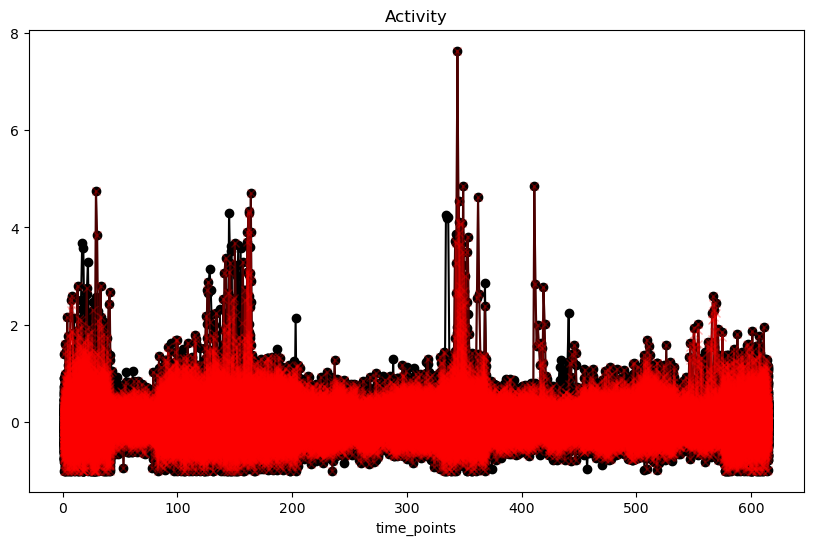

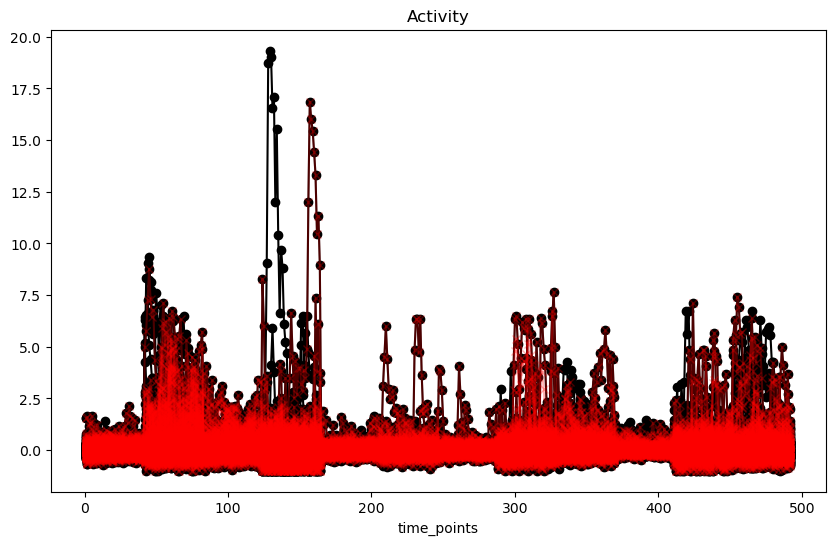

In [27]:
#no pca

# Population analysis
num_permutations = 1000
results_population = []
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["LICK", "GO"]
combinations = [('S1', 'LICK'), ('S1', 'GO'), ('S1naive', 'GO'), ('S1naive', 'LICK'), ('PPC', 'GO'), ('PPC', 'LICK')]

for comb in combinations:
    brain_area, analysis_type = comb
    print(f"Brain Area: {brain_area}, Analysis Type: {analysis_type}")

    # Load data
    trial_list, trial_dff = get_pop_data_ready(brain_area, analysis_type)

    # Perform PCA on trial data
    pca_result_df, session_trial_ids = process_trials_for_pca(trial_list, trial_dff, n_components=3)
    sessions = np.unique(pca_result_df['session'])

    for session in sessions:
        mask = pca_result_df['session'] == session
        all_session_X = pca_result_df[mask]
        all_X = np.array([np.array(trial) for trial in all_session_X['dff']])#'pca_result'
        all_y = np.array([session_trial_ids[i] for i in pca_result_df.index[mask]])

        X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)
        original_shape = X_train.shape  # (samples, time_steps, features)
        sequence_length = X_train.shape[1]  # Number of time steps

        # Flatten for oversampling (SMOTE)
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        #chekc class balance 
        class_counts = Counter(y_train)

        if len(class_counts) < 2: #make sure there are examples of each class 
            print(f"Skipping session {session} due to only one class present: {class_counts}")
            continue  # Skip this session and move to the next
        
       
        # Print initial class distribution
        print(f"Original class distribution: {Counter(y_train)}")
        
        # Identify majority and minority classes
        class_counts = Counter(y_train)
        majority_class = max(class_counts, key=class_counts.get)
        minority_class = min(class_counts, key=class_counts.get)
        
        # Calculate the imbalance difference
        majority_count = class_counts[majority_class]
        minority_count = class_counts[minority_class]
        difference = majority_count - minority_count
        # Minimum number of samples required for SMOTE
        required_samples = 6  # k_neighbors + 1 (default k_neighbors=5)
    
        if minority_count < required_samples:
            print(f"Skipping session {session} due to severe class imbalance: {class_counts}")
            continue  # Skip this session and move to the next
    
        if difference > 10:  # Proceed only if there is an imbalance
            # Reduce the difference by half
            num_to_remove = difference // 2
        
            # Create a mask for the majority class
            majority_indices = [i for i, label in enumerate(y_train) if label == majority_class]
        
            # Randomly select majority samples to remove
            majority_indices_to_remove = resample(
                majority_indices, 
                replace=False, 
                n_samples=np.round(num_to_remove), 
                random_state=42
            )
        
            # Filter out the selected majority samples
            X_train_balanced = [x for i, x in enumerate(X_train_flat) if i not in majority_indices_to_remove]
            y_train_balanced = [y for i, y in enumerate(y_train) if i not in majority_indices_to_remove]
        
            print(f"Reduced majority class samples by {num_to_remove}. New class distribution: {Counter(y_train_balanced)}")
        else:
            X_train_balanced= X_train_flat
            y_train_balanced = y_train

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(np.array(X_train_balanced), np.array(y_train_balanced))
        print(f"SMOTE applied:  {minority_count}-> {Counter(y_resampled)}")
        num_samples = X_resampled.shape[0]  # Ensure sample count remains correct
        X_train_reshaped = X_resampled.reshape(num_samples, sequence_length, -1)
        print(f"Resampled X shape: {X_train_reshaped.shape}, Resampled y shape: {y_resampled.shape}")

        # Visualize real vs synthetic data
        plt.figure(figsize=(10, 6))
        for i, row in enumerate(X_train_flat):
            plt.plot(range(1, len(row) + 1), row, marker='o',color='k')#, label=f'Group {i + 1}')#, color=colours[y_train[i,1].astype(np.int64)])
        for i, row in enumerate(X_resampled):
            plt.plot(range(1, len(row) + 1), row, marker='x',color='r', alpha=0.3)#, label=f'Group {i + 1}', color=colours[y_resampled[i,1].astype(np.int64)])

        plt.title('Activity')
        plt.xlabel('time_points')

        #reshape 
        X_train_reshaped = X_train.reshape(X_train.shape[0], sequence_length, -1)  # Restore time dimension
        print(X_train_reshaped.shape, np.array(y_resampled).shape)
        
        # Convert to PyTorch tensors
        Xtrain = torch.from_numpy(np.array(X_train_reshaped)).float()
        ytrain = torch.from_numpy(np.array(y_resampled)).long()  # Convert to NumPy array
        Xtest = torch.from_numpy(X_test.reshape(X_test.shape[0],sequence_length,-1)).float()
        ytest = torch.from_numpy(np.array(y_test)).long()

        # Prepare DataLoader
        batch_size = 16
        n_iters = 1000
        num_epochs = int(n_iters // (len(X_train_flat) // batch_size))

        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

        # Create the RNN model
        input_dim = X_train.shape[2]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1

        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

        # Loss function and optimizer
        error = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

        # Training loop
        train_accuracy_list = []
        test_accuracy_list = []

        for epoch in range(num_epochs):
            model.train()
            total_train, correct_train = 0, 0

            for X_batch, y_batch in train_loader:
               # print("X_batch shape:", X_batch.shape)
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()
                loss = error(outputs, y_batch.float())
                loss.backward()
                optimizer.step()

                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).long()
                correct_train += (predicted.squeeze() == y_batch).sum().item()
                total_train += y_batch.size(0)

            train_accuracy = 100 * correct_train / total_train
            train_accuracy_list.append(train_accuracy)
            scheduler.step()

            # Test evaluation
            model.eval()
            total_test, correct_test = 0, 0
            with torch.no_grad():
                for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch).squeeze()
                    probabilities = torch.sigmoid(outputs)
                    predicted = (probabilities > 0.5).long()
                    correct_test += (predicted == y_test_batch).sum().item()
                    total_test += y_test_batch.size(0)

            test_accuracy = 100 * correct_test / total_test
            test_accuracy_list.append(test_accuracy)

        print(f"Session: {session}, Test Accuracy: {test_accuracy:.2f}%")

        session_results = {
            "Session": session,
            "Brain Area": brain_area,
            "Analysis Type": analysis_type,
            "Test Accuracy": np.mean(test_accuracy),
           # "Train Accuracy History": train_accuracy_list,
           # "Test Accuracy History": test_accuracy_list,
        }
        results_population.append(session_results)
        
      # Check class-specific accuracy on the test set
            
        # Predict on the test set and calculate confusion matrix
        model.eval()
        with torch.no_grad():
            outputs = model(Xtest).squeeze()
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).long()
                
        conf_matrix = confusion_matrix(ytest, predictions)
        print("Confusion Matrix:\n", conf_matrix)
            
            # Calculate class-specific accuracy
        class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        print("Class-specific Accuracy:", class_accuracy)

        results_df = pd.DataFrame(results_population)
        results_df.to_csv("results_Population_undersample.csv", index=False)



        

In [35]:
num_permutations = 1000
results_population = []
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["LICK", "GO"]
combinations = [('S1', 'LICK'), ('S1', 'GO'), ('S1naive', 'GO'), ('S1naive', 'LICK'), ('PPC', 'GO'), ('PPC', 'LICK')]

for brain_area, analysis_type in combinations:
    print(f"Brain Area: {brain_area}, Analysis Type: {analysis_type}")

    # Load data
    trial_list, trial_dff = get_pop_data_ready(brain_area, analysis_type)
    pca_result_df, session_trial_ids = process_trials_for_pca(trial_list, trial_dff, n_components=3)
    sessions = np.unique(pca_result_df['session'])

    for session in sessions:
        mask = pca_result_df['session'] == session
        all_session_X = pca_result_df[mask]
        all_X = np.array([np.array(trial) for trial in all_session_X['dff']])
        all_y = np.array([session_trial_ids[i] for i in pca_result_df.index[mask]])

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)

        # Ensure sequence length
        sequence_length = X_train.shape[1]
        
        # Flatten for SMOTE
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
          # Check class balance before SMOTE
        unique, counts = np.unique(y_train, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        
        # Check class balance
        class_counts = Counter(y_train)
        if len(class_counts) < 2:
            print(f"Skipping session {session} due to only one class present: {class_counts}")
            continue

        print(f"Original class distribution: {class_counts}")

        # Balance classes
        majority_class = max(class_counts, key=class_counts.get)
        minority_class = min(class_counts, key=class_counts.get)

        # Undersample if needed
        majority_count, minority_count = class_counts[majority_class], class_counts[minority_class]
        difference = majority_count - minority_count
        required_samples = 6  # Minimum needed for SMOTE

        if minority_count < required_samples:
            print(f"Skipping session {session} due to severe class imbalance: {class_counts}")
            continue
        
        if difference > 10:
            num_to_remove = difference // 2
            majority_indices = [i for i, label in enumerate(y_train) if label == majority_class]
            majority_indices_to_remove = resample(majority_indices, replace=False, n_samples=num_to_remove, random_state=42)
            
            X_train_balanced = [x for i, x in enumerate(X_train_flat) if i not in majority_indices_to_remove]
            y_train_balanced = [y for i, y in enumerate(y_train) if i not in majority_indices_to_remove]

            print(f"Reduced majority class samples. New class distribution: {Counter(y_train_balanced)}")
        else:
            X_train_balanced = X_train_flat
            y_train_balanced = y_train

        # Convert to numpy for SMOTE
        X_train_balanced = np.array(X_train_balanced)
        y_train_balanced = np.array(y_train_balanced)

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train_balanced, y_train_balanced)

        print(f"SMOTE applied: {Counter(y_resampled)}")

        # Reshape back to time-series format
        num_samples = X_resampled.shape[0]
        X_train_reshaped = X_resampled.reshape(num_samples, sequence_length, -1)

        # Ensure shape alignment
        assert X_train_reshaped.shape[0] == len(y_resampled), "Mismatch in resampled X and y!"

        # Convert to PyTorch tensors
        Xtrain = torch.from_numpy(X_train_reshaped).float()
        ytrain = torch.from_numpy(y_resampled).long()
        Xtest = torch.from_numpy(X_test.reshape(X_test.shape[0], sequence_length, -1)).float()
        ytest = torch.from_numpy(np.array(y_test)).long()

        # Ensure consistency before creating TensorDataset
        assert Xtrain.shape[0] == ytrain.shape[0], "Mismatch in Xtrain and ytrain sizes!"

        # Prepare DataLoader
        batch_size = 16
        n_iters = 1000
        num_epochs = int(n_iters // (len(Xtrain) // batch_size))

        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

        # RNN Model
        input_dim = X_train.shape[2]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1

        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

        # Loss and optimizer
        error = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()
                loss = error(outputs, y_batch.float())
                loss.backward()
                optimizer.step()

          # Test evaluation
        model.eval()
        total_test, correct_test = 0, 0
        with torch.no_grad():
            for X_test_batch, y_test_batch in test_loader:
                outputs = model(X_test_batch).squeeze()
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).long()
                correct_test += (predicted == y_test_batch).sum().item()
                total_test += y_test_batch.size(0)

        test_accuracy = 100 * correct_test / total_test
        test_accuracy_list.append(test_accuracy)

        print(f"Session: {session}, Test Accuracy: {test_accuracy:.2f}%")

        # Random classifier: Match class distribution in the test set
        class_distribution = np.mean(y_test)  # proportion of class 1

        random_accuracies = []
        for _ in range(num_permutations):
            y_random = np.random.choice([0, 1], size=len(y_test), p=[1 - class_distribution, class_distribution])
            random_accuracy = accuracy_score(y_test, y_random)
            random_accuracies.append(random_accuracy)

        # Calculate p-value using a t-test (testing original model vs. random classifiers)
        random_accuracies = np.array(random_accuracies)
        p_value = np.mean(random_accuracies >= test_accuracy/100)


        
        session_results = {
            "Session": session,
            "Brain Area": brain_area,
            "Analysis Type": analysis_type,
            "Test Accuracy": np.mean(test_accuracy),
            "p value": p_value
           # "Train Accuracy History": train_accuracy_list,
           # "Test Accuracy History": test_accuracy_list,
        }
        results_population.append(session_results)
        
      # Check class-specific accuracy on the test set
            
        # Predict on the test set and calculate confusion matrix
        model.eval()
        with torch.no_grad():
            outputs = model(Xtest).squeeze()
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).long()
                
        conf_matrix = confusion_matrix(ytest, predictions)
        print("Confusion Matrix:\n", conf_matrix)
            
            # Calculate class-specific accuracy
        class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        print("Class-specific Accuracy:", class_accuracy)

        results_df = pd.DataFrame(results_population)
        results_df.to_csv("results_Population_undersample_pvalue.csv", index=False)



Brain Area: S1, Analysis Type: LICK
Original class distribution: Counter({1.0: 148, 0.0: 36})
Reduced majority class samples. New class distribution: Counter({1.0: 92, 0.0: 36})
SMOTE applied: Counter({1.0: 92, 0.0: 92})
Session: ('0301', '20180323'), Test Accuracy: 65.62%
Confusion Matrix:
 [[ 4  6]
 [10 27]]
Class-specific Accuracy: [0.4        0.72972973]
Original class distribution: Counter({0.0: 65, 1.0: 32})
Reduced majority class samples. New class distribution: Counter({0.0: 49, 1.0: 32})
SMOTE applied: Counter({1.0: 49, 0.0: 49})
Session: ('0406', '20180409'), Test Accuracy: 75.00%
Confusion Matrix:
 [[15  5]
 [ 2  3]]
Class-specific Accuracy: [0.75 0.6 ]
Original class distribution: Counter({1.0: 258, 0.0: 64})
Reduced majority class samples. New class distribution: Counter({1.0: 161, 0.0: 64})
SMOTE applied: Counter({0.0: 161, 1.0: 161})
Session: ('0406', '20180503'), Test Accuracy: 65.00%
Confusion Matrix:
 [[ 3 12]
 [16 50]]
Class-specific Accuracy: [0.2        0.75757576]

In [14]:
np.array(X_resampled).shape[-1#]X_train_flat.shape[1]

615

/tmp/ipykernel_138/3747095784.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_brain_areas))  # Use tab10 colormap for up to 10 areas


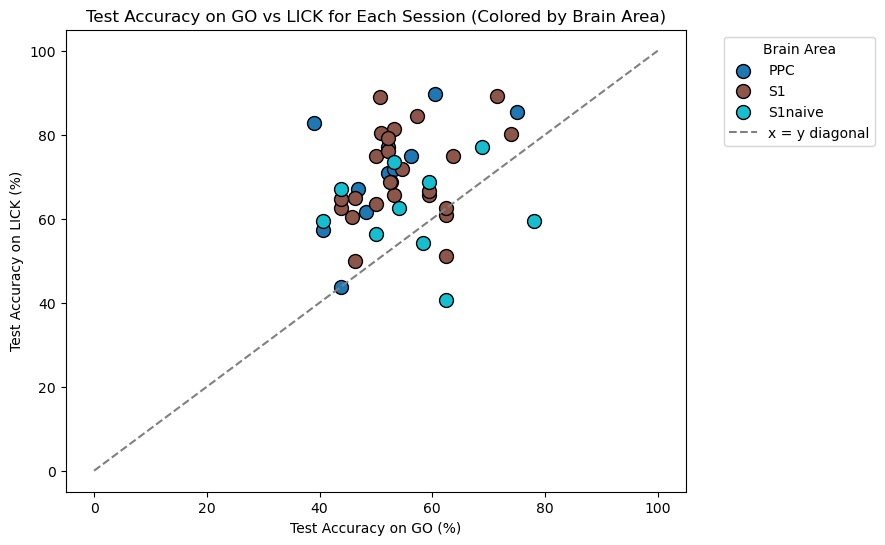

In [36]:
#lets plot what we have after undersampling 
# Dictionaries to store test accuracies, brain areas, and p-values by neuron
go_accuracies = {}
lick_accuracies = {}
brain_areas = {}

# Populate dictionaries with test accuracies and brain area
for result in results_population:
    session = result['Session']
    if isinstance(session, np.ndarray):  # If neuron is a NumPy array, convert to a scalar value
        session = session.item()  # Extract the value from the NumPy array
    
    # Store test accuracy for "GO" and "LICK"
    if result['Analysis Type'] == 'GO':
        go_accuracies[session] = result['Test Accuracy']
    elif result['Analysis Type'] == 'LICK':
        lick_accuracies[session] = result['Test Accuracy']
    
    # Store brain area information
    if session not in brain_areas:
        brain_areas[session] = result['Brain Area']

# Now only include neurons that have both "GO" and "LICK" test accuracies
go_test_accuracies = []
lick_test_accuracies = []
neuron_brain_areas = []

for session in go_accuracies:
    if session in lick_accuracies:  # Only include neurons with both GO and LICK data
        go_test_accuracies.append(go_accuracies[session])
        lick_test_accuracies.append(lick_accuracies[session])
        neuron_brain_areas.append(brain_areas[session])  # Track brain area for each neuron

# Convert lists to numpy arrays for compatibility with plotting
go_test_accuracies = np.array(go_test_accuracies)
lick_test_accuracies = np.array(lick_test_accuracies)
neuron_brain_areas = np.array(neuron_brain_areas)

# Define unique brain areas for color coding
unique_brain_areas = np.unique(neuron_brain_areas)
colors = plt.cm.get_cmap('tab10', len(unique_brain_areas))  # Use tab10 colormap for up to 10 areas

# Plotting the scatter plot with color coding by brain area
plt.figure(figsize=(8, 6))
for i, brain_area in enumerate(unique_brain_areas):
    mask = neuron_brain_areas == brain_area
    plt.scatter(go_test_accuracies[mask], lick_test_accuracies[mask], label=brain_area,
                color=colors(i), s=100, edgecolor='k')

# Adding x=y diagonal line
plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='x = y diagonal')

# Adding labels and title
plt.xlabel('Test Accuracy on GO (%)')
plt.ylabel('Test Accuracy on LICK (%)')
plt.title('Test Accuracy on GO vs LICK for Each Session (Colored by Brain Area)')

# Adding legend for brain areas
plt.legend(title="Brain Area", bbox_to_anchor=(1.05, 1), loc='upper left')
plot_filename = "session_performance_with_undersampling.png"
plt.savefig(plot_filename)
# Show plot
plt.show()


/tmp/ipykernel_1539/1608693703.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_brain_areas))  # Use tab10 colormap for up to 10 areas


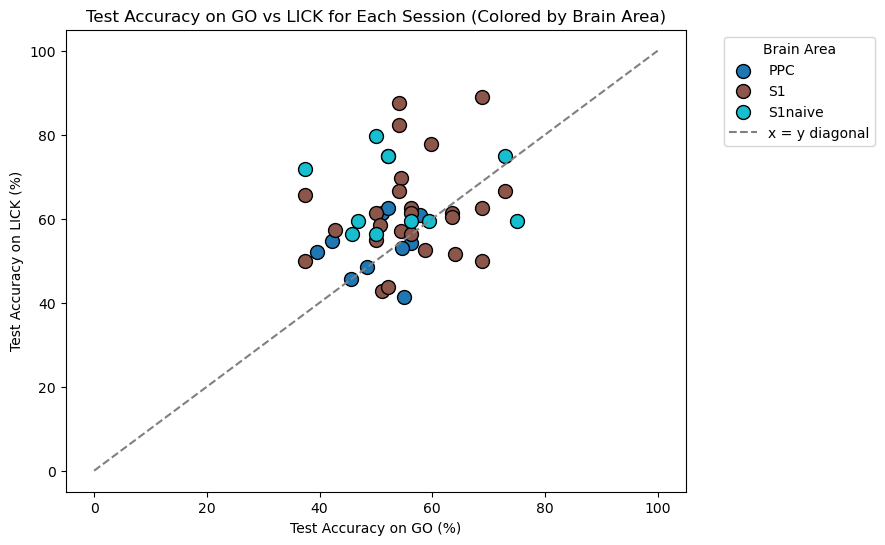

In [21]:
#lets plot what we have after sampling 
# Dictionaries to store test accuracies, brain areas, and p-values by neuron
go_accuracies = {}
lick_accuracies = {}
brain_areas = {}

# Populate dictionaries with test accuracies and brain area
for result in results_population:
    session = result['Session']
    if isinstance(session, np.ndarray):  # If neuron is a NumPy array, convert to a scalar value
        session = session.item()  # Extract the value from the NumPy array
    
    # Store test accuracy for "GO" and "LICK"
    if result['Analysis Type'] == 'GO':
        go_accuracies[session] = result['Test Accuracy']
    elif result['Analysis Type'] == 'LICK':
        lick_accuracies[session] = result['Test Accuracy']
    
    # Store brain area information
    if session not in brain_areas:
        brain_areas[session] = result['Brain Area']

# Now only include neurons that have both "GO" and "LICK" test accuracies
go_test_accuracies = []
lick_test_accuracies = []
neuron_brain_areas = []

for session in go_accuracies:
    if session in lick_accuracies:  # Only include neurons with both GO and LICK data
        go_test_accuracies.append(go_accuracies[session])
        lick_test_accuracies.append(lick_accuracies[session])
        neuron_brain_areas.append(brain_areas[session])  # Track brain area for each neuron

# Convert lists to numpy arrays for compatibility with plotting
go_test_accuracies = np.array(go_test_accuracies)
lick_test_accuracies = np.array(lick_test_accuracies)
neuron_brain_areas = np.array(neuron_brain_areas)

# Define unique brain areas for color coding
unique_brain_areas = np.unique(neuron_brain_areas)
colors = plt.cm.get_cmap('tab10', len(unique_brain_areas))  # Use tab10 colormap for up to 10 areas

# Plotting the scatter plot with color coding by brain area
plt.figure(figsize=(8, 6))
for i, brain_area in enumerate(unique_brain_areas):
    mask = neuron_brain_areas == brain_area
    plt.scatter(go_test_accuracies[mask], lick_test_accuracies[mask], label=brain_area,
                color=colors(i), s=100, edgecolor='k')

# Adding x=y diagonal line
plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='x = y diagonal')

# Adding labels and title
plt.xlabel('Test Accuracy on GO (%)')
plt.ylabel('Test Accuracy on LICK (%)')
plt.title('Test Accuracy on GO vs LICK for Each Session (Colored by Brain Area)')

# Adding legend for brain areas
plt.legend(title="Brain Area", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


In [10]:
results_single=pd.read_csv("results_singleneuron.csv")
results_pop=pd.read_csv("results_Population_undersample_pvalue.csv")
print(results_single.head(), results_pop.head())

  Brain Area Analysis Type            Neuron  Test Accuracy  p value
0         S1            GO  [3.01201803e+11]         46.875    0.791
1         S1            GO  [3.01201803e+11]         59.375    0.259
2         S1            GO  [3.01201803e+11]         65.625    0.065
3         S1            GO  [3.01201803e+11]         46.875    0.801
4         S1            GO  [4.06201804e+11]         37.500    0.990                 Session Brain Area Analysis Type  Test Accuracy  p value
0  ('0301', '20180323')         S1          LICK      65.625000    0.614
1  ('0406', '20180409')         S1          LICK      75.000000    0.226
2  ('0406', '20180503')         S1          LICK      65.000000    0.869
3  ('0406', '20180620')         S1          LICK      65.625000    0.032
4  ('0410', '20180427')         S1          LICK      76.041667    0.016


/tmp/ipykernel_126/4078797768.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_brain_areas))  # Use tab10 colormap
/tmp/ipykernel_126/4078797768.py:73: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(go_pop[mask], lick_pop[mask], label=f"{brain_area} (Population)",


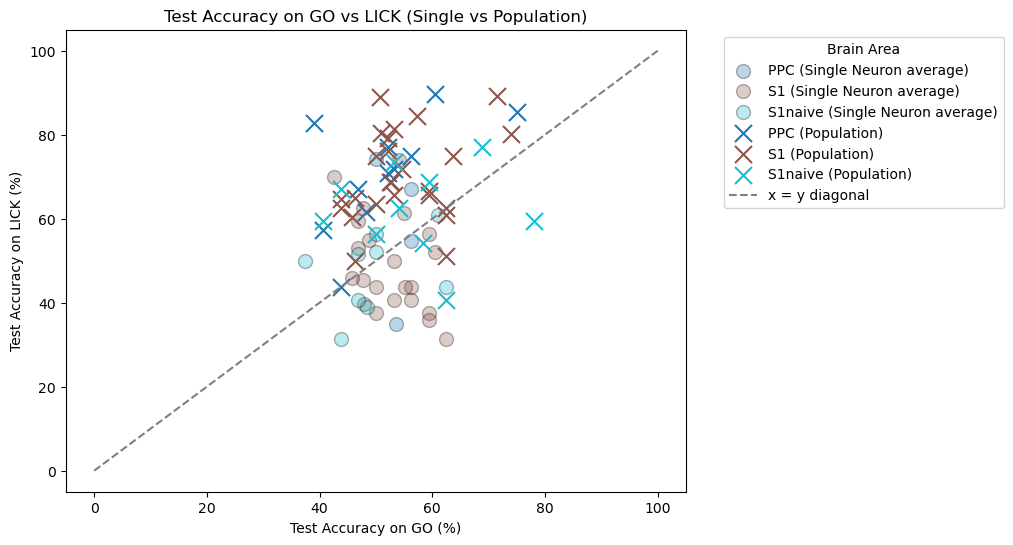

In [11]:

# Dictionaries to store test accuracies by session
go_accuracies_single = {}
lick_accuracies_single = {}
go_accuracies_pop = {}
lick_accuracies_pop = {}
brain_areas = {}

# Populate dictionaries from SINGLE NEURON data
for _, row in results_single.iterrows():
    session = row["Neuron"]  # Using Neuron as the identifier
    if row["Analysis Type"] == "GO":
        go_accuracies_single[session] = row["Test Accuracy"]
    elif row["Analysis Type"] == "LICK":
        lick_accuracies_single[session] = row["Test Accuracy"]
    
    # Store brain area
    brain_areas[session] = row["Brain Area"]

# Populate dictionaries from POPULATION data
for _, row in results_pop.iterrows():
    session = row["Session"]  # Using Session as the identifier
    if row["Analysis Type"] == "GO":
        go_accuracies_pop[session] = row["Test Accuracy"]
    elif row["Analysis Type"] == "LICK":
        lick_accuracies_pop[session] = row["Test Accuracy"]
    
    # Store brain area
    brain_areas[session] = row["Brain Area"]

# Now extract only the sessions that have both GO and LICK test accuracies
go_single = []
lick_single = []
go_pop = []
lick_pop = []
neuron_brain_areas_single = []
neuron_brain_areas_pop = []

for session in brain_areas:
    if session in go_accuracies_single and session in lick_accuracies_single:
        go_single.append(go_accuracies_single[session])
        lick_single.append(lick_accuracies_single[session])
        neuron_brain_areas_single.append(brain_areas[session])  # Track brain area

    if session in go_accuracies_pop and session in lick_accuracies_pop:
        go_pop.append(go_accuracies_pop[session])
        lick_pop.append(lick_accuracies_pop[session])
        neuron_brain_areas_pop.append(brain_areas[session])  # Track brain area

# Convert to numpy arrays for plotting
go_single = np.array(go_single)
lick_single = np.array(lick_single)
go_pop = np.array(go_pop)
lick_pop = np.array(lick_pop)
neuron_brain_areas_single = np.array(neuron_brain_areas_single)
neuron_brain_areas_pop = np.array(neuron_brain_areas_pop)

# Define unique brain areas for color coding
unique_brain_areas = np.unique(neuron_brain_areas_single)
colors = plt.cm.get_cmap("tab10", len(unique_brain_areas))  # Use tab10 colormap

# Create scatter plot
plt.figure(figsize=(8, 6))

# Plot SINGLE neuron data (transparent)
for i, brain_area in enumerate(unique_brain_areas):
    mask = neuron_brain_areas_single == brain_area
    plt.scatter(go_single[mask], lick_single[mask], label=f"{brain_area} (Single Neuron average)",
                color=colors(i), alpha=0.3, s=100, edgecolor="k")

# Plot POPULATION data (bold, same color)
for i, brain_area in enumerate(unique_brain_areas):
    mask = neuron_brain_areas_pop == brain_area
    plt.scatter(go_pop[mask], lick_pop[mask], label=f"{brain_area} (Population)",
                color=colors(i), alpha=1.0, s=150, edgecolor="k", marker="x")

# Add x=y diagonal line
plt.plot([0, 100], [0, 100], linestyle="--", color="gray", label="x = y diagonal")

# Labels and title
plt.xlabel("Test Accuracy on GO (%)")
plt.ylabel("Test Accuracy on LICK (%)")
plt.title("Test Accuracy on GO vs LICK (Single vs Population)")

# Legend
plt.legend(title="Brain Area", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem  # Standard error calculation

# Load data
results_single = pd.read_csv("results_singleneuron.csv")
results_pop = pd.read_csv("results_Population_undersample.csv")

# Convert 'Neuron' column in results_single to string
results_single["Neuron"] = results_single["Neuron"].astype(str)

# Data dictionaries
brain_areas_single = {}
brain_areas_pop = {}

# Populate SINGLE neuron data
for _, row in results_single.iterrows():
    brain_area = row["Brain Area"]
    if brain_area not in brain_areas_single:
        brain_areas_single[brain_area] = {"GO": [], "LICK": []}
    if row["Analysis Type"] == "GO":
        brain_areas_single[brain_area]["GO"].append(row["Test Accuracy"])
    elif row["Analysis Type"] == "LICK":
        brain_areas_single[brain_area]["LICK"].append(row["Test Accuracy"])

# Populate POPULATION data (storing only the max accuracy for each brain area)
for _, row in results_pop.iterrows():
    brain_area = row["Brain Area"]
    if brain_area not in brain_areas_pop:
        brain_areas_pop[brain_area] = {"GO": [], "LICK": []}
    if row["Analysis Type"] == "GO":
        brain_areas_pop[brain_area]["GO"].append(row["Test Accuracy"])
    elif row["Analysis Type"] == "LICK":
        brain_areas_pop[brain_area]["LICK"].append(row["Test Accuracy"])

# Compute mean and standard error (SE) for single neurons
def compute_mean_se(data_dict):
    means, errors = {}, {}
    for brain_area, data in data_dict.items():
        means[brain_area] = {
            "GO": np.mean(data["GO"]) if data["GO"] else np.nan,
            "LICK": np.mean(data["LICK"]) if data["LICK"] else np.nan,
        }
        errors[brain_area] = {
            "GO": sem(data["GO"]) if len(data["GO"]) > 1 else 0,
            "LICK": sem(data["LICK"]) if len(data["LICK"]) > 1 else 0,
        }
    return means, errors

means_single, errors_single = compute_mean_se(brain_areas_single)

# Extract max performance for population data
max_pop = {
    brain_area: {
        "GO": np.max(data["GO"]) if data["GO"] else np.nan,
        "LICK": np.max(data["LICK"]) if data["LICK"] else np.nan,
    }
    for brain_area, data in brain_areas_pop.items()
}

# Get unique brain areas and colors
unique_brain_areas = list(set(means_single.keys()).union(set(max_pop.keys())))
colors = plt.cm.get_cmap("tab10", len(unique_brain_areas))  # Assign colors per brain area

# Scatter plot with error bars
plt.figure(figsize=(8, 6))

for i, brain_area in enumerate(unique_brain_areas):
    # Plot SINGLE neurons (with mean and error bars)
   for i, brain_area in enumerate(unique_brain_areas):
    mask = neuron_brain_areas_single == brain_area
    plt.scatter(go_single[mask], lick_single[mask], label=f"{brain_area} (Single Neuron)",
                color=colors(i), alpha=0.3, s=100, edgecolor="k")
    
    # Plot POPULATION neurons (only max performance)
    if brain_area in max_pop:
        plt.scatter(
            max_pop[brain_area]["GO"], max_pop[brain_area]["LICK"],
            color=colors(i), alpha=1.0, marker="s", edgecolor="k", s=100, label=f"{brain_area} (Population Average)"
        )

# Add x=y diagonal line
plt.plot([0, 100], [0, 100], linestyle="--", color="gray", label="x = y diagonal")

# Labels and title
plt.xlabel("Test Accuracy on GO (%)")
plt.ylabel("Test Accuracy on LICK (%)")
plt.title("Test Accuracy (GO vs LICK) by Brain Area")

# Legend
plt.legend(title="Brain Area", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()


/tmp/ipykernel_126/2032200189.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_brain_areas))  # Assign colors per brain area


NameError: name 'neuron_brain_areas_single' is not defined

<Figure size 800x600 with 0 Axes>

/tmp/ipykernel_126/4094493244.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_brain_areas))  # Assign colors per brain area


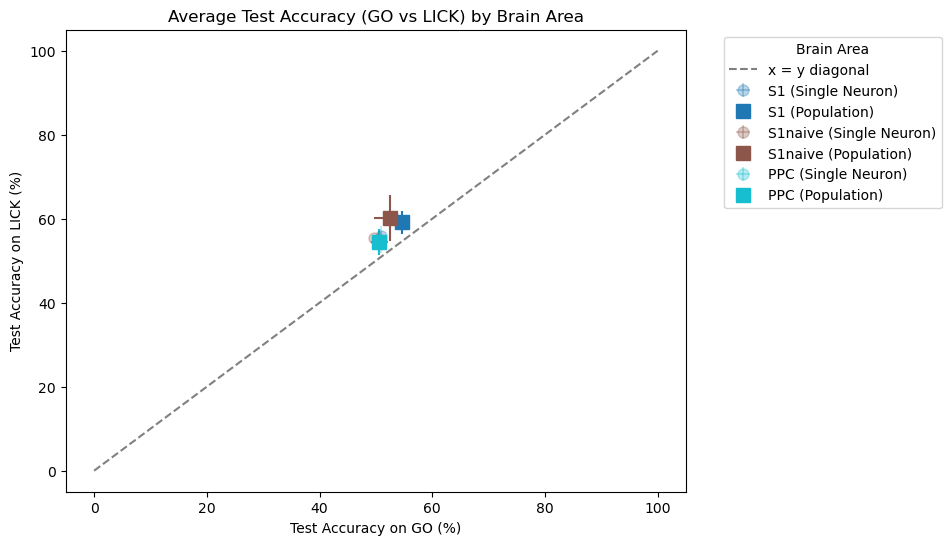

In [12]:
from scipy.stats import sem  # Standard error calculation

# Data dictionaries
brain_areas_single = {}
brain_areas_pop = {}

# Populate SINGLE neuron data
for _, row in results_single.iterrows():
    brain_area = row["Brain Area"]
    if brain_area not in brain_areas_single:
        brain_areas_single[brain_area] = {"GO": [], "LICK": []}
    if row["Analysis Type"] == "GO":
        brain_areas_single[brain_area]["GO"].append(row["Test Accuracy"])
    elif row["Analysis Type"] == "LICK":
        brain_areas_single[brain_area]["LICK"].append(row["Test Accuracy"])

# Populate POPULATION data
for _, row in results_pop.iterrows():
    brain_area = row["Brain Area"]
    if brain_area not in brain_areas_pop:
        brain_areas_pop[brain_area] = {"GO": [], "LICK": []}
    if row["Analysis Type"] == "GO":
        brain_areas_pop[brain_area]["GO"].append(row["Test Accuracy"])
    elif row["Analysis Type"] == "LICK":
        brain_areas_pop[brain_area]["LICK"].append(row["Test Accuracy"])

# Compute mean and standard error (SE)
def compute_mean_se(data_dict):
    means, errors = {}, {}
    for brain_area, data in data_dict.items():
        means[brain_area] = {
            "GO": np.mean(data["GO"]) if data["GO"] else np.nan,
            "LICK": np.mean(data["LICK"]) if data["LICK"] else np.nan,
        }
        errors[brain_area] = {
            "GO": sem(data["GO"]) if len(data["GO"]) > 1 else 0,
            "LICK": sem(data["LICK"]) if len(data["LICK"]) > 1 else 0,
        }
    return means, errors

means_single, errors_single = compute_mean_se(brain_areas_single)
means_pop, errors_pop = compute_mean_se(brain_areas_pop)

# Get unique brain areas and colors
unique_brain_areas = list(set(means_single.keys()).union(set(means_pop.keys())))
colors = plt.cm.get_cmap("tab10", len(unique_brain_areas))  # Assign colors per brain area

# Scatter plot with error bars
plt.figure(figsize=(8, 6))

for i, brain_area in enumerate(unique_brain_areas):
    if brain_area in means_single:
        plt.errorbar(
            means_single[brain_area]["GO"], means_single[brain_area]["LICK"],
            xerr=errors_single[brain_area]["GO"], yerr=errors_single[brain_area]["LICK"],
            fmt="o", color=colors(i), alpha=0.3, label=f"{brain_area} (Single Neuron)", markersize=8
        )
    
    if brain_area in means_pop:
        plt.errorbar(
            means_pop[brain_area]["GO"], means_pop[brain_area]["LICK"],
            xerr=errors_pop[brain_area]["GO"], yerr=errors_pop[brain_area]["LICK"],
            fmt="s", color=colors(i), alpha=1.0, label=f"{brain_area} (Population)", markersize=10
        )

# Add x=y diagonal line
plt.plot([0, 100], [0, 100], linestyle="--", color="gray", label="x = y diagonal")

# Labels and title
plt.xlabel("Test Accuracy on GO (%)")
plt.ylabel("Test Accuracy on LICK (%)")
plt.title("Average Test Accuracy (GO vs LICK) by Brain Area")

# Legend
plt.legend(title="Brain Area", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()


In [ ]:
for brain_area in unique_brain_areas:
    # Create a mask for the current brain area
    mask = neuron_brain_areas == brain_area
    
    # Create a new figure for each brain area
    plt.figure(figsize=(8, 6))
    
    # Plot GO vs. LICK test accuracies for the current brain area
    plt.scatter(go_test_accuracies[mask], lick_test_accuracies[mask], 
                color=colors(unique_brain_areas.tolist().index(brain_area)), s=100, edgecolor='k')
    
    # Adding x=y diagonal line
    plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='x = y diagonal')
    
    # Adding labels and title specific to each brain area
    plt.xlabel('Test Accuracy on GO (%)')
    plt.ylabel('Test Accuracy on LICK (%)')
    plt.title(f'Test Accuracy on GO vs LICK for Neurons in {brain_area}')
    
    # Adding legend for clarity
    plt.legend([f'Neurons in {brain_area}', 'x = y diagonal'])
    
    # Show the plot for the current brain area
    plt.show()

Brain Area: S1, Analysis Type: GO
(231, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.1130


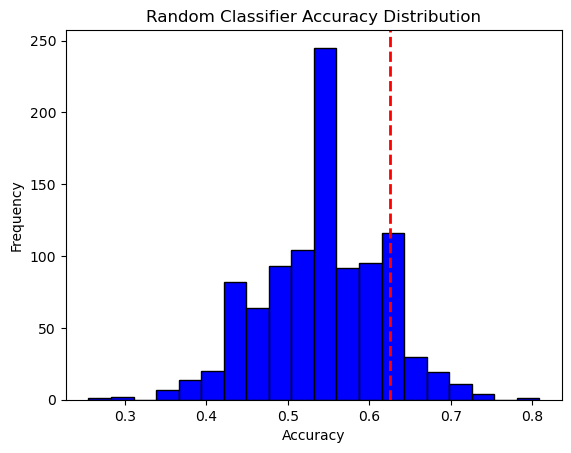

Confusion Matrix:
 [[25  5]
 [14  3]]
Class-specific Accuracy: [0.83333333 0.17647059]
(122, 41, 3)
 Test Accuracy = 75.00%, p-value = 0.0480


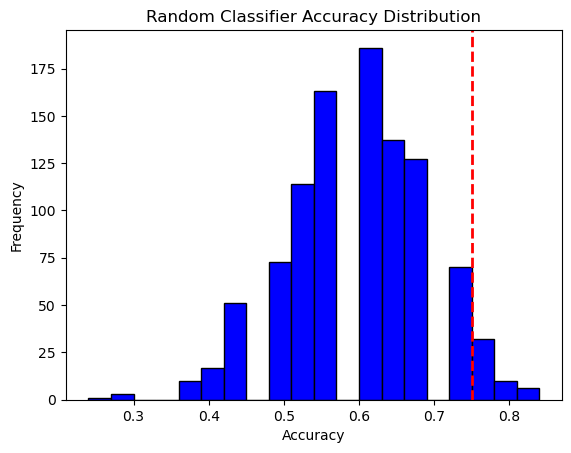

Confusion Matrix:
 [[ 0  7]
 [ 1 17]]
Class-specific Accuracy: [0.         0.94444444]
(403, 41, 3)
 Test Accuracy = 47.50%, p-value = 0.6820


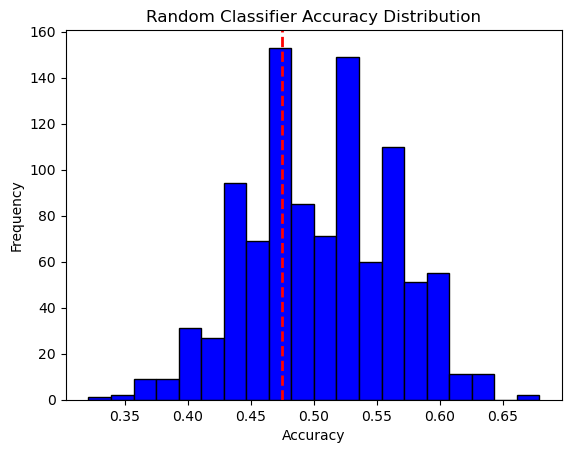

Confusion Matrix:
 [[16 20]
 [22 23]]
Class-specific Accuracy: [0.44444444 0.51111111]
(233, 41, 3)
 Test Accuracy = 40.62%, p-value = 0.9010


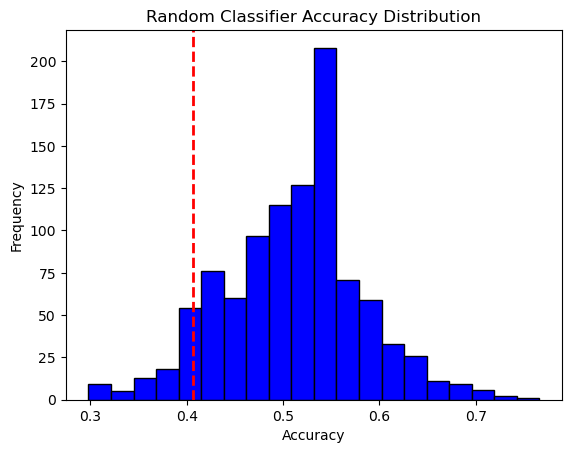

Confusion Matrix:
 [[ 8 13]
 [14 12]]
Class-specific Accuracy: [0.38095238 0.46153846]
(529, 41, 3)
 Test Accuracy = 57.29%, p-value = 0.0660


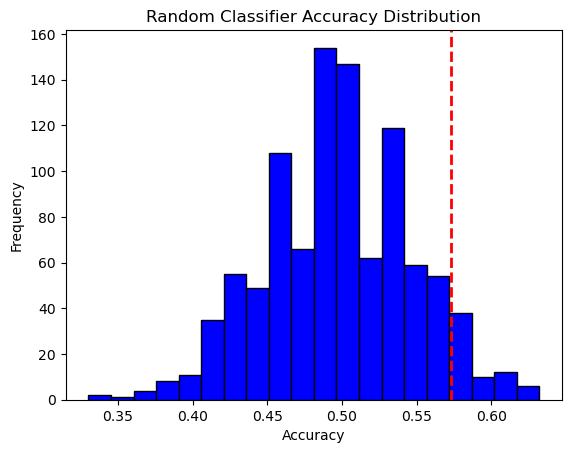

Confusion Matrix:
 [[36 16]
 [28 26]]
Class-specific Accuracy: [0.69230769 0.48148148]
(410, 41, 3)
 Test Accuracy = 52.50%, p-value = 0.3900


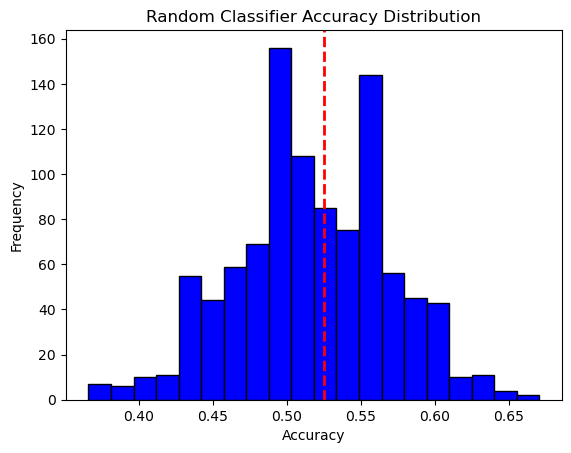

Confusion Matrix:
 [[15 19]
 [21 27]]
Class-specific Accuracy: [0.44117647 0.5625    ]
(429, 41, 3)
 Test Accuracy = 48.75%, p-value = 0.9460


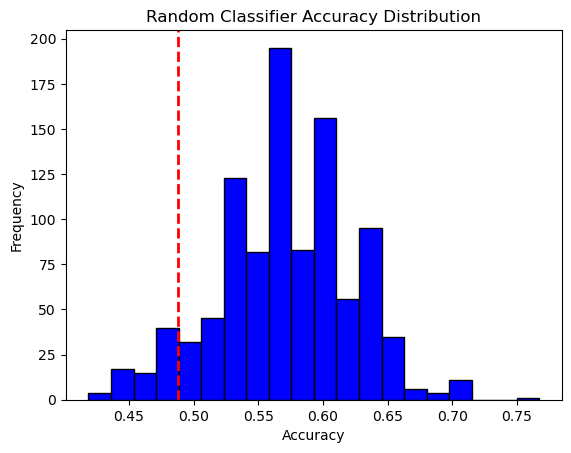

Confusion Matrix:
 [[29 30]
 [13 14]]
Class-specific Accuracy: [0.49152542 0.51851852]
(492, 41, 3)
 Test Accuracy = 58.33%, p-value = 0.0920


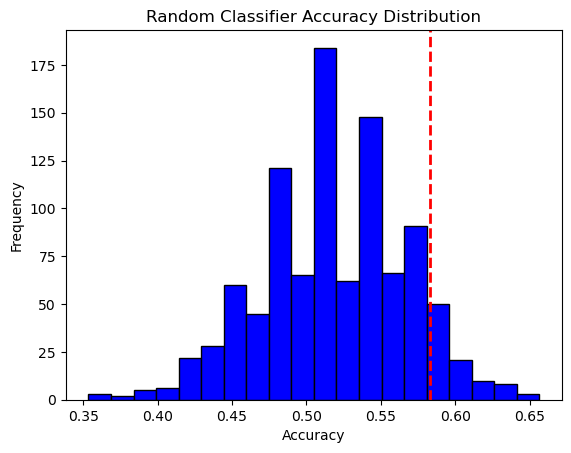

Confusion Matrix:
 [[38 20]
 [20 21]]
Class-specific Accuracy: [0.65517241 0.51219512]
(516, 41, 3)
 Test Accuracy = 52.08%, p-value = 0.2970


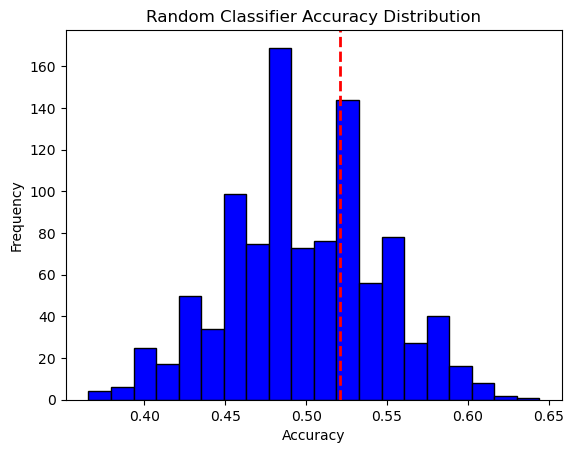

Confusion Matrix:
 [[32 21]
 [32 19]]
Class-specific Accuracy: [0.60377358 0.37254902]
(680, 41, 3)
 Test Accuracy = 43.75%, p-value = 0.9380


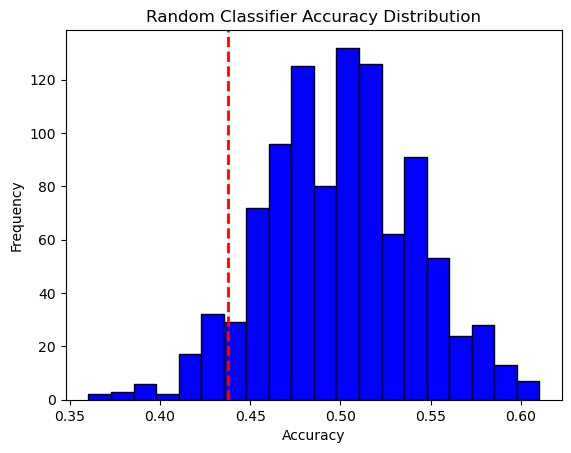

Confusion Matrix:
 [[41 24]
 [52 19]]
Class-specific Accuracy: [0.63076923 0.26760563]
(547, 41, 3)
 Test Accuracy = 52.08%, p-value = 0.3370


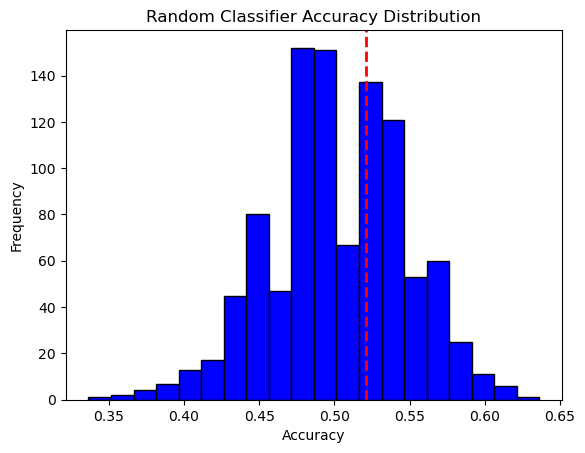

Confusion Matrix:
 [[43  6]
 [47 14]]
Class-specific Accuracy: [0.87755102 0.2295082 ]
(600, 41, 3)
 Test Accuracy = 66.96%, p-value = 0.0000


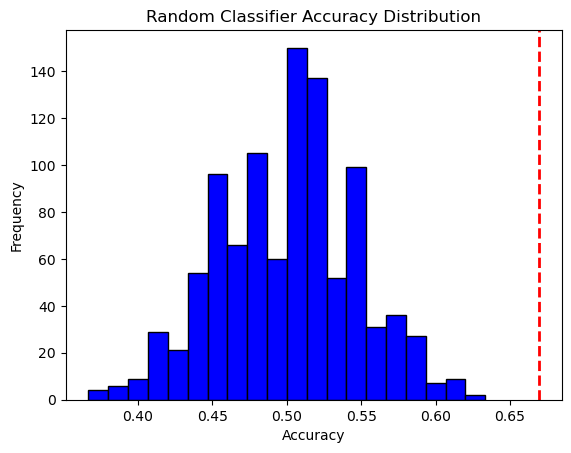

Confusion Matrix:
 [[49 13]
 [27 31]]
Class-specific Accuracy: [0.79032258 0.53448276]
(326, 41, 3)
 Test Accuracy = 51.56%, p-value = 0.3550


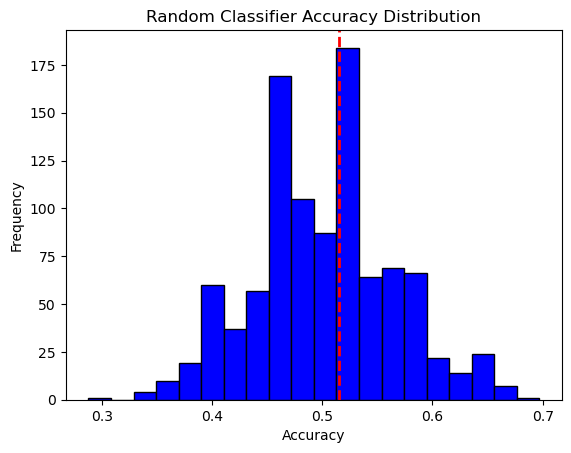

Confusion Matrix:
 [[26  5]
 [27  8]]
Class-specific Accuracy: [0.83870968 0.22857143]
(486, 41, 3)
 Test Accuracy = 46.88%, p-value = 0.7590


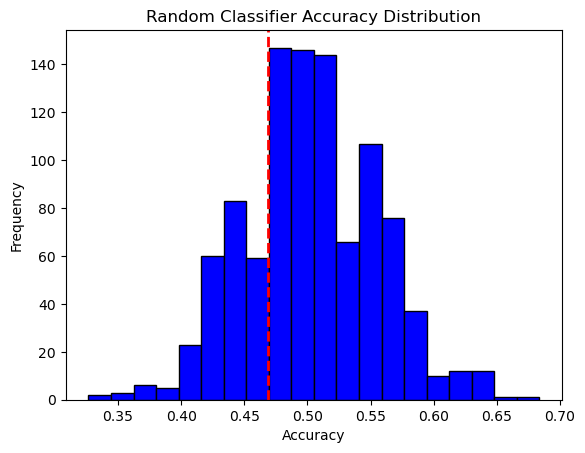

Confusion Matrix:
 [[23 27]
 [25 23]]
Class-specific Accuracy: [0.46       0.47916667]
(422, 41, 3)
 Test Accuracy = 48.75%, p-value = 0.6490


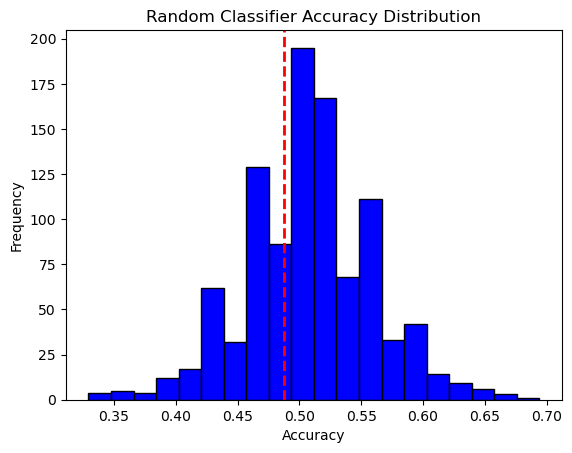

Confusion Matrix:
 [[28 20]
 [21 16]]
Class-specific Accuracy: [0.58333333 0.43243243]
(558, 41, 3)
 Test Accuracy = 55.36%, p-value = 0.1430


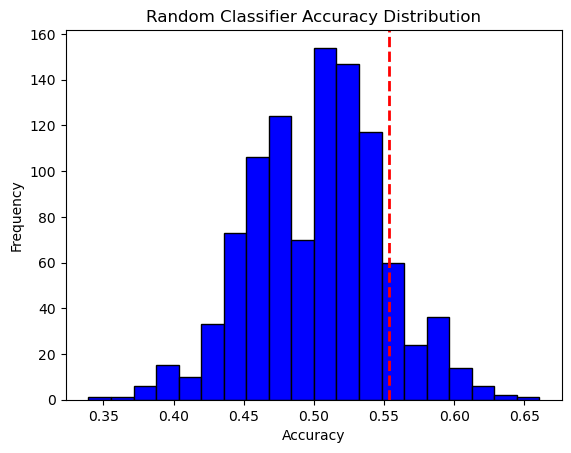

Confusion Matrix:
 [[29 22]
 [28 33]]
Class-specific Accuracy: [0.56862745 0.54098361]
(302, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.1680


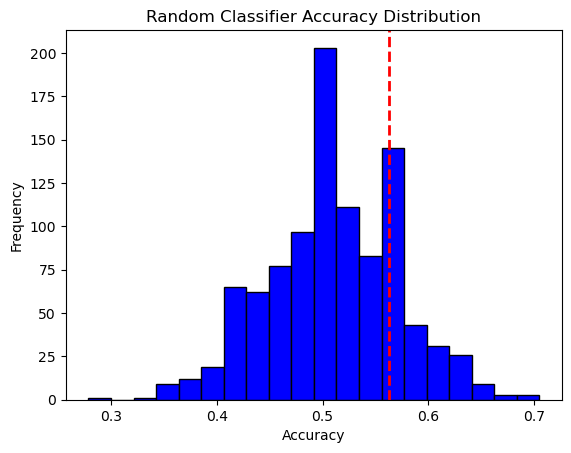

Confusion Matrix:
 [[17 17]
 [ 7 20]]
Class-specific Accuracy: [0.5        0.74074074]
(213, 41, 3)
 Test Accuracy = 50.00%, p-value = 0.4740


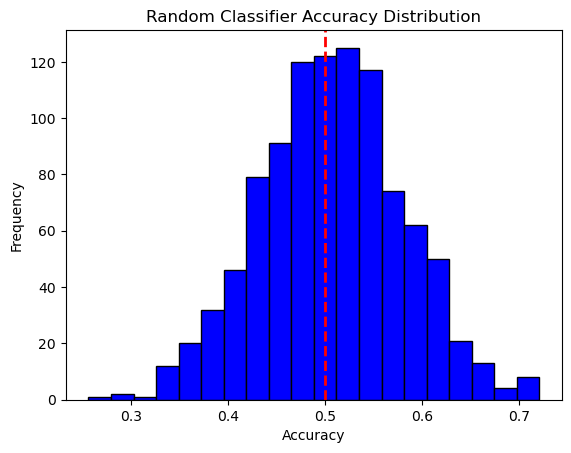

Confusion Matrix:
 [[ 8 14]
 [ 9 12]]
Class-specific Accuracy: [0.36363636 0.57142857]
(415, 41, 3)
 Test Accuracy = 53.75%, p-value = 0.2440


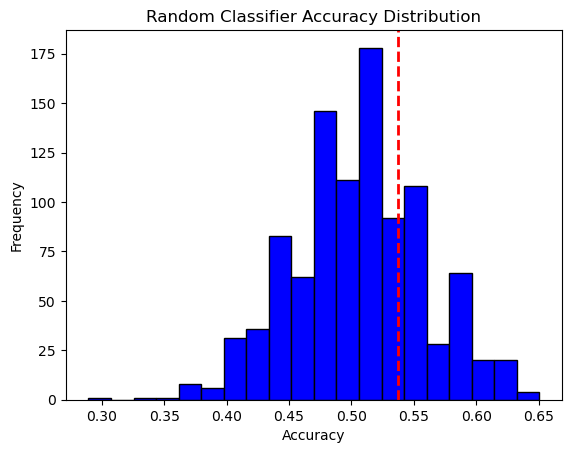

Confusion Matrix:
 [[27 14]
 [23 19]]
Class-specific Accuracy: [0.65853659 0.45238095]
(339, 41, 3)
 Test Accuracy = 45.31%, p-value = 0.8710


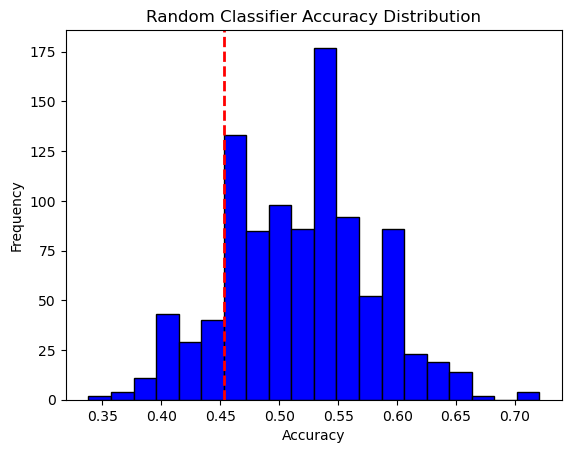

Confusion Matrix:
 [[14 14]
 [23 17]]
Class-specific Accuracy: [0.5   0.425]
(600, 41, 3)
 Test Accuracy = 49.11%, p-value = 0.6600


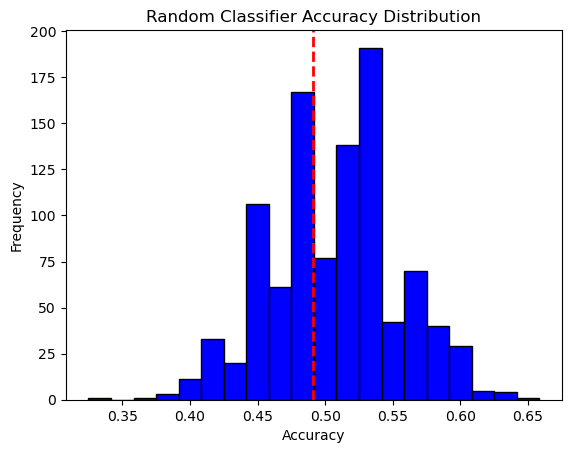

Confusion Matrix:
 [[36 31]
 [31 22]]
Class-specific Accuracy: [0.53731343 0.41509434]
(313, 41, 3)
 Test Accuracy = 39.58%, p-value = 0.9660


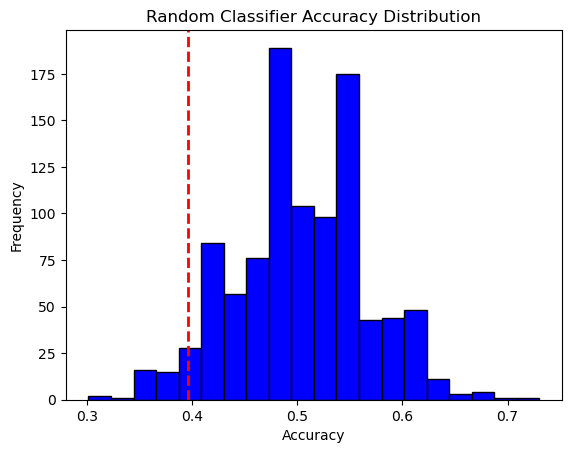

Confusion Matrix:
 [[17 18]
 [18 10]]
Class-specific Accuracy: [0.48571429 0.35714286]
(264, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.2340


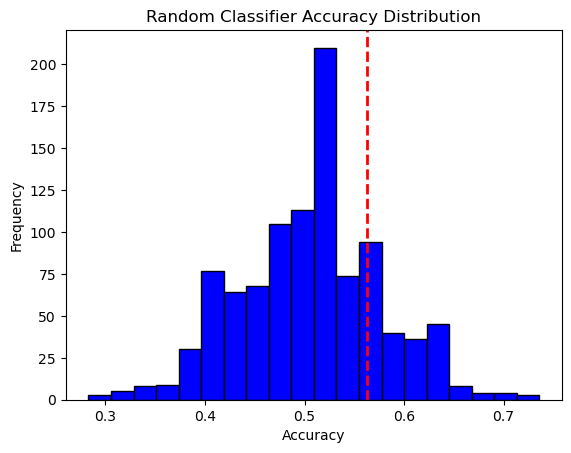

Confusion Matrix:
 [[25  0]
 [22  6]]
Class-specific Accuracy: [1.         0.21428571]
(510, 41, 3)
 Test Accuracy = 52.08%, p-value = 0.3370


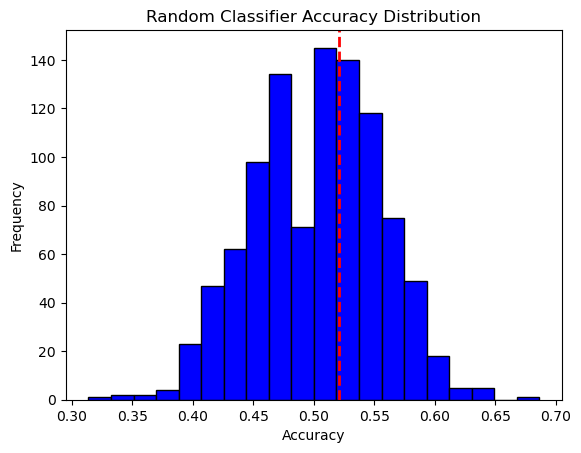

Confusion Matrix:
 [[30 23]
 [26 23]]
Class-specific Accuracy: [0.56603774 0.46938776]
(251, 41, 3)
 Test Accuracy = 64.58%, p-value = 0.0320


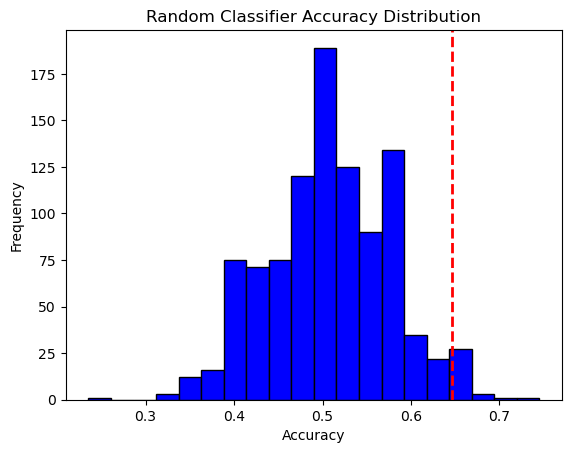

Confusion Matrix:
 [[14  9]
 [ 9 19]]
Class-specific Accuracy: [0.60869565 0.67857143]
(328, 41, 3)
 Test Accuracy = 67.19%, p-value = 0.0020


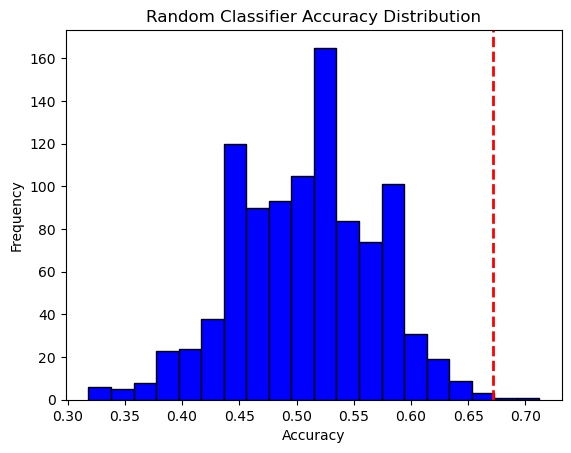

Confusion Matrix:
 [[22  8]
 [13 23]]
Class-specific Accuracy: [0.73333333 0.63888889]
Brain Area: S1, Analysis Type: LICK
(231, 41, 3)
 Test Accuracy = 81.25%, p-value = 0.0010


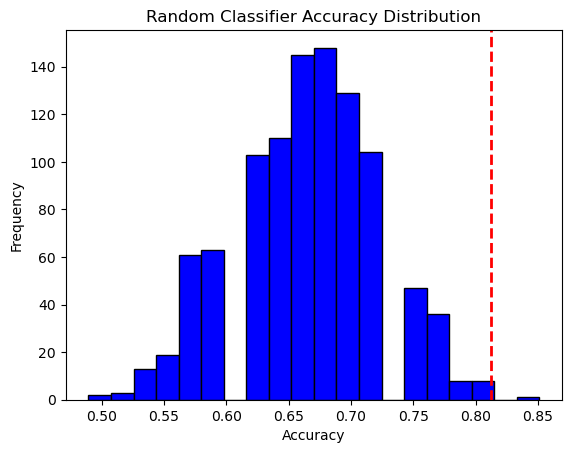

Confusion Matrix:
 [[ 0 10]
 [ 0 37]]
Class-specific Accuracy: [0. 1.]
(122, 41, 3)
 Test Accuracy = 68.75%, p-value = 0.3890


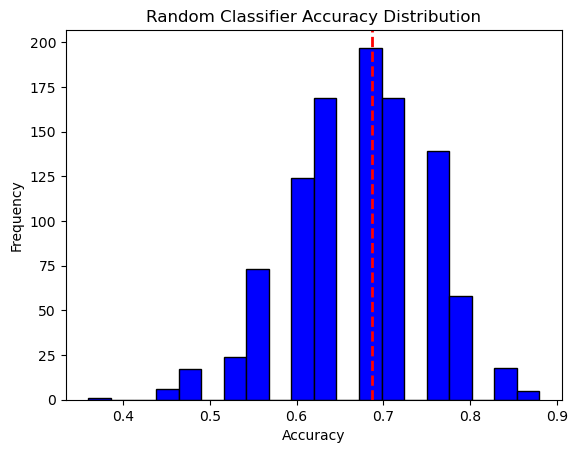

Confusion Matrix:
 [[15  5]
 [ 4  1]]
Class-specific Accuracy: [0.75 0.2 ]
(403, 41, 3)
 Test Accuracy = 76.25%, p-value = 0.0540


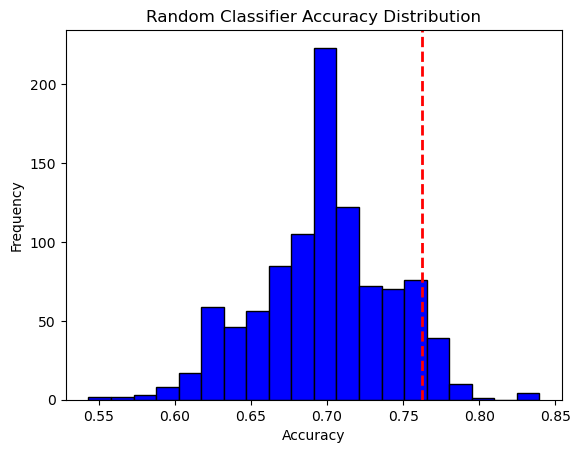

Confusion Matrix:
 [[ 4 11]
 [ 8 58]]
Class-specific Accuracy: [0.26666667 0.87878788]
(233, 41, 3)
 Test Accuracy = 40.62%, p-value = 0.9060


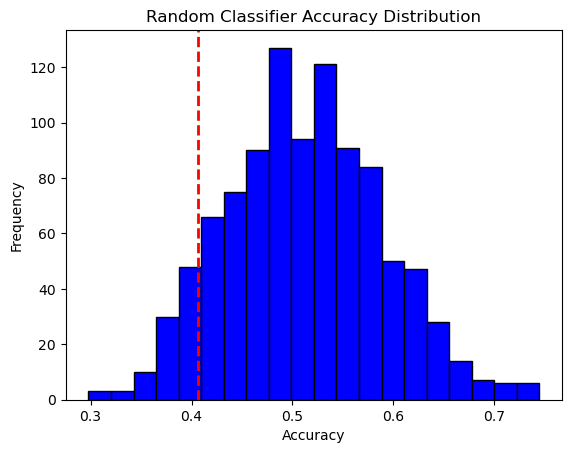

Confusion Matrix:
 [[ 8 12]
 [14 13]]
Class-specific Accuracy: [0.4        0.48148148]
(529, 41, 3)
 Test Accuracy = 78.12%, p-value = 0.0090


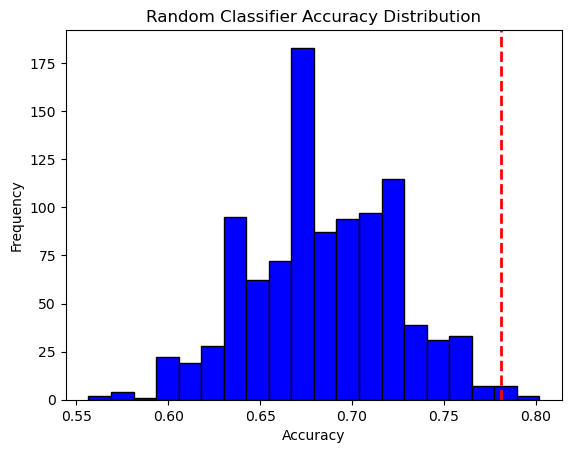

Confusion Matrix:
 [[ 0 21]
 [ 1 84]]
Class-specific Accuracy: [0.         0.98823529]
(410, 41, 3)
 Test Accuracy = 100.00%, p-value = 1.0000


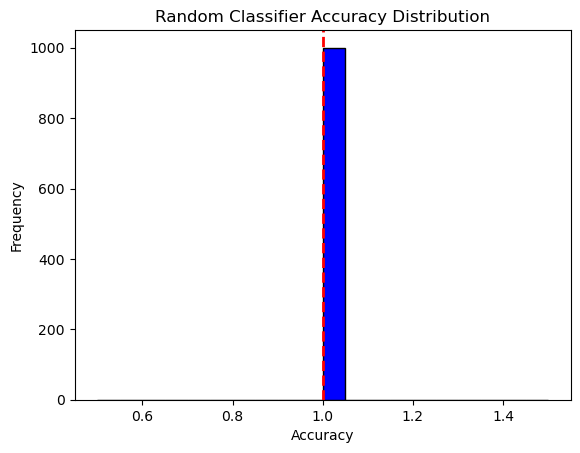

Confusion Matrix:
 [[82]]
Class-specific Accuracy: [1.]
(429, 41, 3)


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


 Test Accuracy = 86.25%, p-value = 0.0020


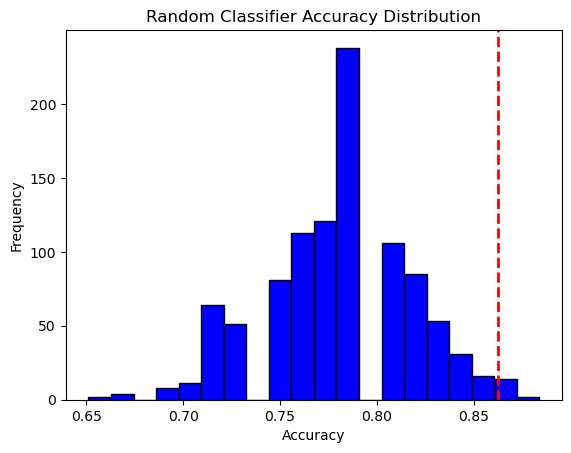

Confusion Matrix:
 [[ 0 11]
 [ 2 73]]
Class-specific Accuracy: [0.         0.97333333]
(492, 41, 3)
 Test Accuracy = 77.08%, p-value = 0.0010


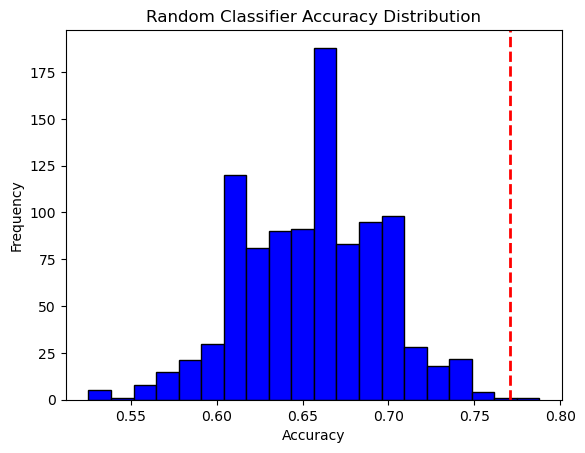

Confusion Matrix:
 [[ 4 18]
 [ 5 72]]
Class-specific Accuracy: [0.18181818 0.93506494]
(516, 41, 3)
 Test Accuracy = 89.58%, p-value = 0.0000


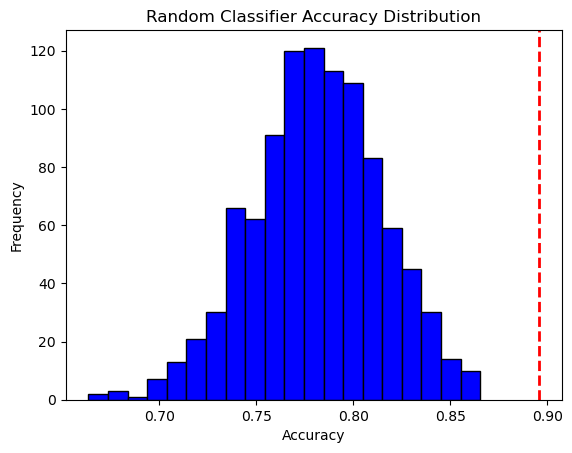

Confusion Matrix:
 [[ 0 13]
 [ 0 91]]
Class-specific Accuracy: [0. 1.]
(680, 41, 3)
 Test Accuracy = 91.41%, p-value = 0.0000


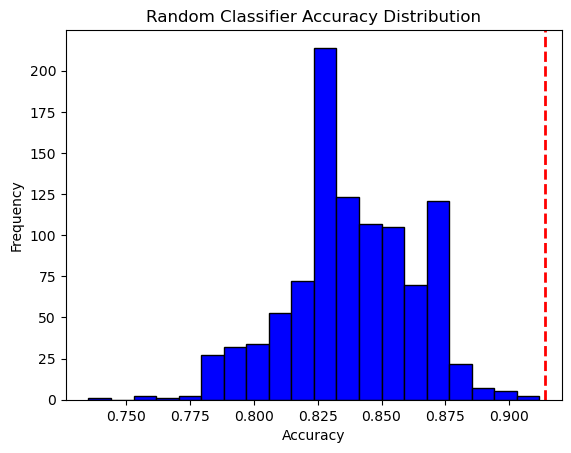

Confusion Matrix:
 [[  0  12]
 [  0 124]]
Class-specific Accuracy: [0. 1.]
(547, 41, 3)
 Test Accuracy = 89.58%, p-value = 0.0020


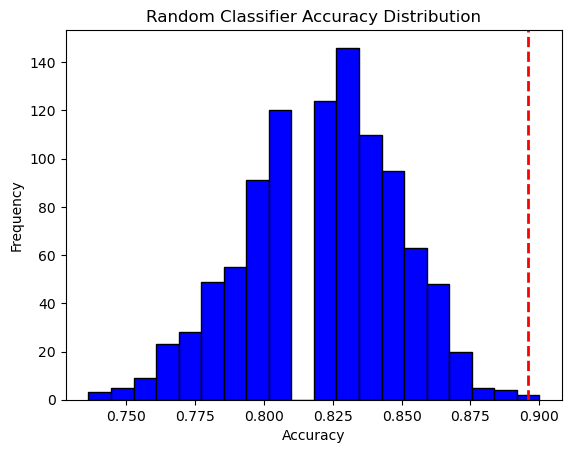

Confusion Matrix:
 [[ 0 11]
 [ 0 99]]
Class-specific Accuracy: [0. 1.]
(600, 41, 3)
 Test Accuracy = 84.82%, p-value = 0.0000


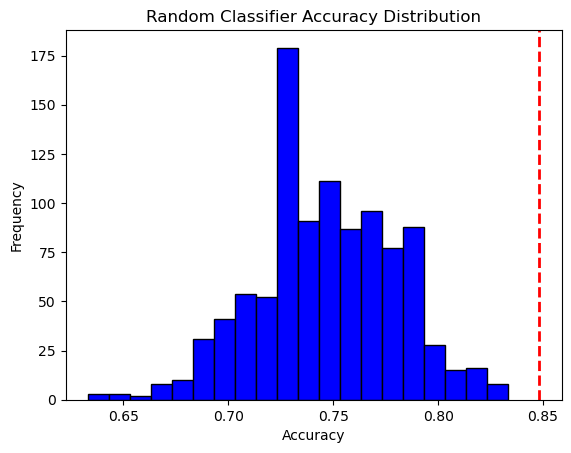

Confusion Matrix:
 [[  0  18]
 [  0 102]]
Class-specific Accuracy: [0. 1.]
(326, 41, 3)
 Test Accuracy = 82.81%, p-value = 0.0070


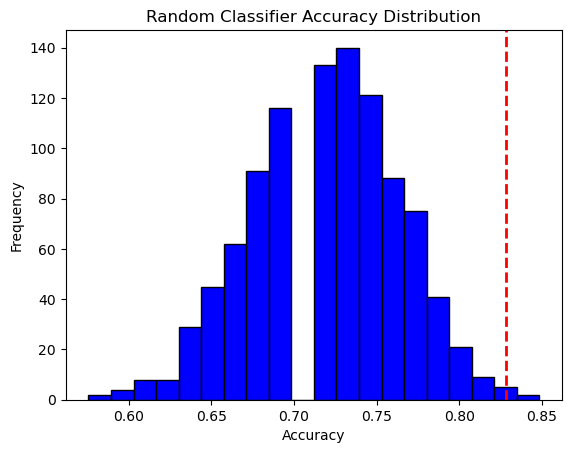

Confusion Matrix:
 [[ 0 11]
 [ 0 55]]
Class-specific Accuracy: [0. 1.]
(486, 41, 3)
 Test Accuracy = 65.62%, p-value = 0.0160


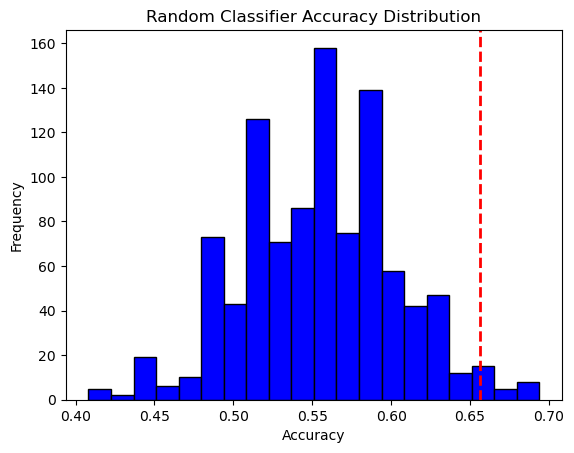

Confusion Matrix:
 [[ 0 33]
 [ 0 65]]
Class-specific Accuracy: [0. 1.]
(422, 41, 3)
 Test Accuracy = 70.00%, p-value = 0.0270


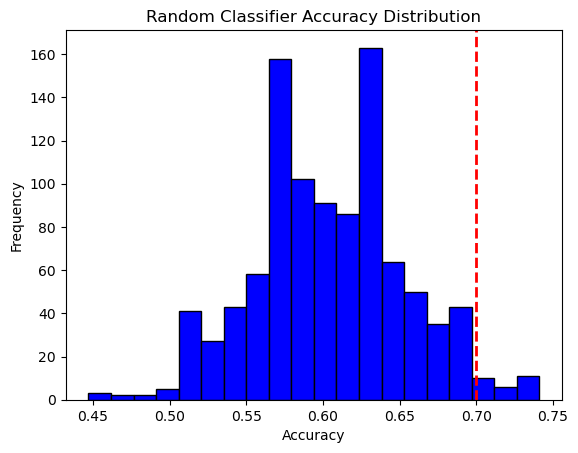

Confusion Matrix:
 [[ 0 23]
 [ 2 60]]
Class-specific Accuracy: [0.         0.96774194]
(558, 41, 3)
 Test Accuracy = 88.39%, p-value = 0.0000


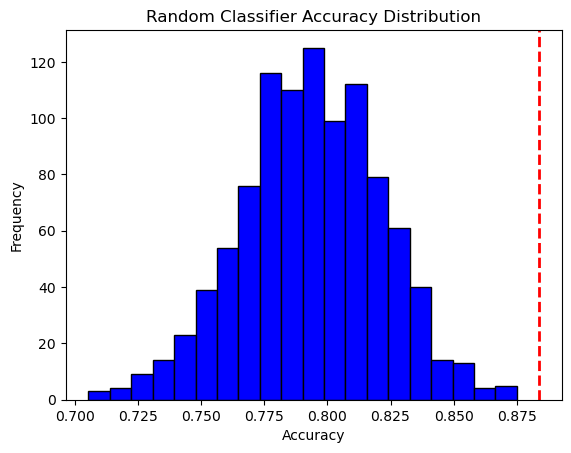

Confusion Matrix:
 [[ 0 13]
 [ 0 99]]
Class-specific Accuracy: [0. 1.]
(302, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.0950


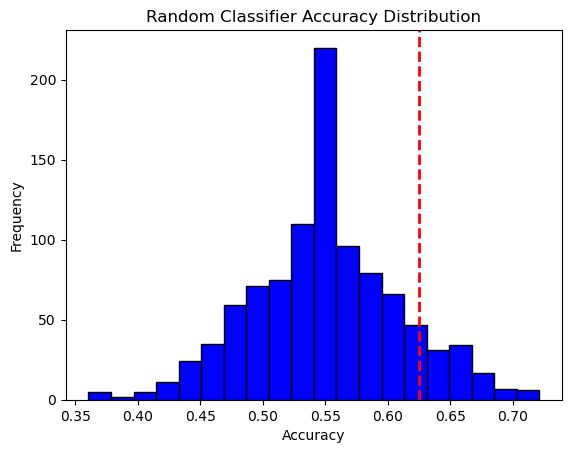

Confusion Matrix:
 [[ 6 15]
 [ 9 31]]
Class-specific Accuracy: [0.28571429 0.775     ]
(213, 41, 3)
 Test Accuracy = 78.12%, p-value = 0.3810


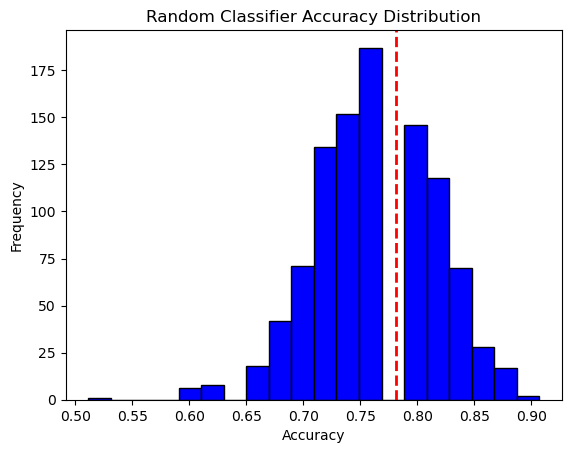

Confusion Matrix:
 [[ 2  4]
 [ 7 30]]
Class-specific Accuracy: [0.33333333 0.81081081]
(415, 41, 3)
 Test Accuracy = 90.00%, p-value = 0.0040


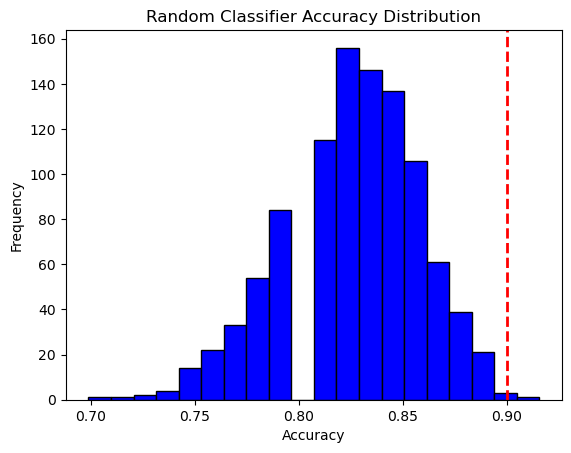

Confusion Matrix:
 [[ 0  8]
 [ 0 75]]
Class-specific Accuracy: [0. 1.]
(339, 41, 3)
 Test Accuracy = 92.19%, p-value = 0.0330


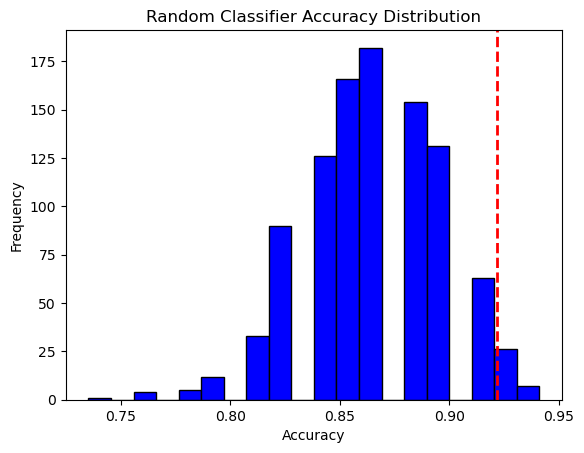

Confusion Matrix:
 [[ 0  5]
 [ 0 63]]
Class-specific Accuracy: [0. 1.]
(600, 41, 3)
 Test Accuracy = 87.50%, p-value = 0.0020


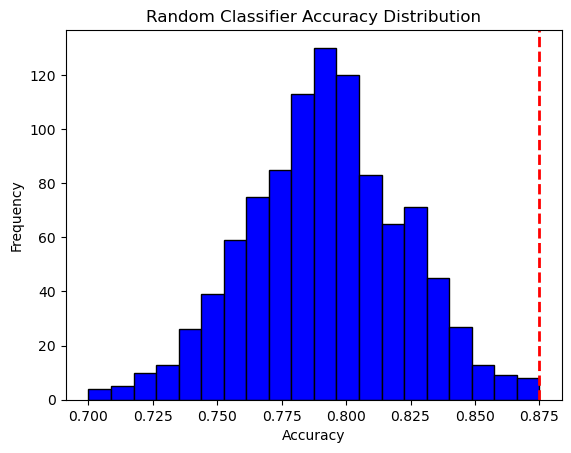

Confusion Matrix:
 [[  0  14]
 [  0 106]]
Class-specific Accuracy: [0. 1.]
(313, 41, 3)
 Test Accuracy = 85.42%, p-value = 0.0100


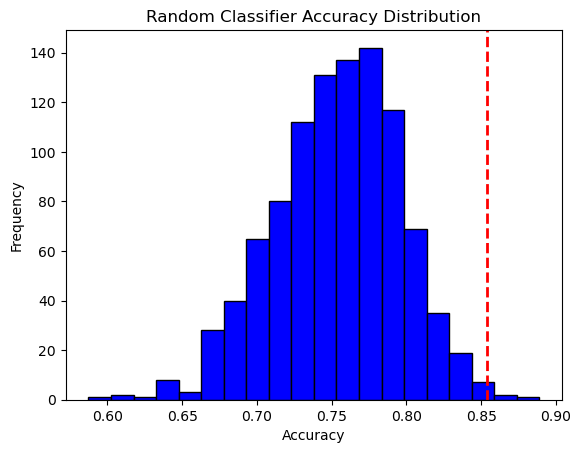

Confusion Matrix:
 [[ 0  9]
 [ 2 52]]
Class-specific Accuracy: [0.         0.96296296]
(264, 41, 3)
 Test Accuracy = 77.08%, p-value = 0.0000


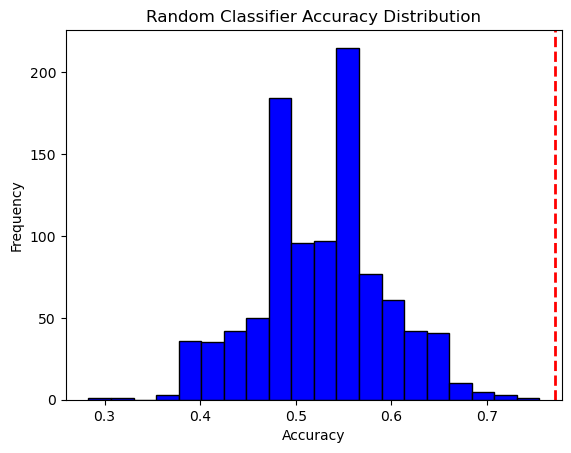

Confusion Matrix:
 [[17  3]
 [ 9 24]]
Class-specific Accuracy: [0.85       0.72727273]
(510, 41, 3)
 Test Accuracy = 76.04%, p-value = 0.0010


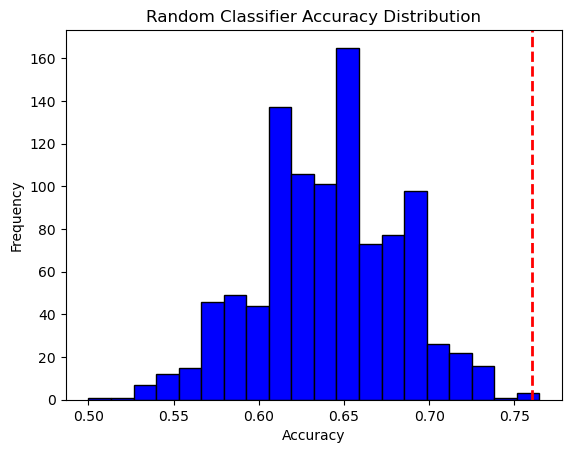

Confusion Matrix:
 [[ 0 24]
 [ 2 76]]
Class-specific Accuracy: [0.         0.97435897]
(251, 41, 3)
 Test Accuracy = 75.00%, p-value = 0.0520


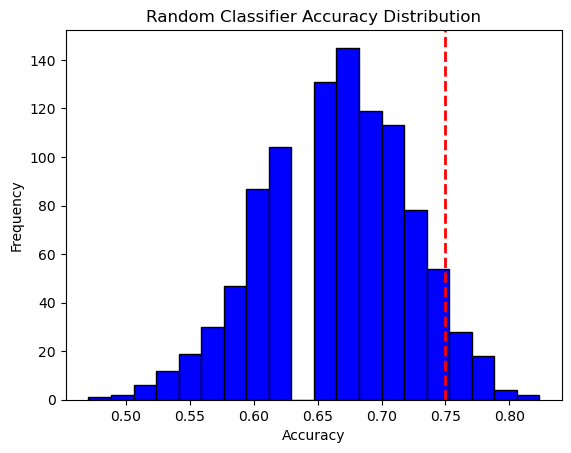

Confusion Matrix:
 [[ 0 11]
 [ 2 38]]
Class-specific Accuracy: [0.   0.95]
(328, 41, 3)
 Test Accuracy = 89.06%, p-value = 0.0000


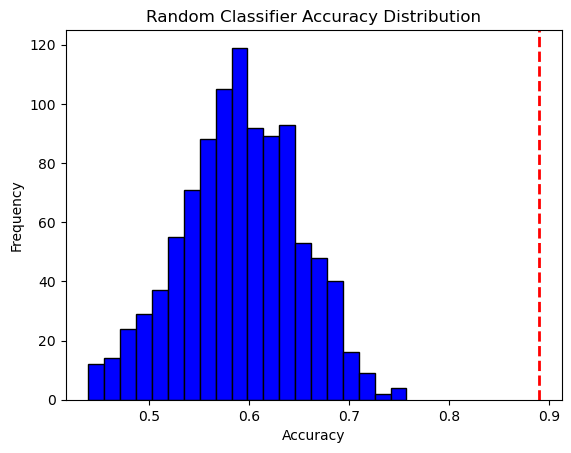

Confusion Matrix:
 [[14  5]
 [ 3 44]]
Class-specific Accuracy: [0.73684211 0.93617021]
Brain Area: S1naive, Analysis Type: GO
(249, 41, 3)
 Test Accuracy = 50.00%, p-value = 0.5970


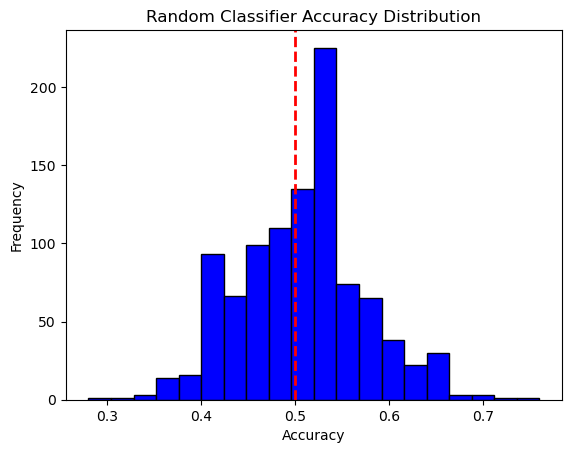

Confusion Matrix:
 [[11 11]
 [13 15]]
Class-specific Accuracy: [0.5        0.53571429]
(249, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.2090


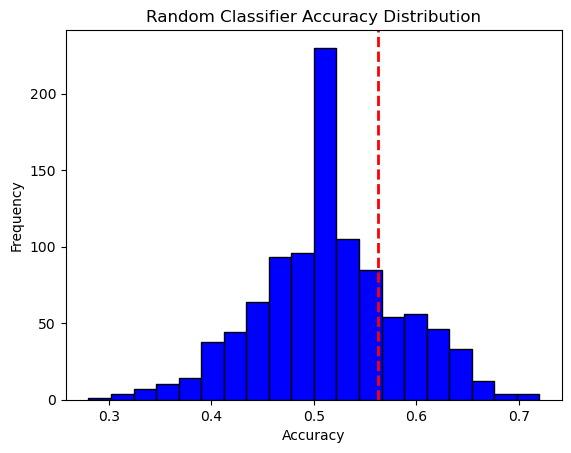

Confusion Matrix:
 [[12  9]
 [12 17]]
Class-specific Accuracy: [0.57142857 0.5862069 ]
(317, 41, 3)
 Test Accuracy = 39.06%, p-value = 0.9720


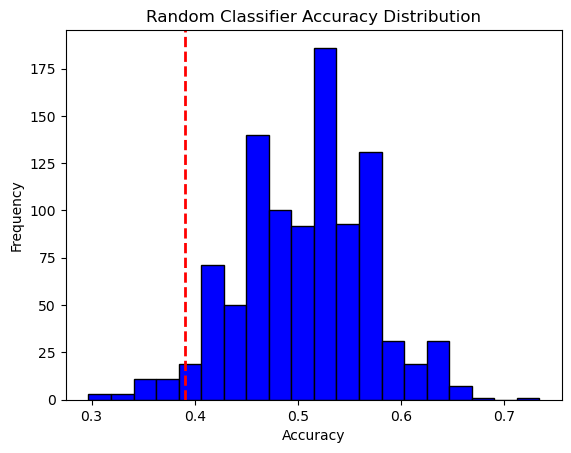

Confusion Matrix:
 [[ 9 20]
 [19 16]]
Class-specific Accuracy: [0.31034483 0.45714286]
(317, 41, 3)
 Test Accuracy = 48.44%, p-value = 0.6560


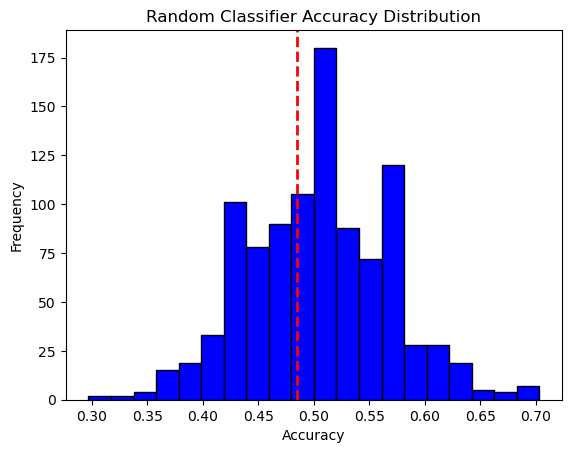

Confusion Matrix:
 [[16 18]
 [15 15]]
Class-specific Accuracy: [0.47058824 0.5       ]
(247, 41, 3)
 Test Accuracy = 60.42%, p-value = 0.0520


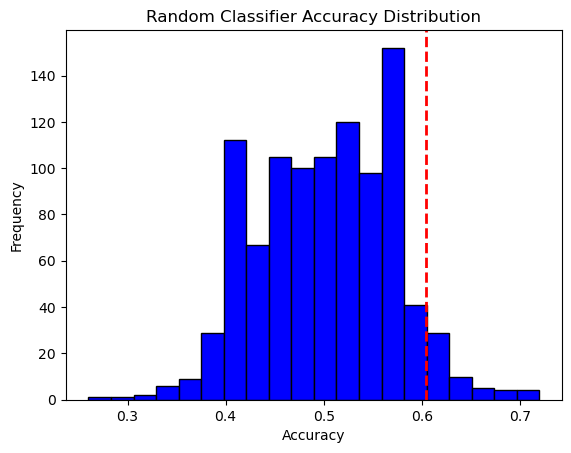

Confusion Matrix:
 [[15 10]
 [10 15]]
Class-specific Accuracy: [0.6 0.6]
(234, 41, 3)
 Test Accuracy = 46.88%, p-value = 0.6510


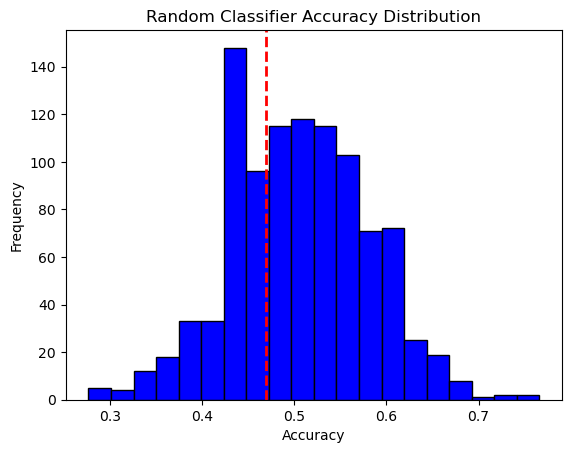

Confusion Matrix:
 [[17  8]
 [15  7]]
Class-specific Accuracy: [0.68       0.31818182]
(212, 41, 3)
 Test Accuracy = 46.88%, p-value = 0.6940


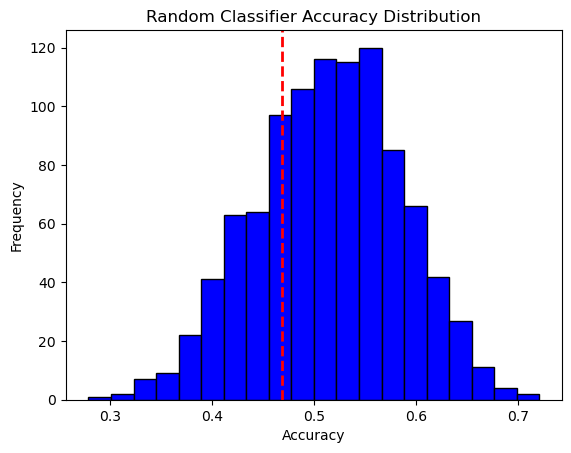

Confusion Matrix:
 [[12  6]
 [16  9]]
Class-specific Accuracy: [0.66666667 0.36      ]
(250, 41, 3)
 Test Accuracy = 58.33%, p-value = 0.1110


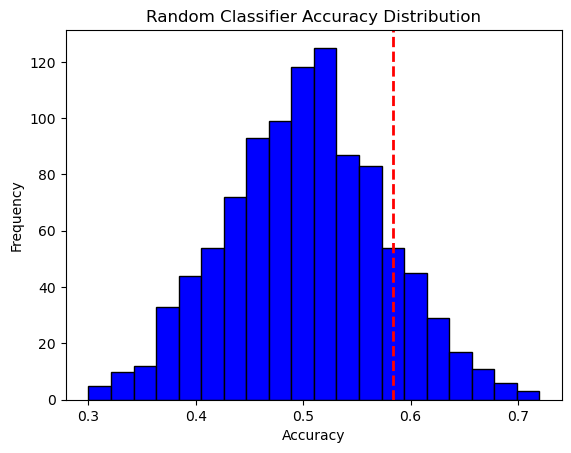

Confusion Matrix:
 [[19  7]
 [14 10]]
Class-specific Accuracy: [0.73076923 0.41666667]
(258, 41, 3)
 Test Accuracy = 33.33%, p-value = 0.9960


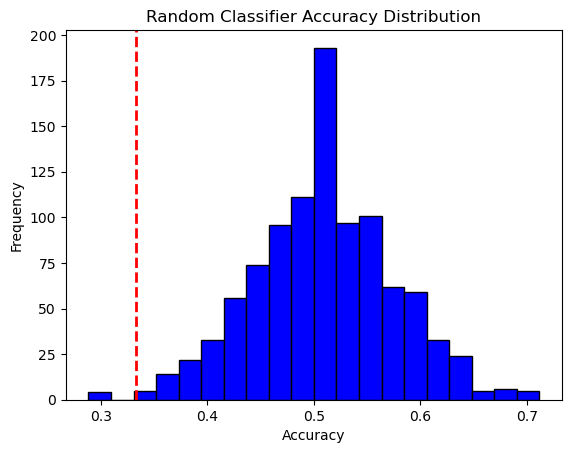

Confusion Matrix:
 [[13 16]
 [16  7]]
Class-specific Accuracy: [0.44827586 0.30434783]
(258, 41, 3)
 Test Accuracy = 47.92%, p-value = 0.6920


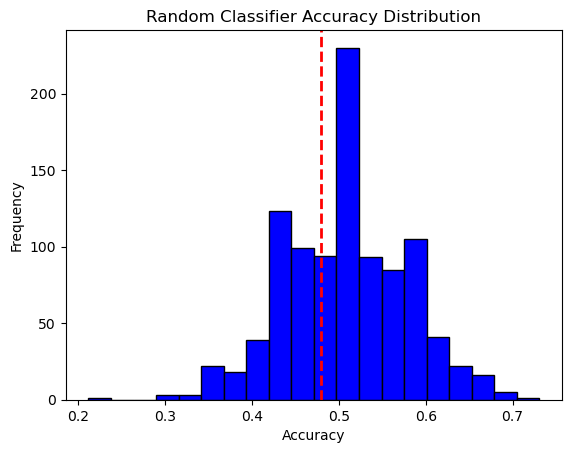

Confusion Matrix:
 [[12 17]
 [12 11]]
Class-specific Accuracy: [0.4137931  0.47826087]
(198, 41, 3)
 Test Accuracy = 43.75%, p-value = 0.8320


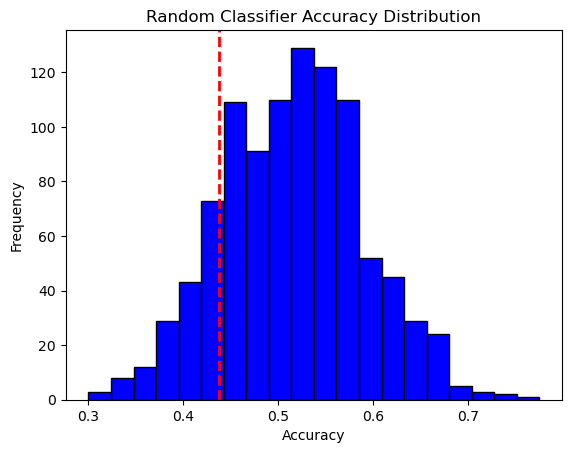

Confusion Matrix:
 [[ 9 14]
 [ 8  9]]
Class-specific Accuracy: [0.39130435 0.52941176]
(297, 41, 3)
 Test Accuracy = 54.17%, p-value = 0.3150


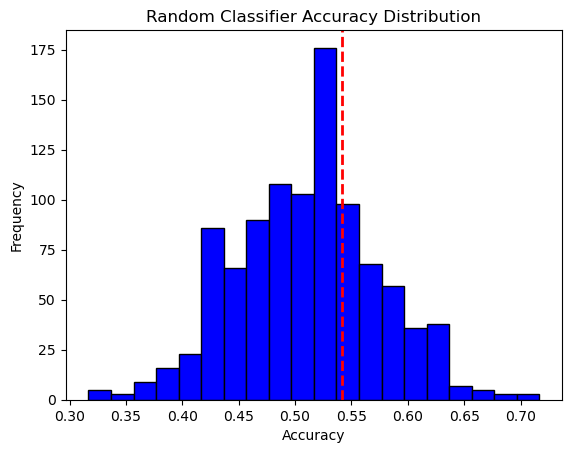

Confusion Matrix:
 [[15 11]
 [17 17]]
Class-specific Accuracy: [0.57692308 0.5       ]
(197, 41, 3)
 Test Accuracy = 53.12%, p-value = 0.6460


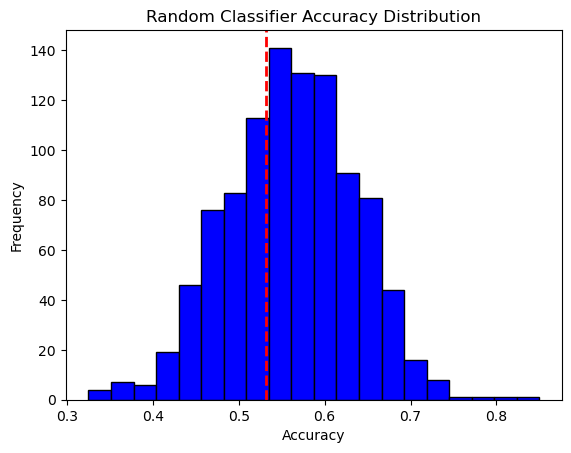

Confusion Matrix:
 [[11 16]
 [ 2 11]]
Class-specific Accuracy: [0.40740741 0.84615385]
(357, 41, 3)
 Test Accuracy = 45.31%, p-value = 0.8630


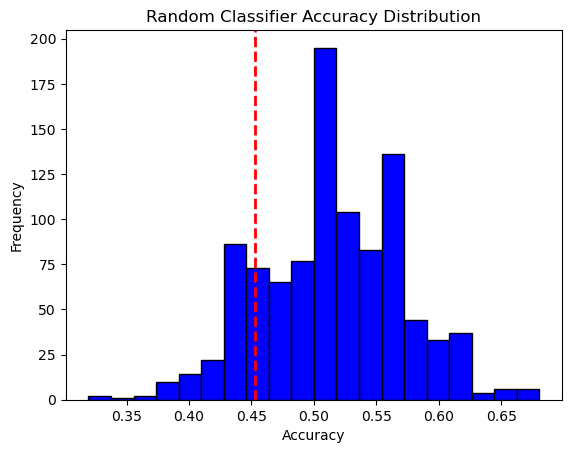

Confusion Matrix:
 [[14 28]
 [12 18]]
Class-specific Accuracy: [0.33333333 0.6       ]
Brain Area: S1naive, Analysis Type: LICK
(249, 41, 3)
 Test Accuracy = 100.00%, p-value = 1.0000


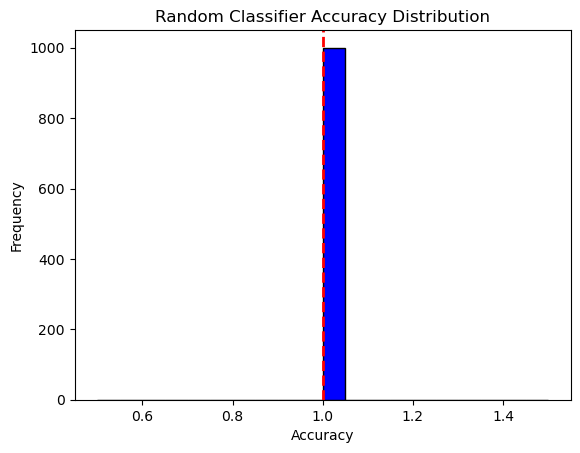

Confusion Matrix:
 [[50]]
Class-specific Accuracy: [1.]
(249, 41, 3)


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


 Test Accuracy = 100.00%, p-value = 1.0000


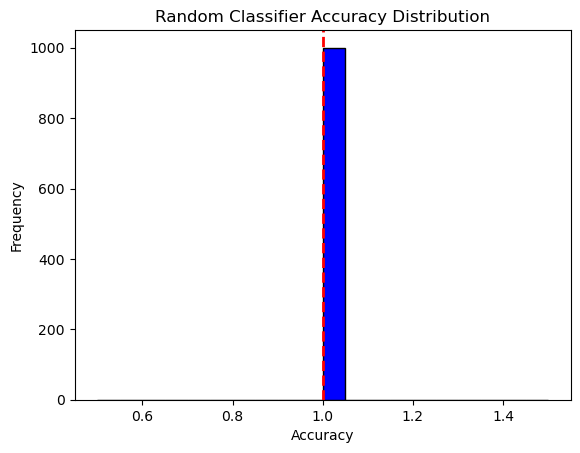

Confusion Matrix:
 [[50]]
Class-specific Accuracy: [1.]
(317, 41, 3)


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


 Test Accuracy = 62.50%, p-value = 0.0520


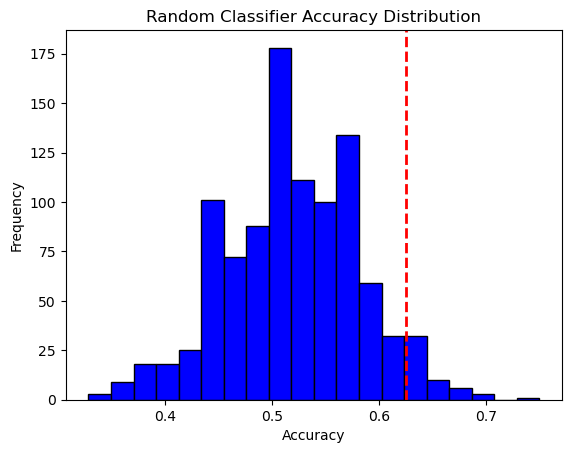

Confusion Matrix:
 [[33  5]
 [19  7]]
Class-specific Accuracy: [0.86842105 0.26923077]
(317, 41, 3)
 Test Accuracy = 76.56%, p-value = 0.0890


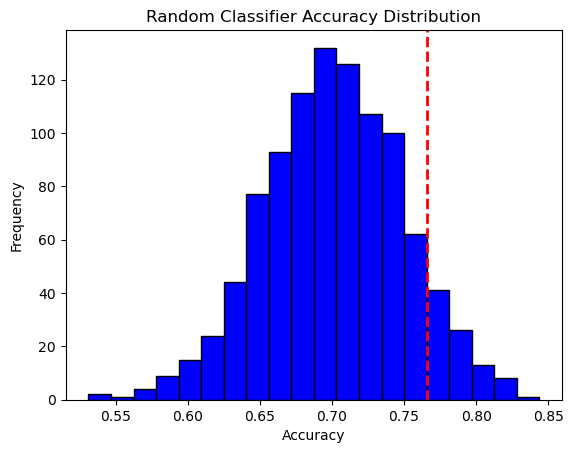

Confusion Matrix:
 [[ 2 10]
 [ 5 47]]
Class-specific Accuracy: [0.16666667 0.90384615]
(247, 41, 3)
 Test Accuracy = 100.00%, p-value = 1.0000


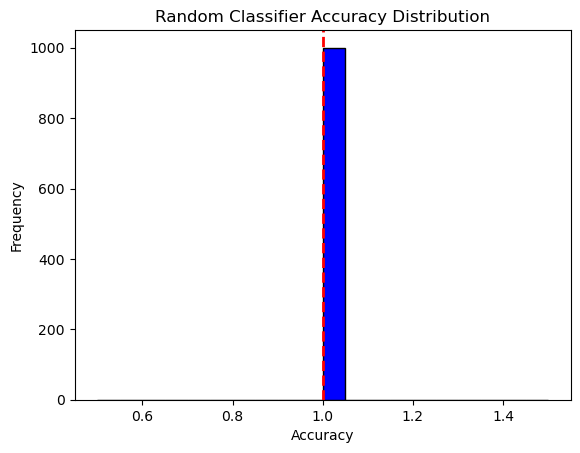

Confusion Matrix:
 [[50]]
Class-specific Accuracy: [1.]
(234, 41, 3)


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


 Test Accuracy = 75.00%, p-value = 0.0000


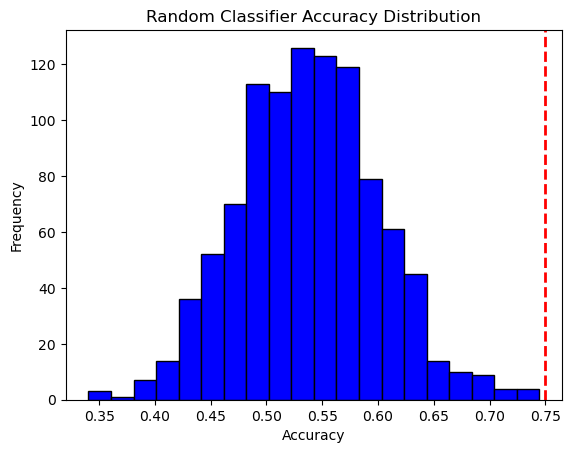

Confusion Matrix:
 [[26  4]
 [10  7]]
Class-specific Accuracy: [0.86666667 0.41176471]
(212, 41, 3)
 Test Accuracy = 71.88%, p-value = 0.0290


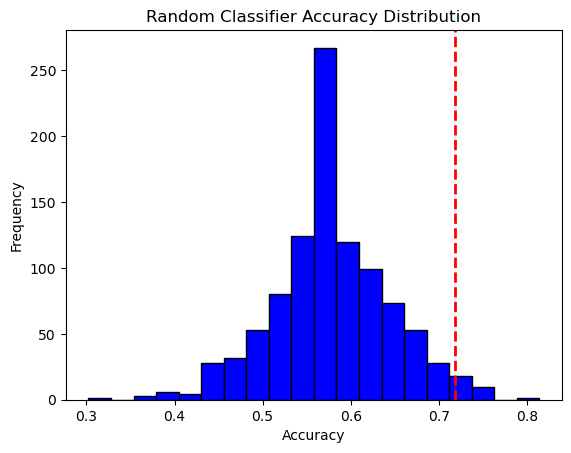

Confusion Matrix:
 [[29  1]
 [13  0]]
Class-specific Accuracy: [0.96666667 0.        ]
(250, 41, 3)
 Test Accuracy = 77.08%, p-value = 0.0040


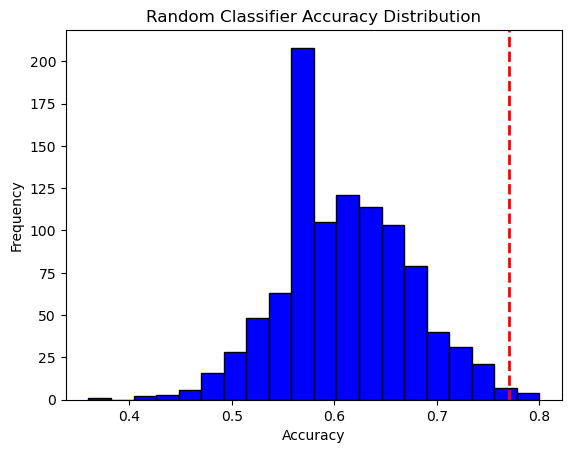

Confusion Matrix:
 [[37  0]
 [12  1]]
Class-specific Accuracy: [1.         0.07692308]
(258, 41, 3)
 Test Accuracy = 93.75%, p-value = 0.0890


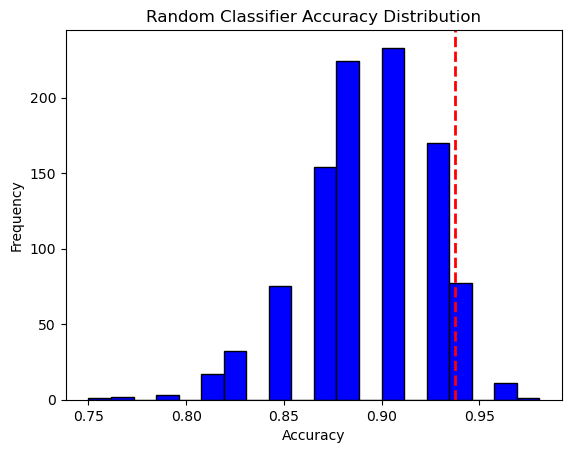

Confusion Matrix:
 [[48  1]
 [ 3  0]]
Class-specific Accuracy: [0.97959184 0.        ]
(258, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.1500


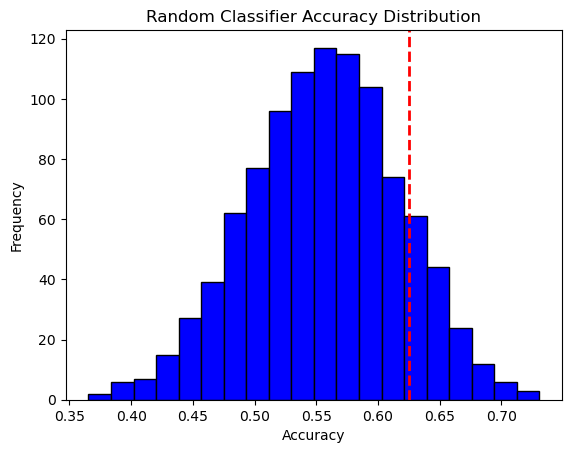

Confusion Matrix:
 [[ 3 14]
 [ 7 28]]
Class-specific Accuracy: [0.17647059 0.8       ]
(198, 41, 3)
 Test Accuracy = 100.00%, p-value = 1.0000


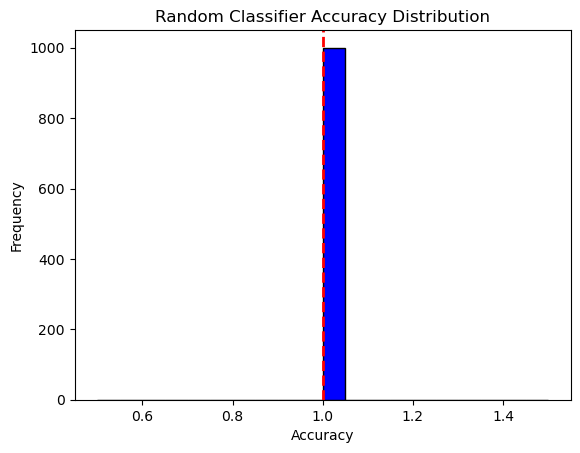

Confusion Matrix:
 [[40]]
Class-specific Accuracy: [1.]
(297, 41, 3)


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


 Test Accuracy = 75.00%, p-value = 0.0010


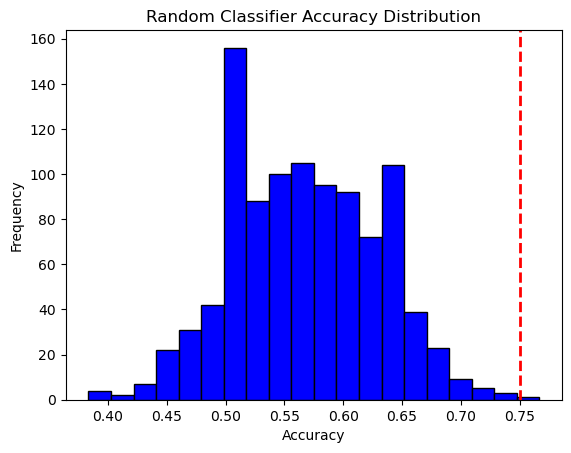

Confusion Matrix:
 [[36  5]
 [10  9]]
Class-specific Accuracy: [0.87804878 0.47368421]
(197, 41, 3)
 Test Accuracy = 71.88%, p-value = 0.1900


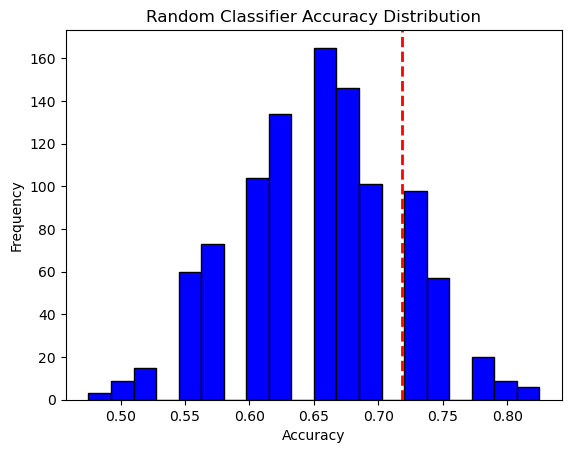

Confusion Matrix:
 [[ 0  9]
 [ 0 31]]
Class-specific Accuracy: [0. 1.]
(357, 41, 3)
 Test Accuracy = 90.62%, p-value = 0.0130


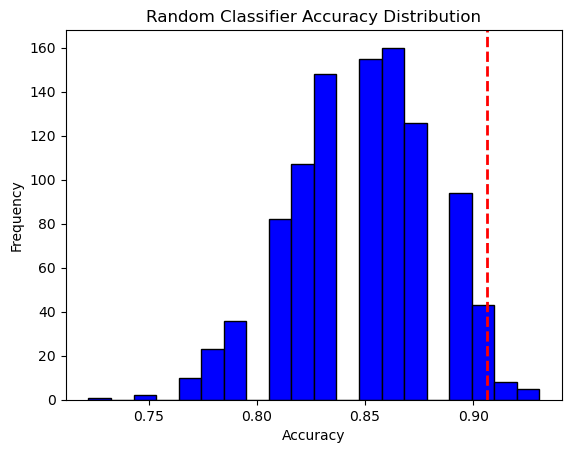

Confusion Matrix:
 [[ 1  5]
 [ 1 65]]
Class-specific Accuracy: [0.16666667 0.98484848]
Brain Area: PPC, Analysis Type: GO
(479, 41, 3)
 Test Accuracy = 53.12%, p-value = 0.2950


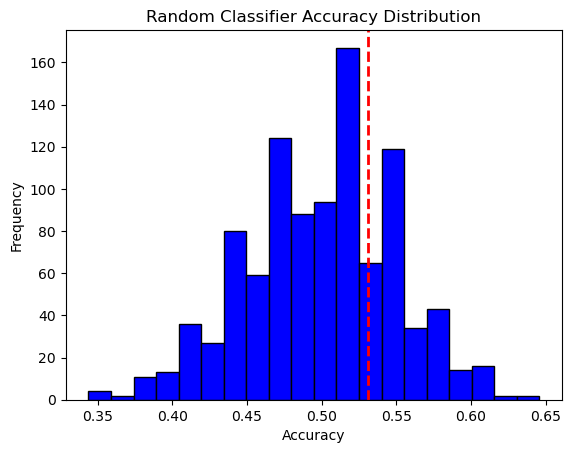

Confusion Matrix:
 [[32 13]
 [32 19]]
Class-specific Accuracy: [0.71111111 0.37254902]
(315, 41, 3)
 Test Accuracy = 50.00%, p-value = 0.5100


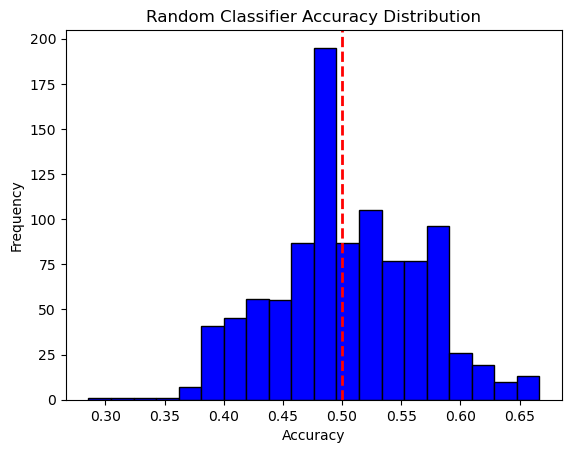

Confusion Matrix:
 [[16 17]
 [13 17]]
Class-specific Accuracy: [0.48484848 0.56666667]
(540, 41, 3)
 Test Accuracy = 41.67%, p-value = 0.9630


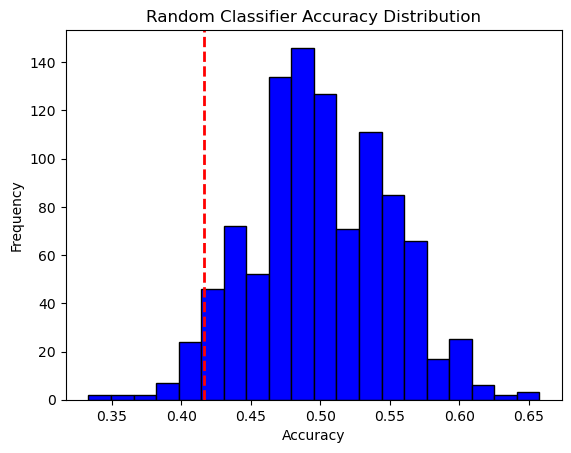

Confusion Matrix:
 [[30 24]
 [40 14]]
Class-specific Accuracy: [0.55555556 0.25925926]
(336, 41, 3)
 Test Accuracy = 48.44%, p-value = 0.6520


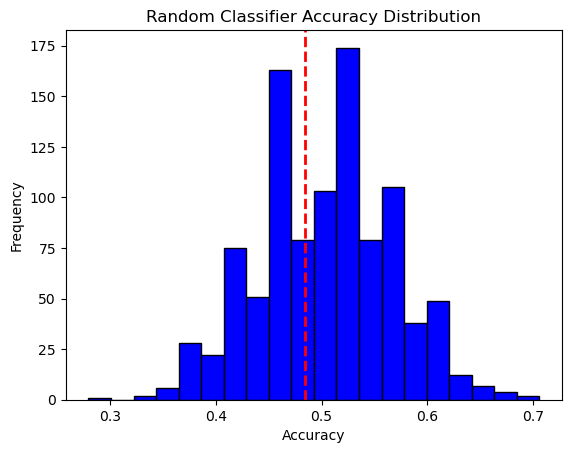

Confusion Matrix:
 [[13 18]
 [16 21]]
Class-specific Accuracy: [0.41935484 0.56756757]
(348, 41, 3)
 Test Accuracy = 42.19%, p-value = 0.9200


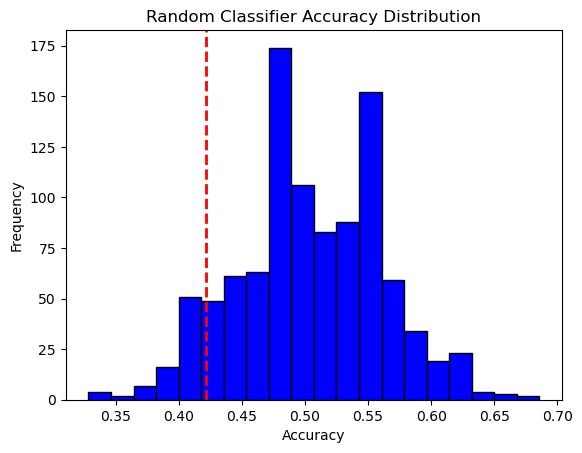

Confusion Matrix:
 [[15 22]
 [18 15]]
Class-specific Accuracy: [0.40540541 0.45454545]
(298, 41, 3)
 Test Accuracy = 54.17%, p-value = 0.3230


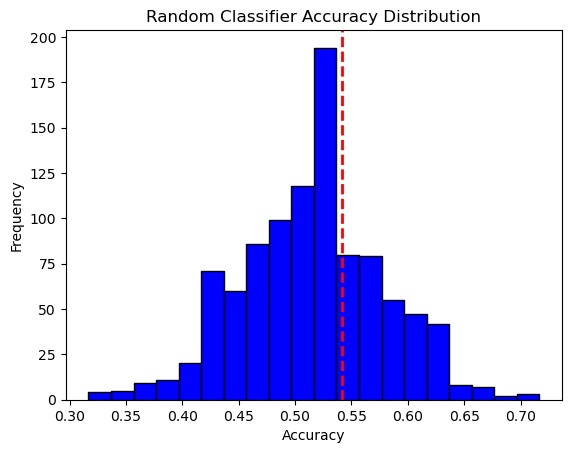

Confusion Matrix:
 [[14 21]
 [ 5 20]]
Class-specific Accuracy: [0.4 0.8]
(616, 41, 3)
 Test Accuracy = 49.11%, p-value = 0.5980


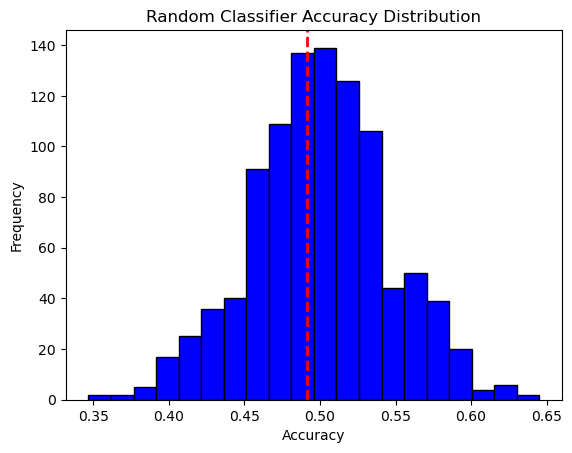

Confusion Matrix:
 [[29 36]
 [27 32]]
Class-specific Accuracy: [0.44615385 0.54237288]
(334, 41, 3)
 Test Accuracy = 60.94%, p-value = 0.0390


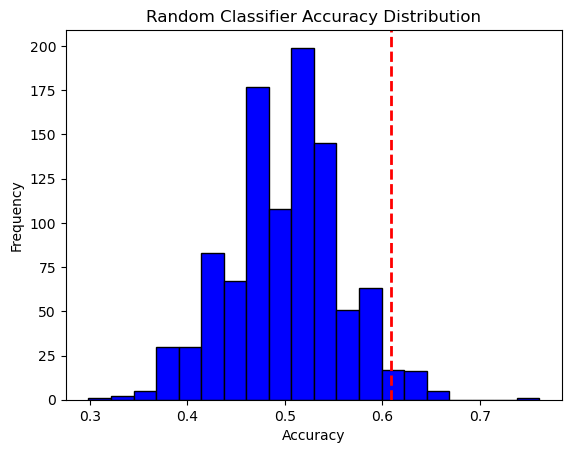

Confusion Matrix:
 [[25 10]
 [16 16]]
Class-specific Accuracy: [0.71428571 0.5       ]
(434, 41, 3)
 Test Accuracy = 51.25%, p-value = 0.4270


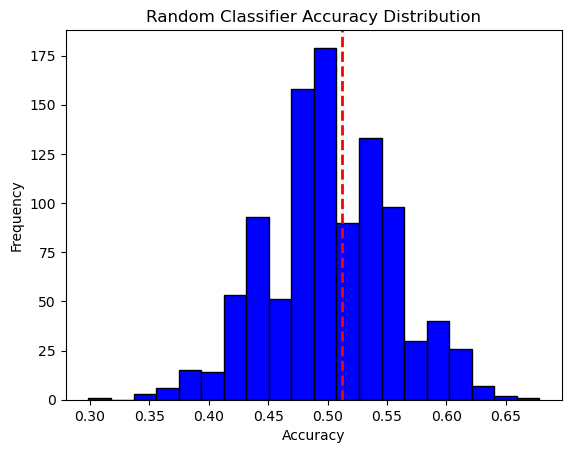

Confusion Matrix:
 [[15 27]
 [16 29]]
Class-specific Accuracy: [0.35714286 0.64444444]
(331, 41, 3)
 Test Accuracy = 53.12%, p-value = 0.3300


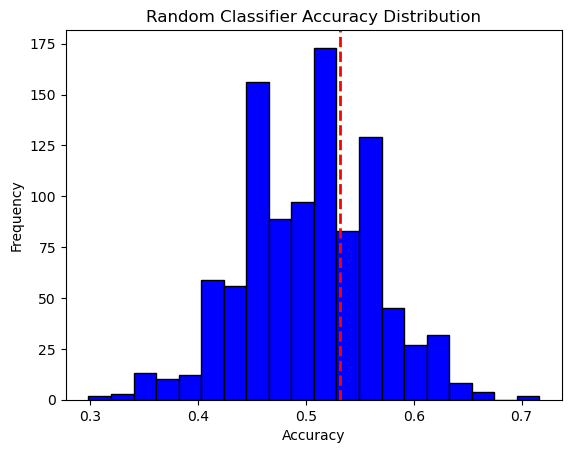

Confusion Matrix:
 [[23  8]
 [22 14]]
Class-specific Accuracy: [0.74193548 0.38888889]
(237, 41, 3)
 Test Accuracy = 45.83%, p-value = 0.6690


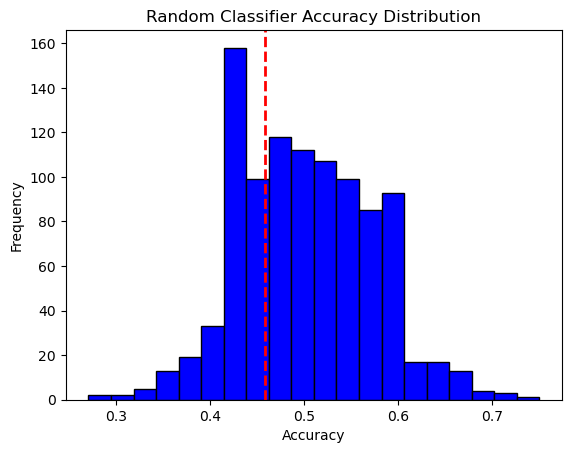

Confusion Matrix:
 [[ 8 17]
 [ 9 14]]
Class-specific Accuracy: [0.32       0.60869565]
(506, 41, 3)
 Test Accuracy = 41.67%, p-value = 0.9650


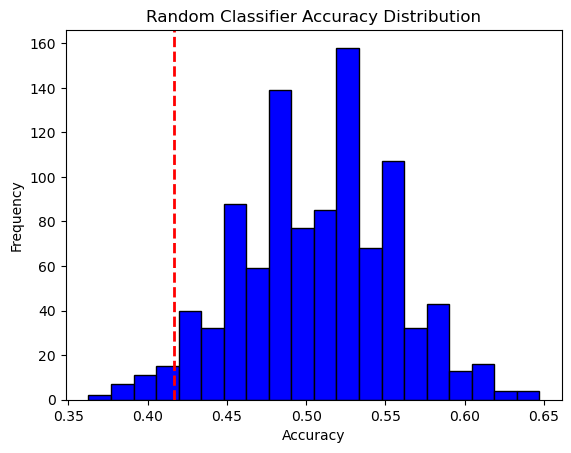

Confusion Matrix:
 [[30 27]
 [31 14]]
Class-specific Accuracy: [0.52631579 0.31111111]
(125, 41, 3)
 Test Accuracy = 37.50%, p-value = 0.9150


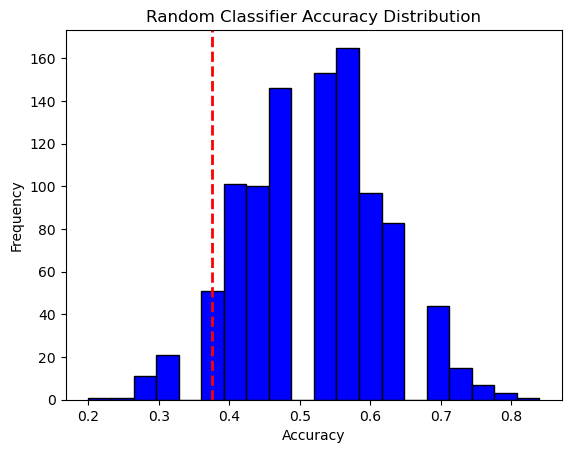

Confusion Matrix:
 [[6 5]
 [9 5]]
Class-specific Accuracy: [0.54545455 0.35714286]
(343, 41, 3)
 Test Accuracy = 54.69%, p-value = 0.2400


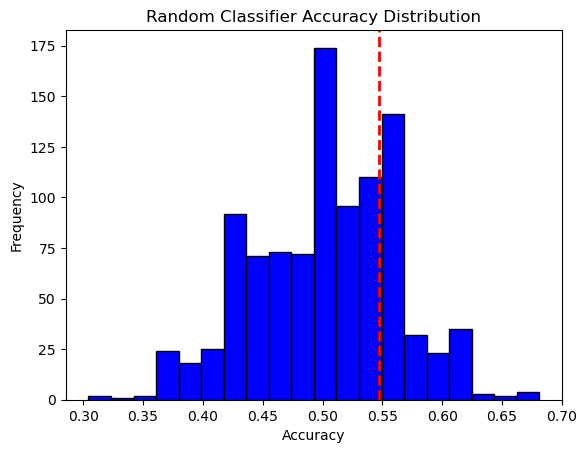

Confusion Matrix:
 [[24  8]
 [23 14]]
Class-specific Accuracy: [0.75       0.37837838]
(436, 41, 3)
 Test Accuracy = 42.50%, p-value = 0.9290


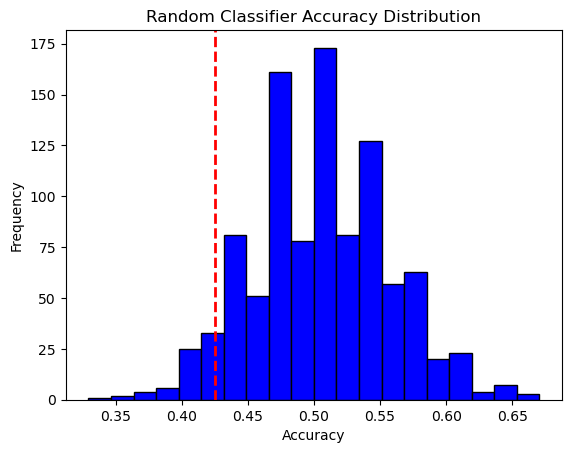

Confusion Matrix:
 [[18 23]
 [28 19]]
Class-specific Accuracy: [0.43902439 0.40425532]
(281, 41, 3)
 Test Accuracy = 64.58%, p-value = 0.0210


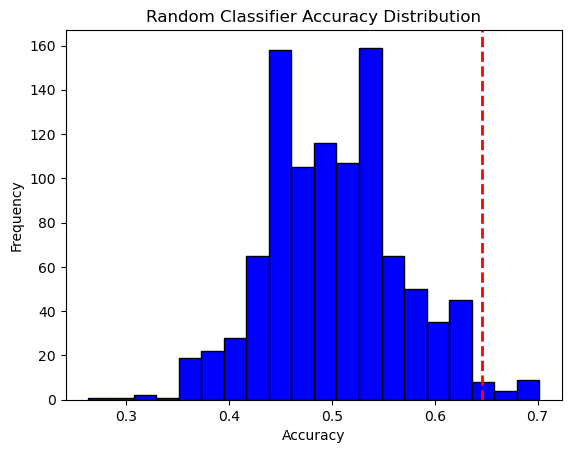

Confusion Matrix:
 [[16 13]
 [ 9 19]]
Class-specific Accuracy: [0.55172414 0.67857143]
Brain Area: PPC, Analysis Type: LICK
(479, 41, 3)
 Test Accuracy = 86.46%, p-value = 0.0030


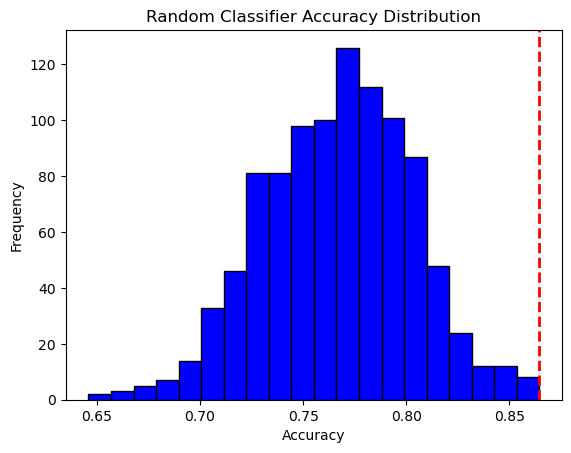

Confusion Matrix:
 [[ 0 13]
 [ 0 83]]
Class-specific Accuracy: [0. 1.]
(315, 41, 3)
 Test Accuracy = 89.58%, p-value = 0.0200


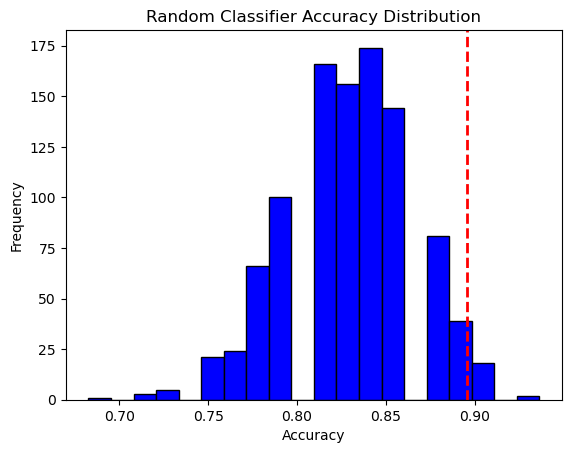

Confusion Matrix:
 [[ 0  6]
 [ 0 57]]
Class-specific Accuracy: [0. 1.]
(540, 41, 3)
 Test Accuracy = 77.08%, p-value = 0.0010


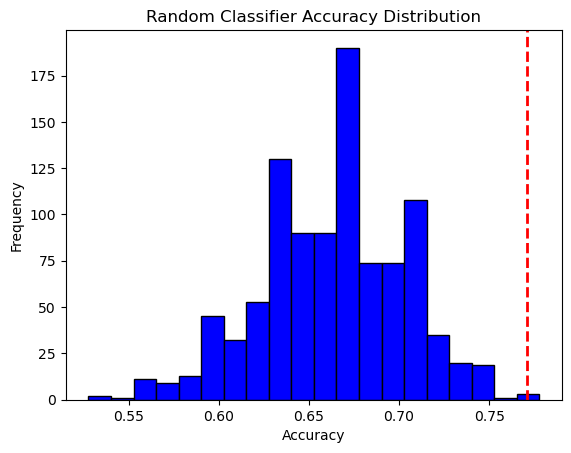

Confusion Matrix:
 [[ 1 22]
 [ 4 81]]
Class-specific Accuracy: [0.04347826 0.95294118]
(336, 41, 3)
 Test Accuracy = 90.62%, p-value = 0.0010


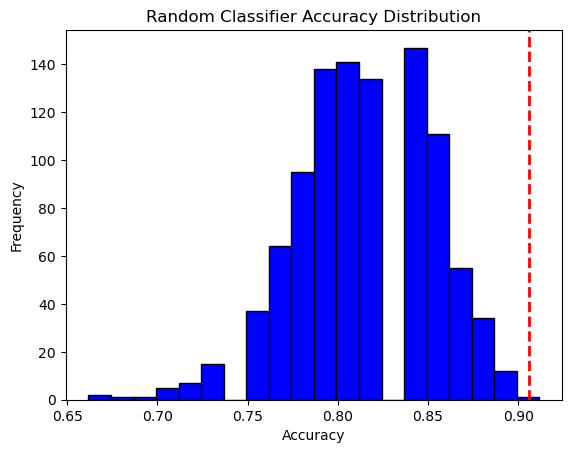

Confusion Matrix:
 [[ 0  7]
 [ 0 61]]
Class-specific Accuracy: [0. 1.]
(348, 41, 3)
 Test Accuracy = 65.62%, p-value = 0.0540


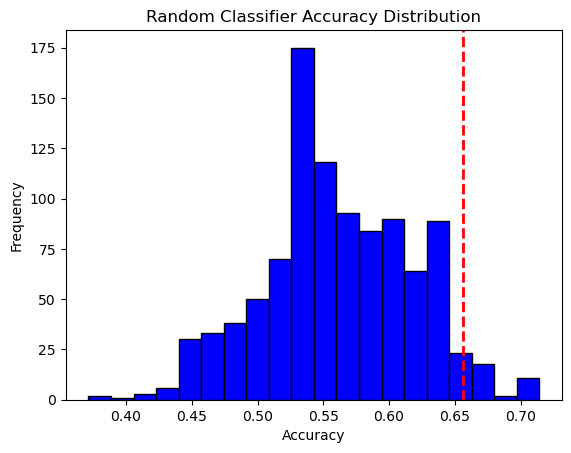

Confusion Matrix:
 [[ 1 22]
 [ 2 45]]
Class-specific Accuracy: [0.04347826 0.95744681]
(298, 41, 3)
 Test Accuracy = 89.58%, p-value = 0.0170


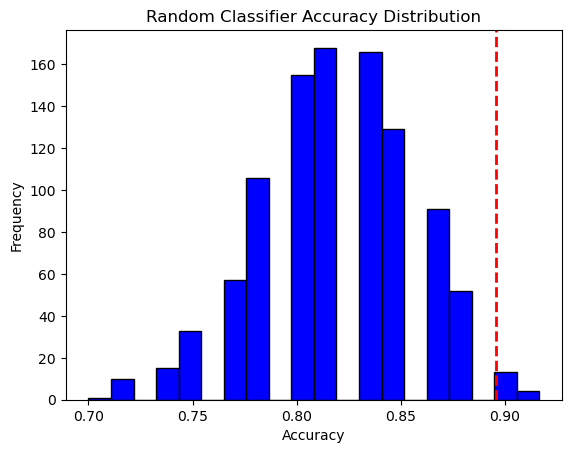

Confusion Matrix:
 [[ 0  6]
 [ 0 54]]
Class-specific Accuracy: [0. 1.]
(616, 41, 3)
 Test Accuracy = 85.71%, p-value = 0.0000


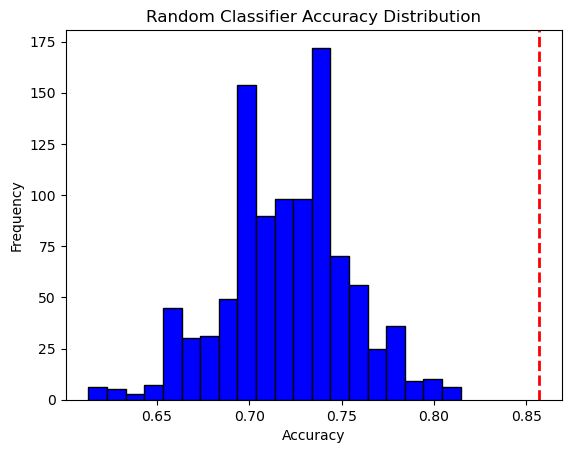

Confusion Matrix:
 [[  0  21]
 [  0 103]]
Class-specific Accuracy: [0. 1.]
(334, 41, 3)
 Test Accuracy = 98.44%, p-value = 1.0000


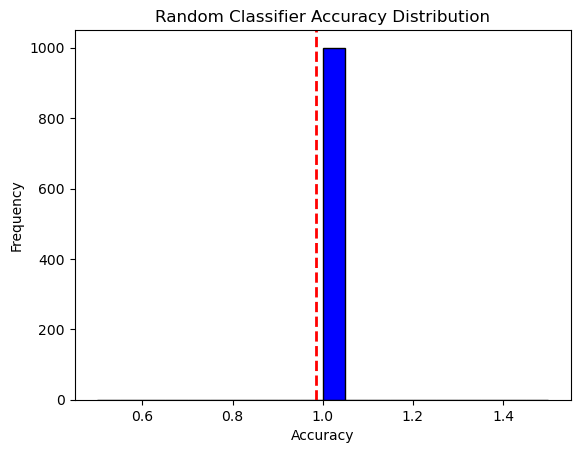

Confusion Matrix:
 [[ 0  0]
 [ 1 66]]
Class-specific Accuracy: [       nan 0.98507463]
(434, 41, 3)


/tmp/ipykernel_826/164613227.py:174: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)


 Test Accuracy = 87.50%, p-value = 0.0020


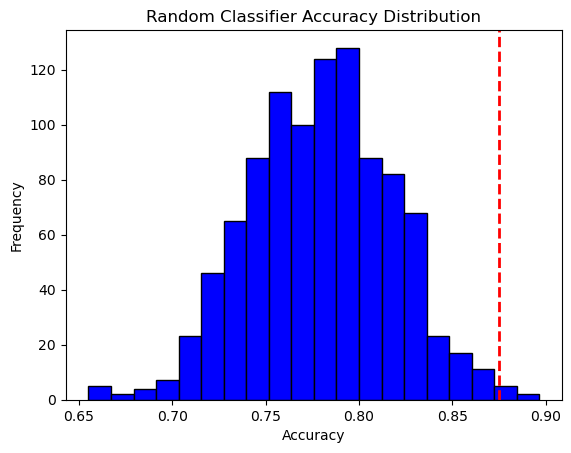

Confusion Matrix:
 [[ 0 11]
 [ 0 76]]
Class-specific Accuracy: [0. 1.]
(331, 41, 3)
 Test Accuracy = 92.19%, p-value = 0.0290


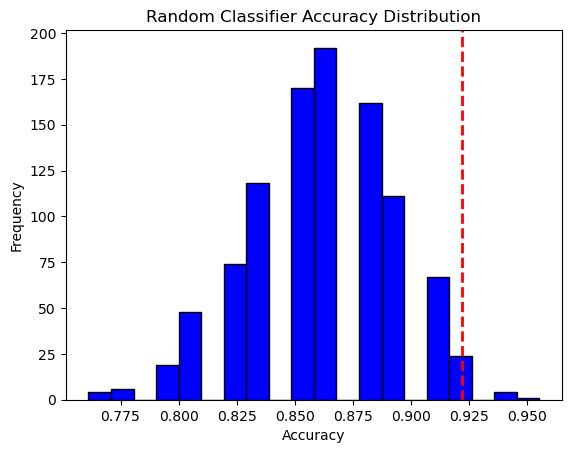

Confusion Matrix:
 [[ 0  5]
 [ 0 62]]
Class-specific Accuracy: [0. 1.]
(237, 41, 3)
 Test Accuracy = 95.83%, p-value = 0.1580


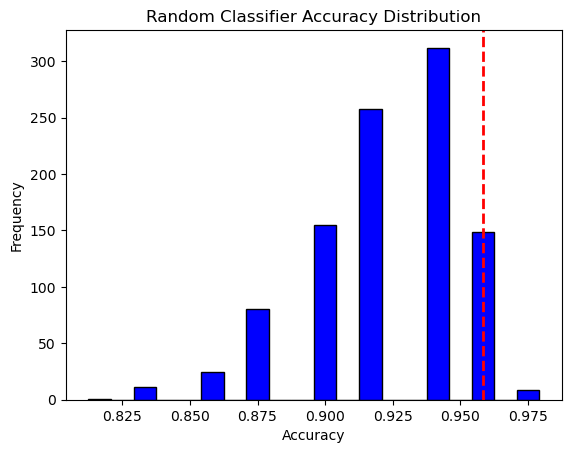

Confusion Matrix:
 [[ 0  2]
 [ 0 46]]
Class-specific Accuracy: [0. 1.]
(506, 41, 3)
 Test Accuracy = 97.92%, p-value = 0.1550


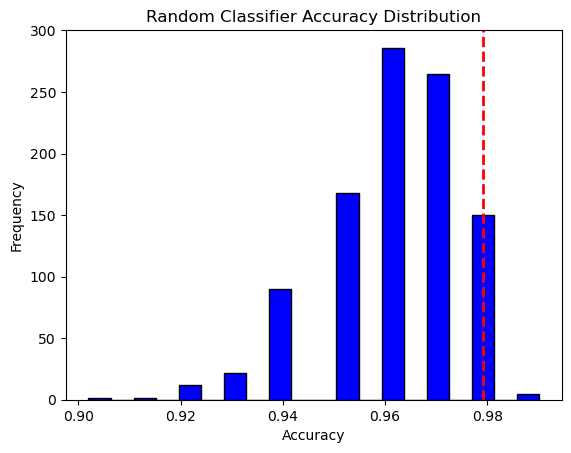

Confusion Matrix:
 [[  0   2]
 [  0 100]]
Class-specific Accuracy: [0. 1.]
(125, 41, 3)
 Test Accuracy = 93.75%, p-value = 0.4020


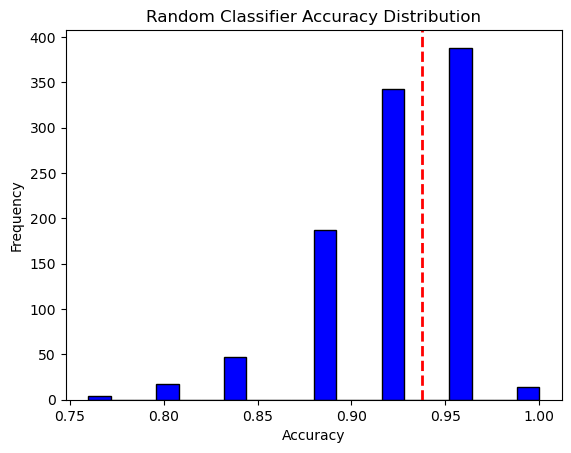

Confusion Matrix:
 [[ 0  1]
 [ 0 24]]
Class-specific Accuracy: [0. 1.]
(343, 41, 3)
 Test Accuracy = 93.75%, p-value = 0.0400


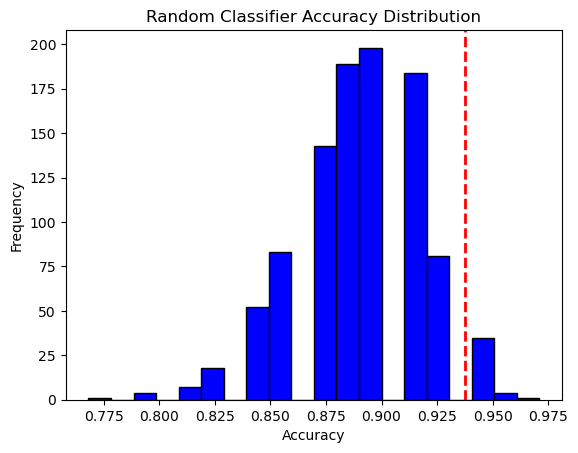

Confusion Matrix:
 [[ 0  4]
 [ 0 65]]
Class-specific Accuracy: [0. 1.]
(436, 41, 3)
 Test Accuracy = 100.00%, p-value = 1.0000


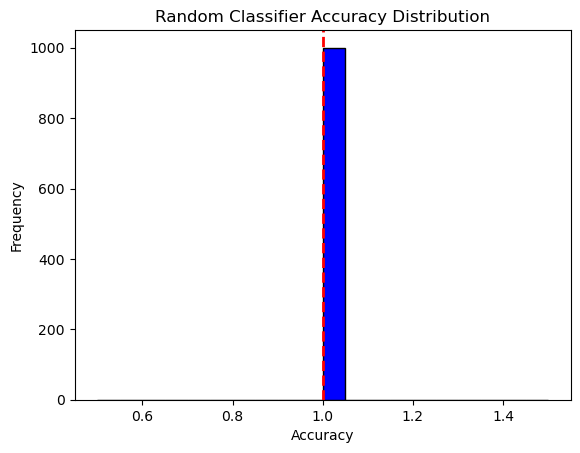

Confusion Matrix:
 [[88]]
Class-specific Accuracy: [1.]
(281, 41, 3)


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


 Test Accuracy = 100.00%, p-value = 1.0000


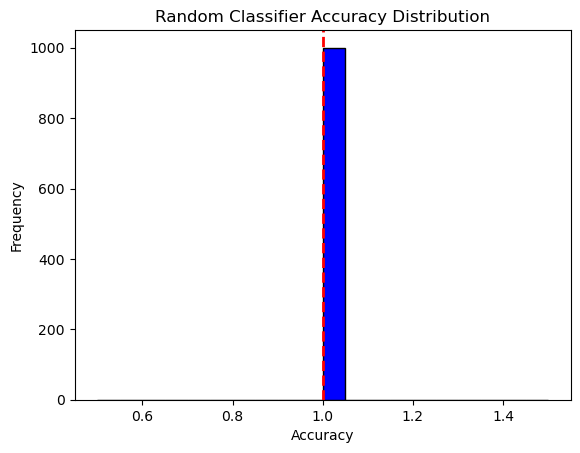

Confusion Matrix:
 [[57]]
Class-specific Accuracy: [1.]


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [80]:
##pop RNN
### gonna use SMOTE and skip sessions with too much of an imbalance 
# Number of random classifiers (null hypothesis testing)


num_permutations = 1000

# Brain areas and analysis types
results_population = []
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["GO", "LICK"]

# Define combinations
combinations = [('S1', 'GO'), ('S1', 'LICK'), ('S1naive', 'GO'), ('S1naive', 'LICK'), ('PPC', 'GO'), ('PPC', 'LICK')]


# Iterate through each combination
for comb in combinations:
    brain_area = comb[0]
    analysis_type = comb[1]
    print(f"Brain Area: {brain_area}, Analysis Type: {analysis_type}")
    # Containers for all data across sessions

    # Load data
    trial_list, trial_dff = get_pop_data_ready(brain_area, analysis_type)

    # Perform PCA
    pca_result_df, session_trial_ids = process_trials_for_pca(trial_list, trial_dff, n_components=3)
    sessions= np.unique(pca_result_df['session'])
    
    #### run a loop per session 

    for session in sessions:
        #select the session specific data:
        mask=pca_result_df['session']==session
        all_session_X=pca_result_df[mask]
        all_X=all_session_X['pca_result']#get the PCA result from the session
        new_X=[]
        for trial in all_X:
           new_X.append(np.array(trial))
        new_X=np.array(new_X)
        X=np.transpose(new_X,(0,1,2))
        print(X.shape)
        #now select the session specific y
        indices = pca_result_df.index[pca_result_df['session'] == session].tolist()
        selected_trials = [session_trial_ids[i] for i in indices]
        all_session_y=selected_trials
        all_y=np.array(all_session_y)# Corresponding trial IDs (labels)
        
        X_train, X_test, y_train, y_test = train_test_split(X, all_y, test_size=0.2, random_state=42)
        
       
         # Convert to PyTorch tensors
        Xtrain = torch.from_numpy(X_train).float()
        ytrain = torch.from_numpy(y_train).long()
        Xtest = torch.from_numpy(X_test).float()
        ytest = torch.from_numpy(y_test).long()
    
            # Prepare DataLoader
        batch_size = 16
        n_iters = 1000
        num_epochs = int(n_iters // (len(X_train) // batch_size))
    
        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
    
            # Create the RNN model
        input_dim = X.shape[-1]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1
    
        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    
            # Loss function and optimizer
        error = nn.BCEWithLogitsLoss()  # No class weights, since oversampling handles imbalance
        learning_rate = 0.01
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
        # Training loop for the original model
        train_accuracy_list = []
        test_accuracy_list = []
        test_loss_list = []
    
        for epoch in range(num_epochs):
            model.train()
            total_train, correct_train = 0, 0
    
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()
                loss = error(outputs, y_batch.float())
                loss.backward()
                optimizer.step()
    
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).long()
                correct_train += (predicted.squeeze() == y_batch).sum().item()
                total_train += y_batch.size(0)
    
            train_accuracy = 100 * correct_train / total_train
            train_accuracy_list.append(train_accuracy)
            scheduler.step()
    
            # Evaluate on test set
            model.eval()
            total_test, correct_test = 0, 0
            with torch.no_grad():
                 for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch).squeeze()
                    probabilities = torch.sigmoid(outputs)
                    predicted = (probabilities > 0.5).long()
                    correct_test += (predicted == y_test_batch).sum().item()
                    total_test += y_test_batch.size(0)
                    loss_test = error(outputs, y_test_batch.float())
                    test_loss_list.append(loss_test)
    
            test_accuracy = 100 * correct_test / float(total_test)
            test_accuracy_list.append(test_accuracy)
    
            # Save the original model's test accuracy
        original_test_accuracy = test_accuracy
    
            # Random classifier: Match class distribution in the test set
        class_distribution = np.mean(y_test)  # proportion of class 1
    
        random_accuracies = []
        for _ in range(num_permutations):
            y_random = np.random.choice([0, 1], size=len(y_test), p=[1 - class_distribution, class_distribution])
            random_accuracy = accuracy_score(y_test, y_random)
            random_accuracies.append(random_accuracy)
    
            # Calculate p-value using a t-test (testing original model vs. random classifiers)
        random_accuracies = np.array(random_accuracies)
        p_value = np.mean(random_accuracies >= original_test_accuracy/100)
    
            # Store results
        results_population.append({
            'Session': session,
            'Brain Area': brain_area,
            'Analysis Type': type_of_analysis,
            'Train Accuracy': train_accuracy_list,
            'Test Accuracy': original_test_accuracy,
            'p value': p_value
            })
    
        print(f" Test Accuracy = {original_test_accuracy:.2f}%, p-value = {p_value:.4f}")
    
        # Visualize random classifier accuracy distribution
        plt.hist(random_accuracies, bins=20, color='blue', edgecolor='black')
        plt.axvline(original_test_accuracy/100, color='red', linestyle='dashed', linewidth=2)
        plt.title(f'Random Classifier Accuracy Distribution')
        plt.xlabel('Accuracy')
        plt.ylabel('Frequency')
        plt.show()
    
     
      # Check class-specific accuracy on the test set
            
        # Predict on the test set and calculate confusion matrix
        model.eval()
        with torch.no_grad():
            outputs = model(Xtest).squeeze()
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).long()
                
        conf_matrix = confusion_matrix(ytest, predictions)
        print("Confusion Matrix:\n", conf_matrix)
            
            # Calculate class-specific accuracy
        class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        print("Class-specific Accuracy:", class_accuracy)


Brain Area: S1, Analysis Type: GO
(231, 41, 3)
 Test Accuracy = 54.17%, p-value = 0.2400


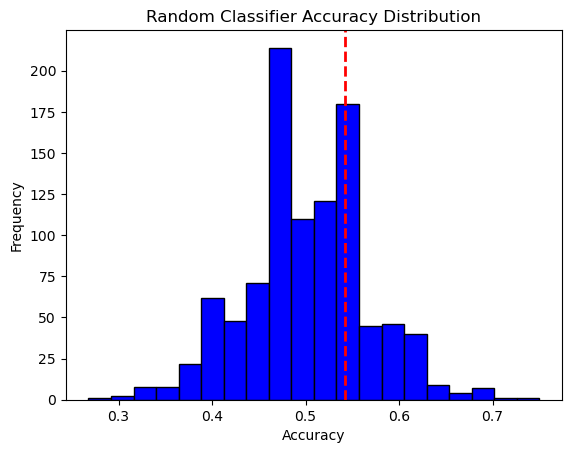

Confusion Matrix:
 [[14 13]
 [12 17]]
Class-specific Accuracy: [0.51851852 0.5862069 ]
(122, 41, 3)
 Test Accuracy = 71.88%, p-value = 0.0080


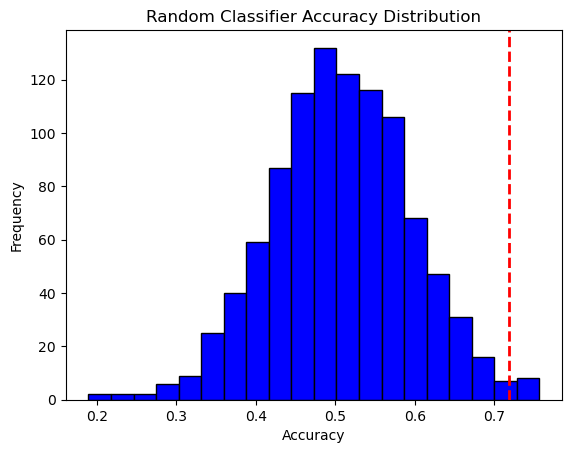

Confusion Matrix:
 [[16  4]
 [ 6 11]]
Class-specific Accuracy: [0.8        0.64705882]
(403, 41, 3)
 Test Accuracy = 55.00%, p-value = 0.2090


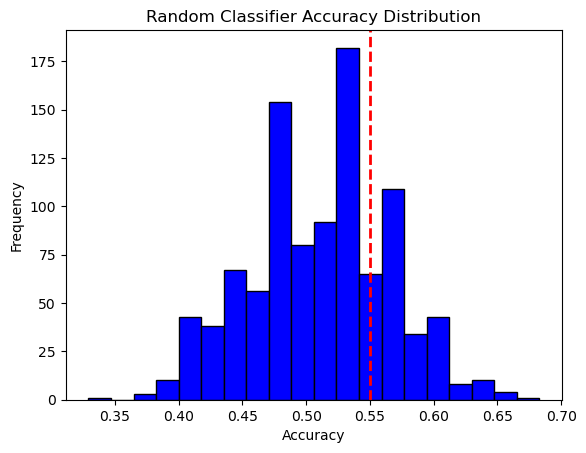

Confusion Matrix:
 [[21 26]
 [12 23]]
Class-specific Accuracy: [0.44680851 0.65714286]
(233, 41, 3)
 Test Accuracy = 52.08%, p-value = 0.4000


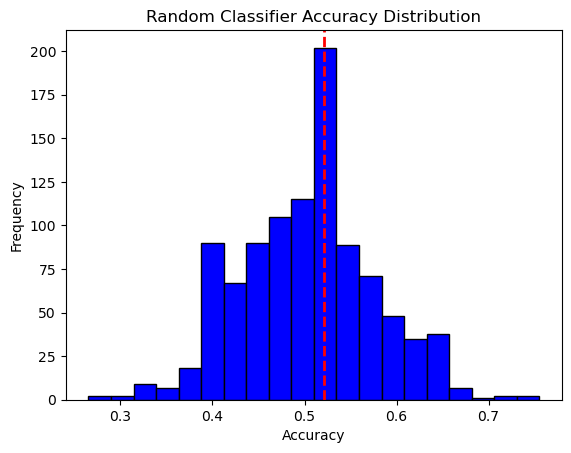

Confusion Matrix:
 [[14 12]
 [11 12]]
Class-specific Accuracy: [0.53846154 0.52173913]
(529, 41, 3)
 Test Accuracy = 50.00%, p-value = 0.5800


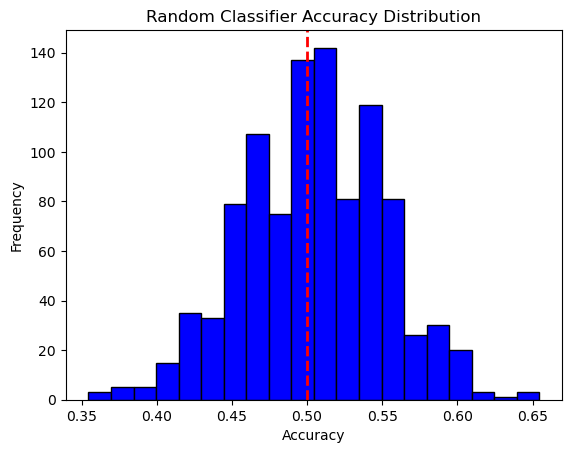

Confusion Matrix:
 [[28 32]
 [23 27]]
Class-specific Accuracy: [0.46666667 0.54      ]
(410, 41, 3)
 Test Accuracy = 50.00%, p-value = 0.5740


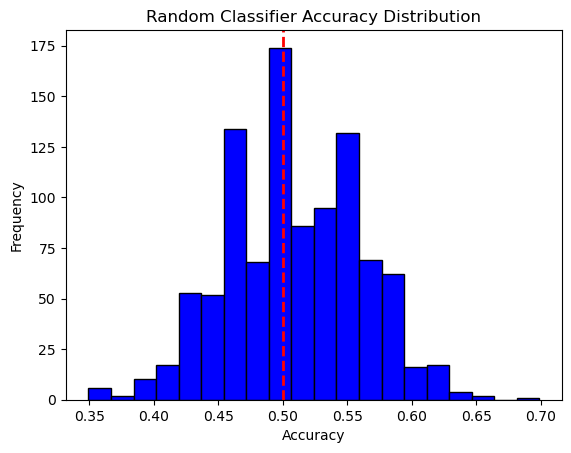

Confusion Matrix:
 [[24 23]
 [18 18]]
Class-specific Accuracy: [0.5106383 0.5      ]
(429, 41, 3)
 Test Accuracy = 51.04%, p-value = 0.4650


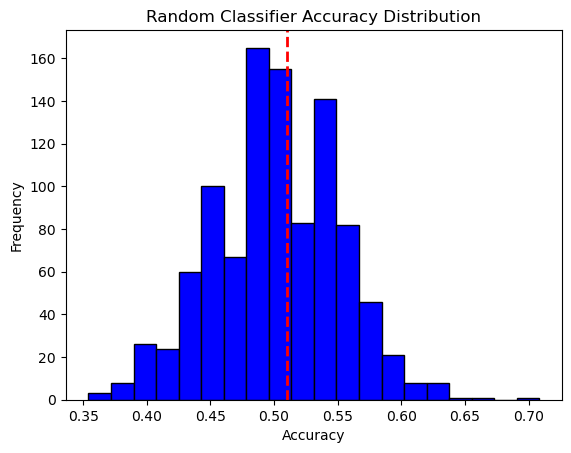

Confusion Matrix:
 [[27 20]
 [27 22]]
Class-specific Accuracy: [0.57446809 0.44897959]
(492, 41, 3)
 Test Accuracy = 67.71%, p-value = 0.0000


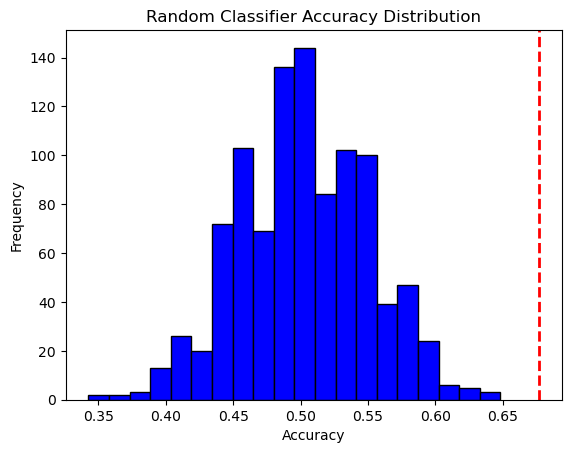

Confusion Matrix:
 [[48 11]
 [21 28]]
Class-specific Accuracy: [0.81355932 0.57142857]
(516, 41, 3)
 Test Accuracy = 45.83%, p-value = 0.7860


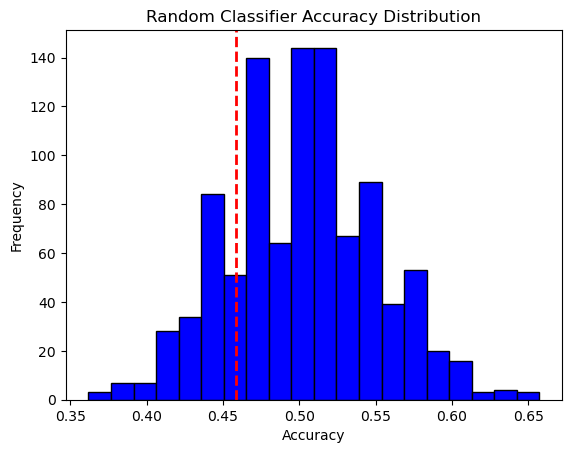

Confusion Matrix:
 [[31 25]
 [31 18]]
Class-specific Accuracy: [0.55357143 0.36734694]
(680, 41, 3)
 Test Accuracy = 50.00%, p-value = 0.5250


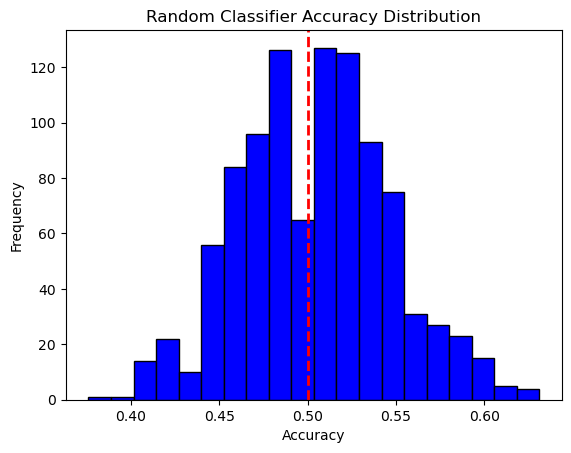

Confusion Matrix:
 [[43 33]
 [37 28]]
Class-specific Accuracy: [0.56578947 0.43076923]
(547, 41, 3)
 Test Accuracy = 48.21%, p-value = 0.7520


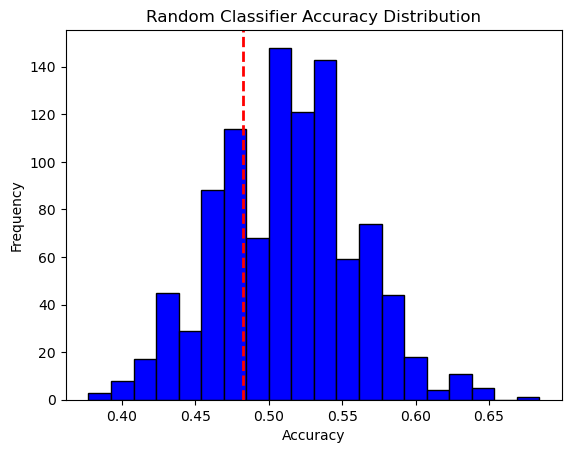

Confusion Matrix:
 [[20 45]
 [15 34]]
Class-specific Accuracy: [0.30769231 0.69387755]
(600, 41, 3)
 Test Accuracy = 54.46%, p-value = 0.2030


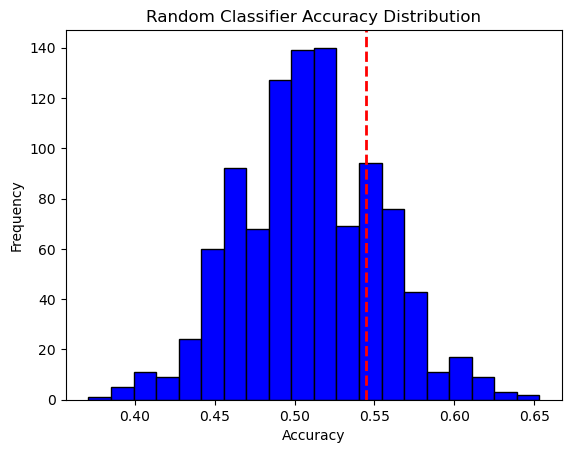

Confusion Matrix:
 [[46 23]
 [32 23]]
Class-specific Accuracy: [0.66666667 0.41818182]
(326, 41, 3)
 Test Accuracy = 46.88%, p-value = 0.6690


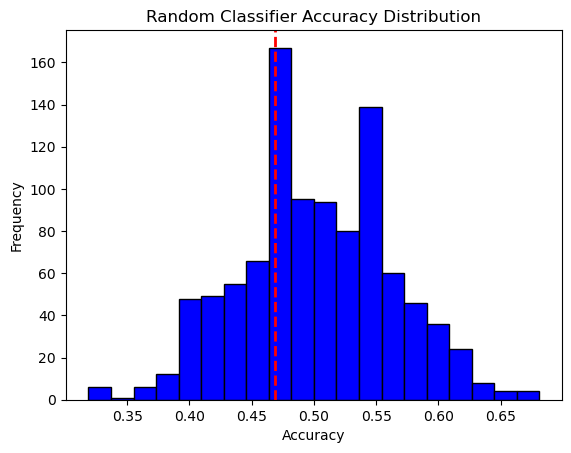

Confusion Matrix:
 [[15 21]
 [16 17]]
Class-specific Accuracy: [0.41666667 0.51515152]
(486, 41, 3)
 Test Accuracy = 38.54%, p-value = 0.9890


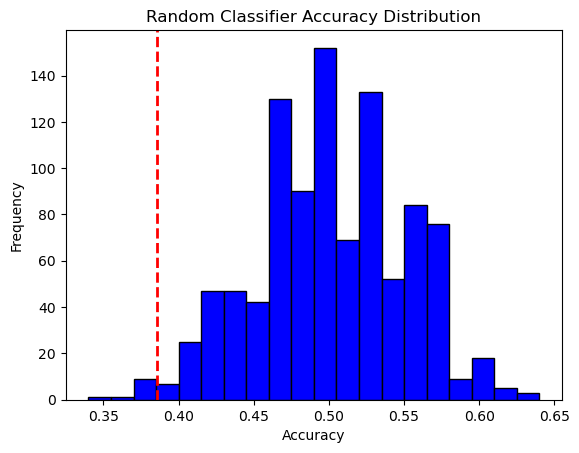

Confusion Matrix:
 [[22 28]
 [32 18]]
Class-specific Accuracy: [0.44 0.36]
(422, 41, 3)
 Test Accuracy = 46.25%, p-value = 0.7780


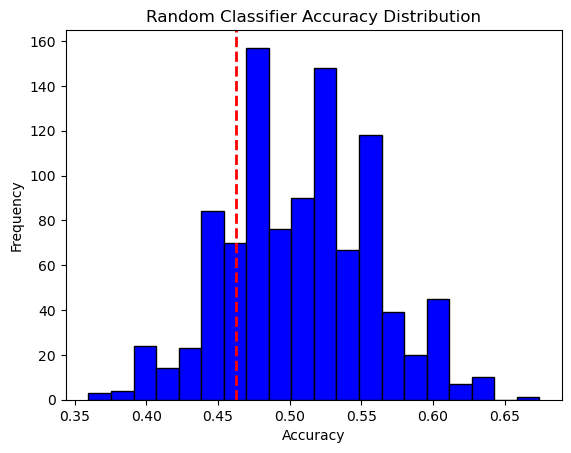

Confusion Matrix:
 [[23 26]
 [23 17]]
Class-specific Accuracy: [0.46938776 0.425     ]
(558, 41, 3)
 Test Accuracy = 50.89%, p-value = 0.4900


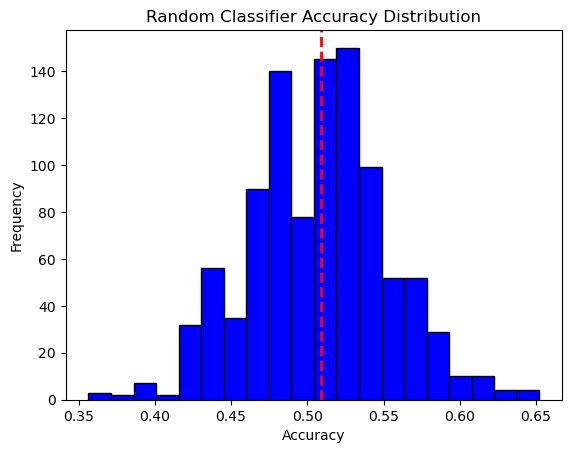

Confusion Matrix:
 [[30 34]
 [24 27]]
Class-specific Accuracy: [0.46875    0.52941176]
(302, 41, 3)
 Test Accuracy = 60.42%, p-value = 0.0360


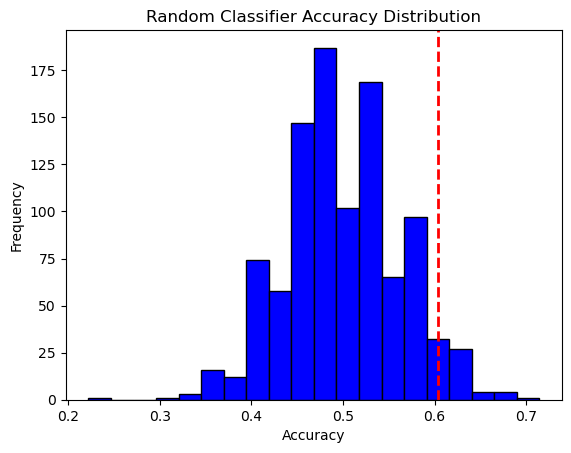

Confusion Matrix:
 [[15 16]
 [12 20]]
Class-specific Accuracy: [0.48387097 0.625     ]
(213, 41, 3)
 Test Accuracy = 40.62%, p-value = 0.8740


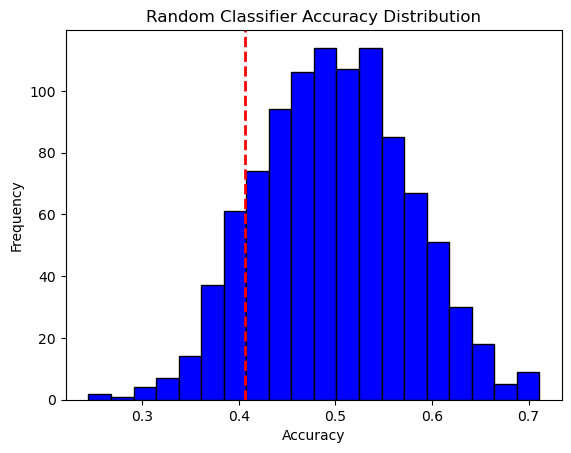

Confusion Matrix:
 [[10 11]
 [13 11]]
Class-specific Accuracy: [0.47619048 0.45833333]
(415, 41, 3)
 Test Accuracy = 43.75%, p-value = 0.8760


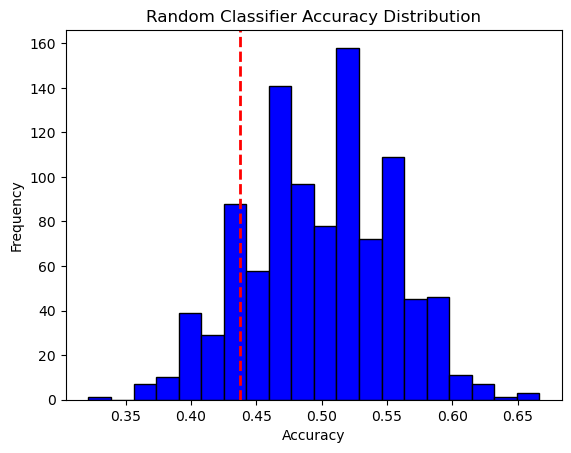

Confusion Matrix:
 [[18 24]
 [23 19]]
Class-specific Accuracy: [0.42857143 0.45238095]
(339, 41, 3)
 Test Accuracy = 43.75%, p-value = 0.8740


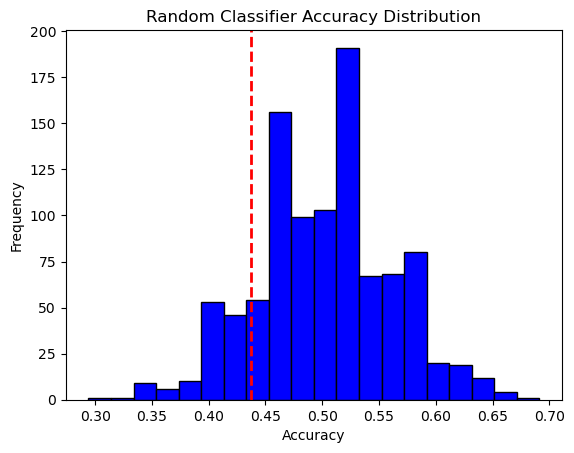

Confusion Matrix:
 [[16 20]
 [19 13]]
Class-specific Accuracy: [0.44444444 0.40625   ]
(600, 41, 3)
 Test Accuracy = 58.93%, p-value = 0.0350


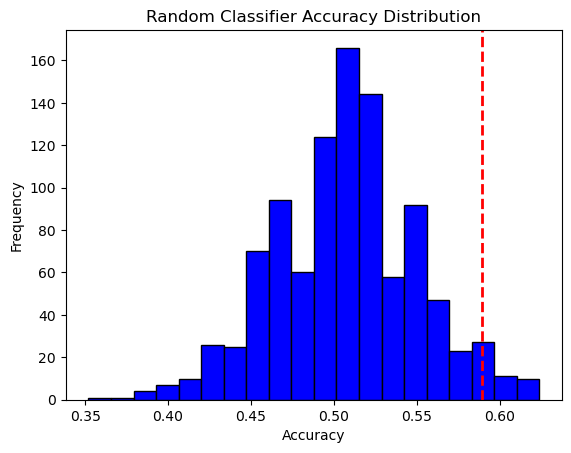

Confusion Matrix:
 [[30 40]
 [12 43]]
Class-specific Accuracy: [0.42857143 0.78181818]
(313, 41, 3)
 Test Accuracy = 54.69%, p-value = 0.2400


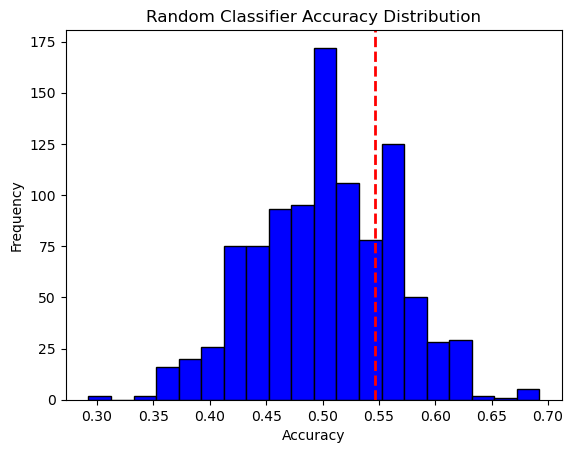

Confusion Matrix:
 [[19 14]
 [16 16]]
Class-specific Accuracy: [0.57575758 0.5       ]
(264, 41, 3)
 Test Accuracy = 58.33%, p-value = 0.1170


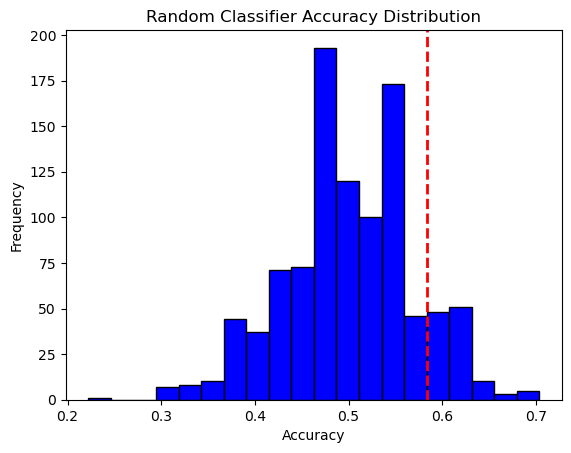

Confusion Matrix:
 [[13 15]
 [ 8 18]]
Class-specific Accuracy: [0.46428571 0.69230769]
(510, 41, 3)
 Test Accuracy = 59.38%, p-value = 0.0420


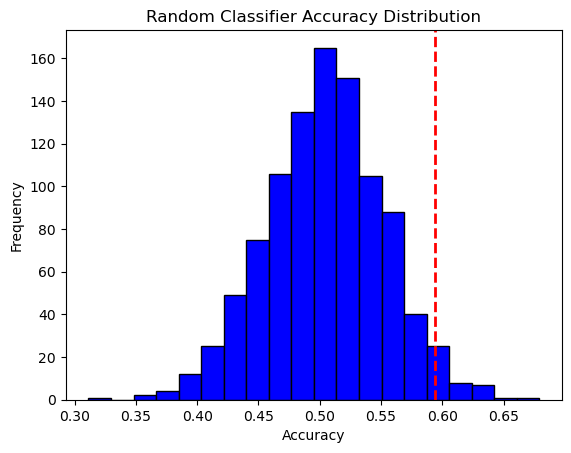

Confusion Matrix:
 [[44 12]
 [28 22]]
Class-specific Accuracy: [0.78571429 0.44      ]
(251, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.1840


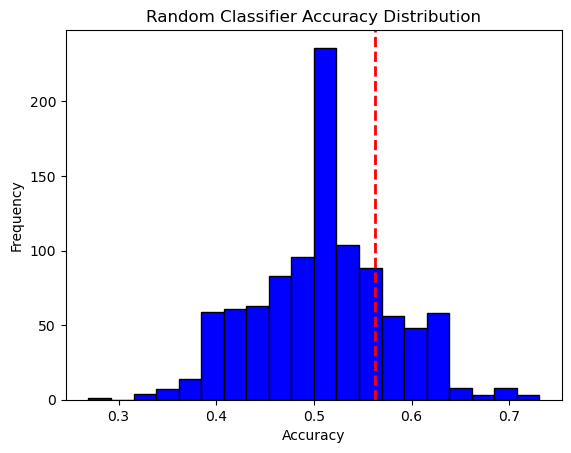

Confusion Matrix:
 [[19 10]
 [12 11]]
Class-specific Accuracy: [0.65517241 0.47826087]
(328, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.0300


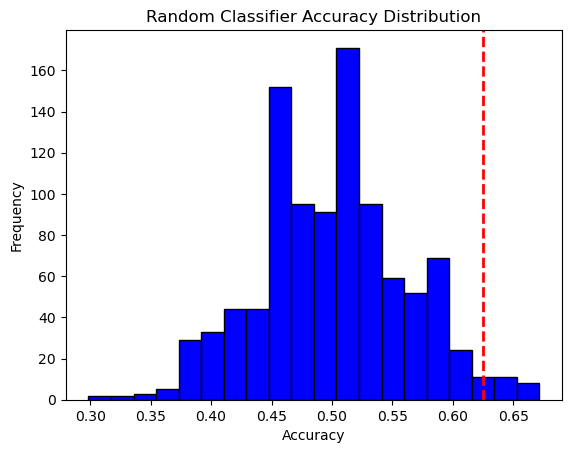

Confusion Matrix:
 [[23 12]
 [14 18]]
Class-specific Accuracy: [0.65714286 0.5625    ]
Brain Area: S1, Analysis Type: LICK
(231, 41, 3)
 Test Accuracy = 76.56%, p-value = 0.0000


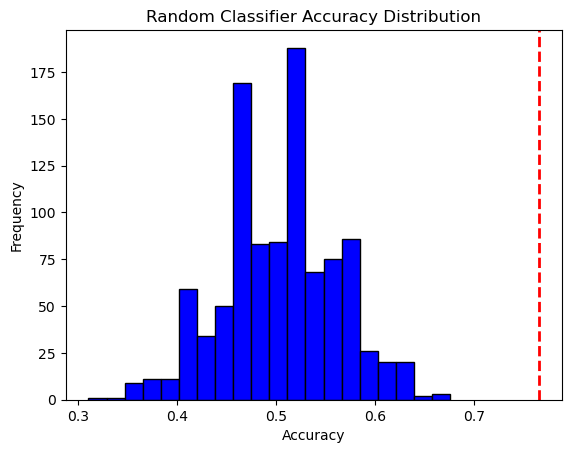

Confusion Matrix:
 [[33  8]
 [10 23]]
Class-specific Accuracy: [0.80487805 0.6969697 ]
(122, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.0900


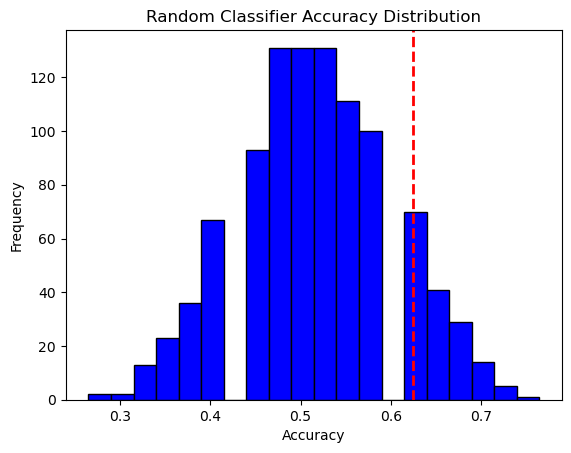

Confusion Matrix:
 [[11  9]
 [ 4 10]]
Class-specific Accuracy: [0.55       0.71428571]
(403, 41, 3)
 Test Accuracy = 67.97%, p-value = 0.0000


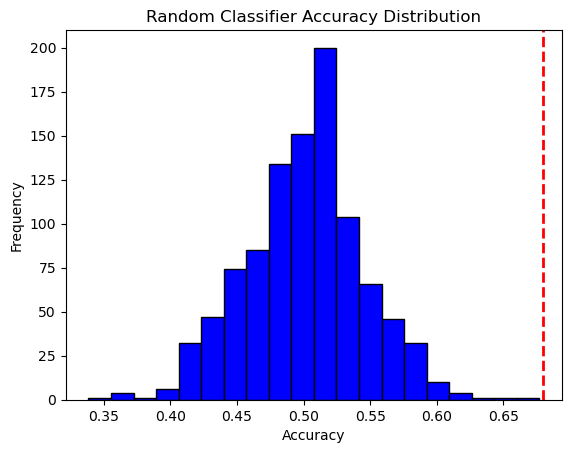

Confusion Matrix:
 [[43 26]
 [17 44]]
Class-specific Accuracy: [0.62318841 0.72131148]
(233, 41, 3)
 Test Accuracy = 37.50%, p-value = 0.9880


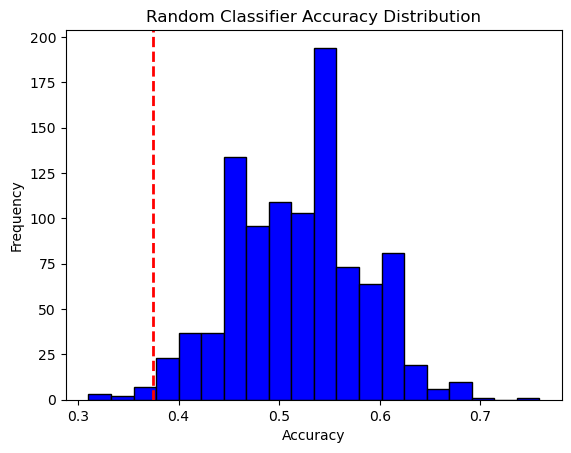

Confusion Matrix:
 [[10 14]
 [20 14]]
Class-specific Accuracy: [0.41666667 0.41176471]
(529, 41, 3)
 Test Accuracy = 69.32%, p-value = 0.0000


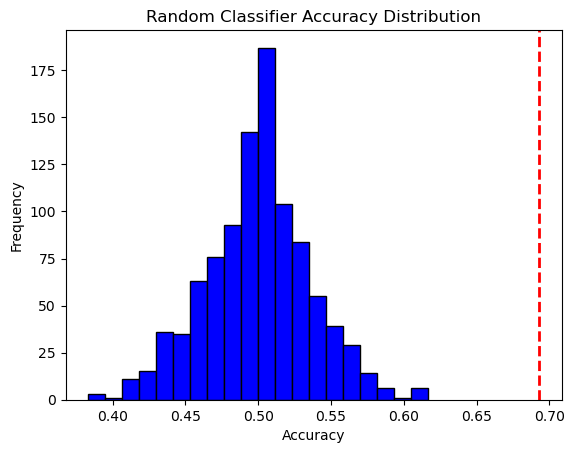

Confusion Matrix:
 [[66 28]
 [27 59]]
Class-specific Accuracy: [0.70212766 0.68604651]
(410, 41, 3)
Skipping session due to imbalance issues: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1
(429, 41, 3)
 Test Accuracy = 63.89%, p-value = 0.0000


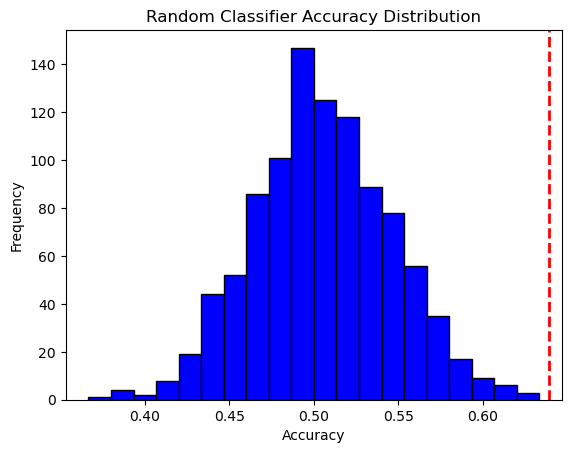

Confusion Matrix:
 [[55 23]
 [31 41]]
Class-specific Accuracy: [0.70512821 0.56944444]
(492, 41, 3)
 Test Accuracy = 71.25%, p-value = 0.0000


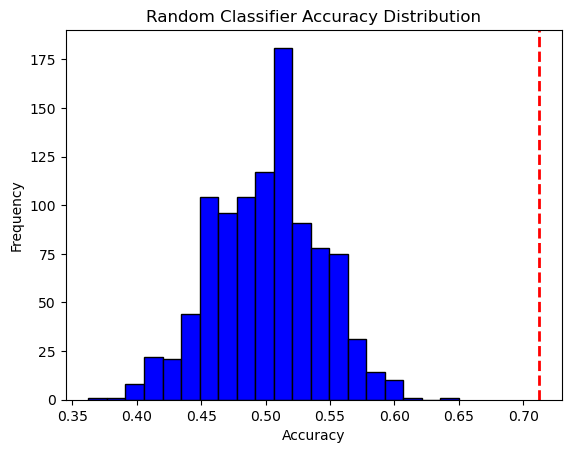

Confusion Matrix:
 [[67 13]
 [33 47]]
Class-specific Accuracy: [0.8375 0.5875]
(516, 41, 3)
 Test Accuracy = 64.77%, p-value = 0.0000


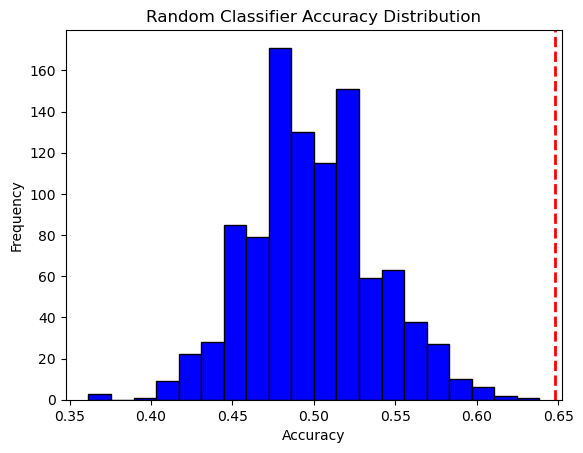

Confusion Matrix:
 [[76 17]
 [45 39]]
Class-specific Accuracy: [0.8172043  0.46428571]
(680, 41, 3)
 Test Accuracy = 68.75%, p-value = 0.0000


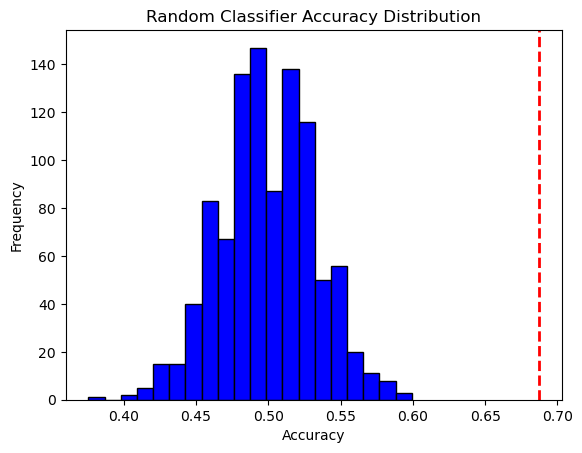

Confusion Matrix:
 [[101  18]
 [ 58  60]]
Class-specific Accuracy: [0.8487395  0.50847458]
(547, 41, 3)
 Test Accuracy = 59.90%, p-value = 0.0040


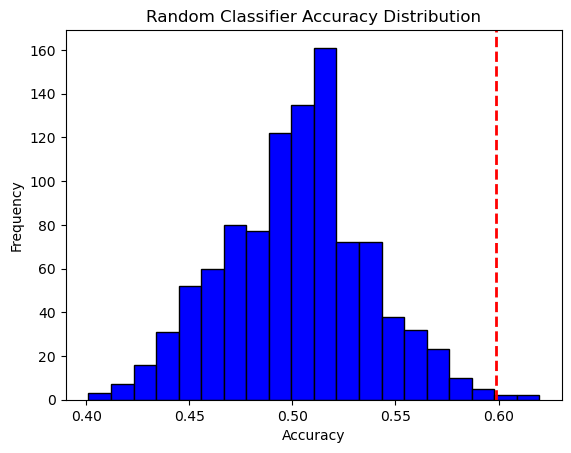

Confusion Matrix:
 [[47 43]
 [34 68]]
Class-specific Accuracy: [0.52222222 0.66666667]
(600, 41, 3)
 Test Accuracy = 82.29%, p-value = 0.0000


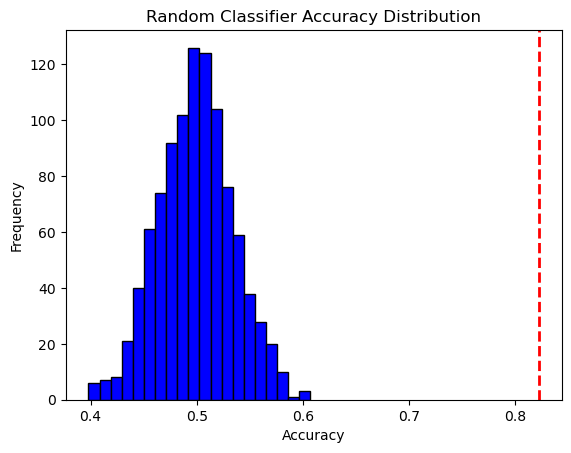

Confusion Matrix:
 [[84 11]
 [23 78]]
Class-specific Accuracy: [0.88421053 0.77227723]
(326, 41, 3)
 Test Accuracy = 59.38%, p-value = 0.0320


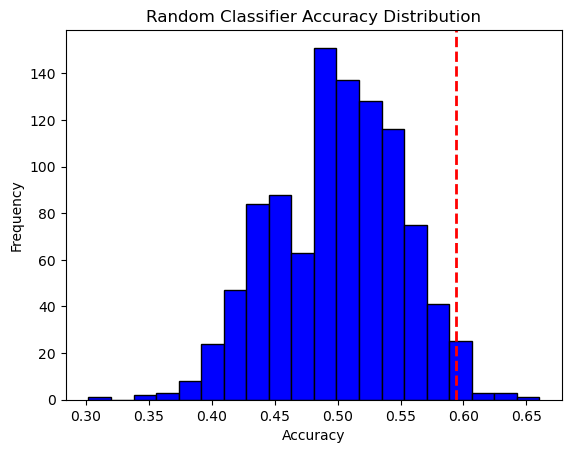

Confusion Matrix:
 [[33 23]
 [21 29]]
Class-specific Accuracy: [0.58928571 0.58      ]
(486, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.0840


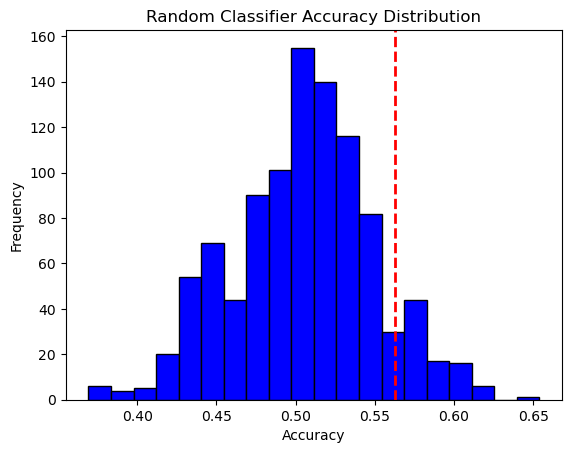

Confusion Matrix:
 [[33 37]
 [20 40]]
Class-specific Accuracy: [0.47142857 0.66666667]
(422, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.0780


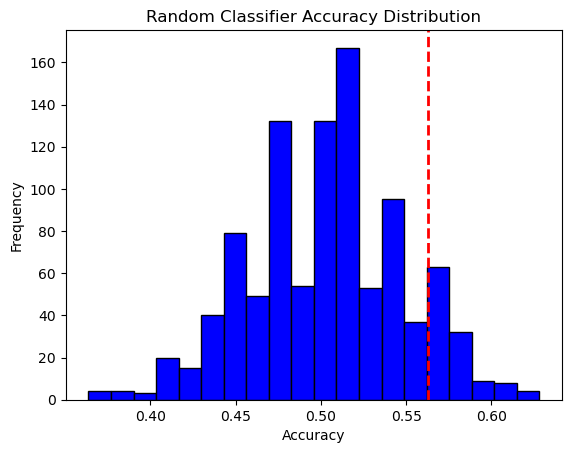

Confusion Matrix:
 [[31 33]
 [18 39]]
Class-specific Accuracy: [0.484375   0.68421053]
(558, 41, 3)
 Test Accuracy = 67.19%, p-value = 0.0000


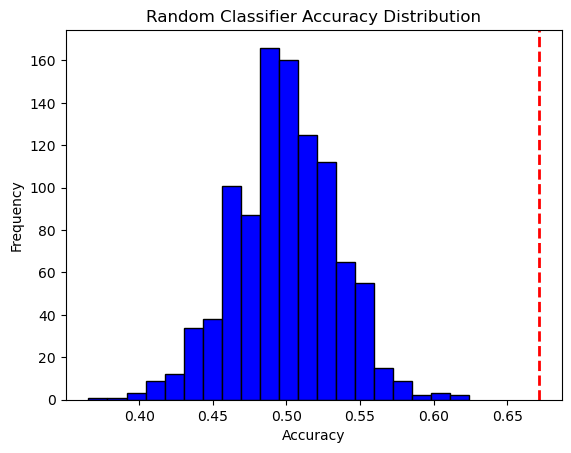

Confusion Matrix:
 [[78 20]
 [44 55]]
Class-specific Accuracy: [0.79591837 0.55555556]
(302, 41, 3)
 Test Accuracy = 31.25%, p-value = 1.0000


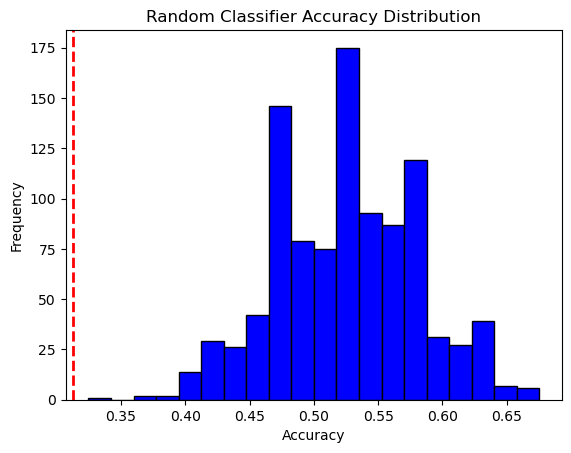

Confusion Matrix:
 [[11 36]
 [12 18]]
Class-specific Accuracy: [0.23404255 0.6       ]
(213, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.0190


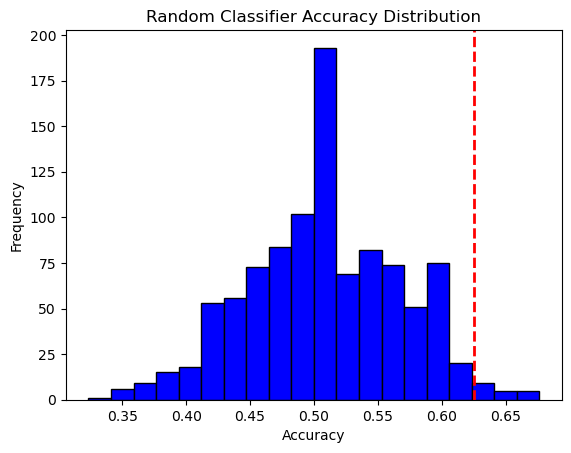

Confusion Matrix:
 [[22 15]
 [12 19]]
Class-specific Accuracy: [0.59459459 0.61290323]
(415, 41, 3)
 Test Accuracy = 68.75%, p-value = 0.0000


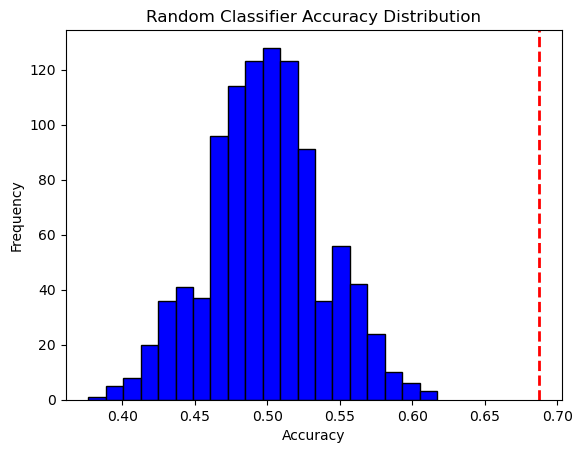

Confusion Matrix:
 [[60 20]
 [29 45]]
Class-specific Accuracy: [0.75       0.60810811]
(339, 41, 3)
 Test Accuracy = 74.11%, p-value = 0.0000


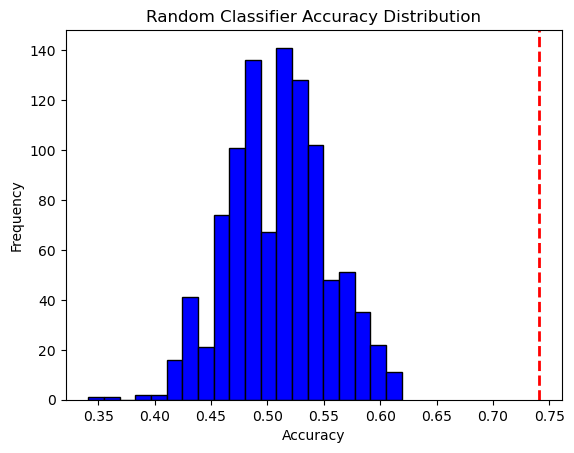

Confusion Matrix:
 [[53 18]
 [14 41]]
Class-specific Accuracy: [0.74647887 0.74545455]
(600, 41, 3)
 Test Accuracy = 67.79%, p-value = 0.0000


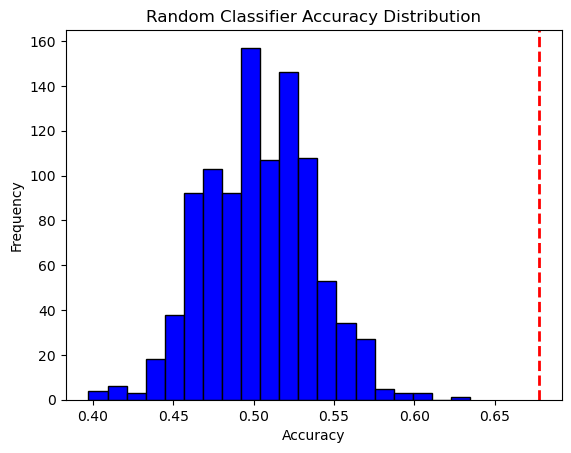

Confusion Matrix:
 [[86 33]
 [38 62]]
Class-specific Accuracy: [0.72268908 0.62      ]
(313, 41, 3)
 Test Accuracy = 65.62%, p-value = 0.0000


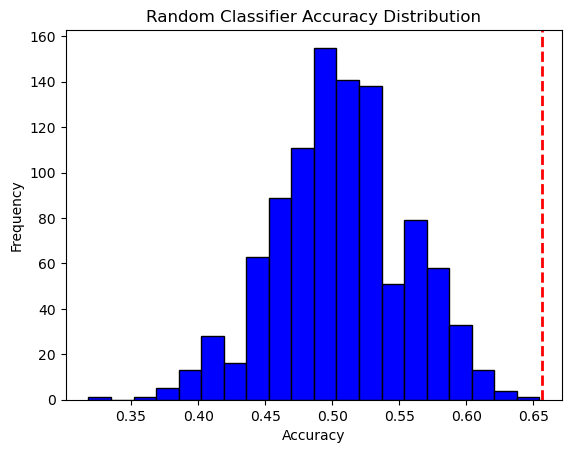

Confusion Matrix:
 [[49 13]
 [22 26]]
Class-specific Accuracy: [0.79032258 0.54166667]
(264, 41, 3)
 Test Accuracy = 93.75%, p-value = 0.0000


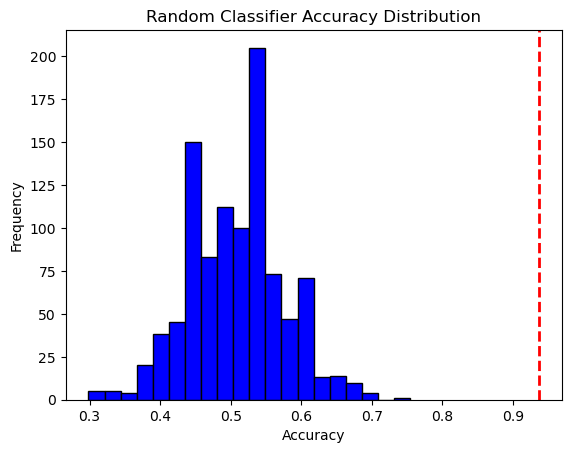

Confusion Matrix:
 [[26  1]
 [ 2 28]]
Class-specific Accuracy: [0.96296296 0.93333333]
(510, 41, 3)
 Test Accuracy = 77.08%, p-value = 0.0000


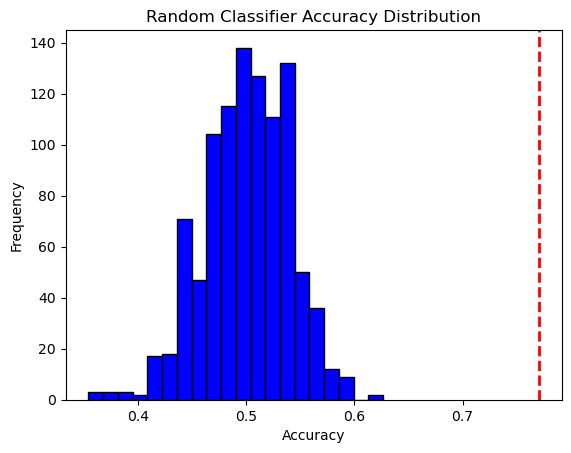

Confusion Matrix:
 [[59 18]
 [18 63]]
Class-specific Accuracy: [0.76623377 0.77777778]
(251, 41, 3)
 Test Accuracy = 70.31%, p-value = 0.0000


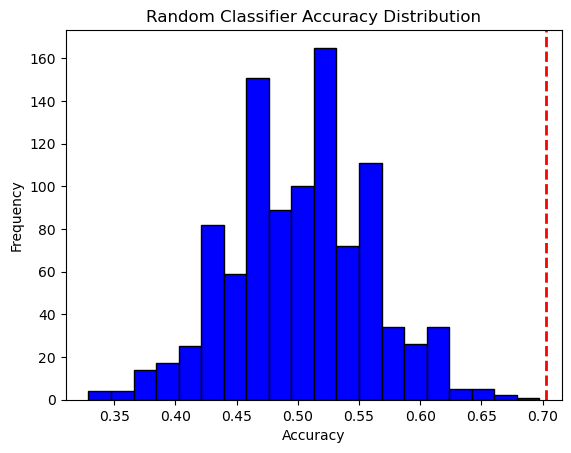

Confusion Matrix:
 [[28 11]
 [14 23]]
Class-specific Accuracy: [0.71794872 0.62162162]
(328, 41, 3)
 Test Accuracy = 87.50%, p-value = 0.0000


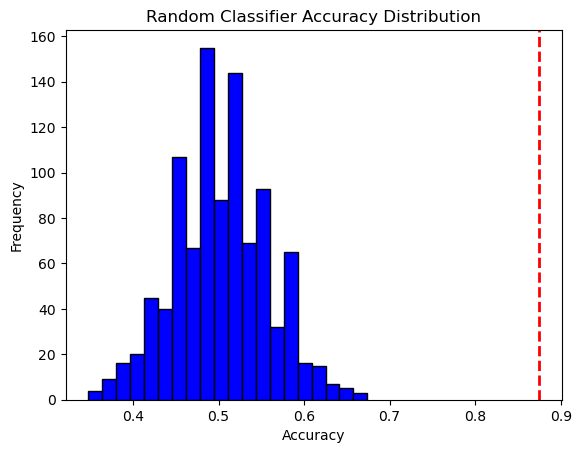

Confusion Matrix:
 [[41  8]
 [ 5 38]]
Class-specific Accuracy: [0.83673469 0.88372093]
Brain Area: S1naive, Analysis Type: GO
(249, 41, 3)
 Test Accuracy = 43.75%, p-value = 0.8140


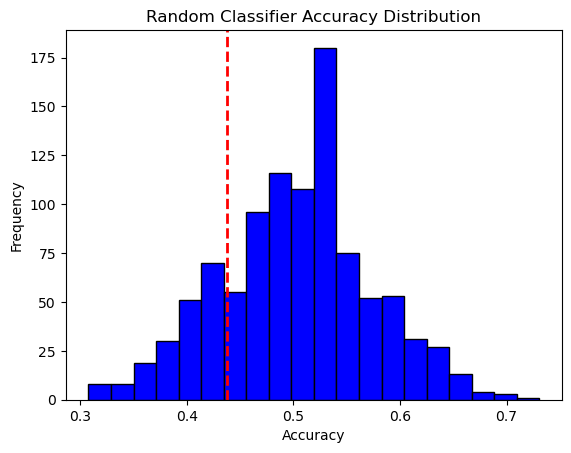

Confusion Matrix:
 [[15  9]
 [21  7]]
Class-specific Accuracy: [0.625 0.25 ]
(249, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.1860


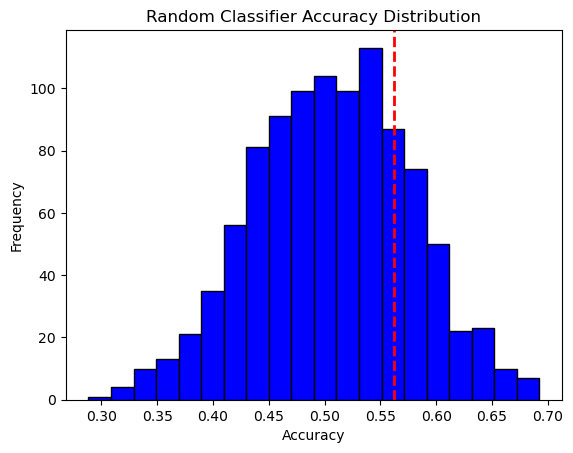

Confusion Matrix:
 [[16 13]
 [ 9 14]]
Class-specific Accuracy: [0.55172414 0.60869565]
(317, 41, 3)
 Test Accuracy = 53.12%, p-value = 0.3620


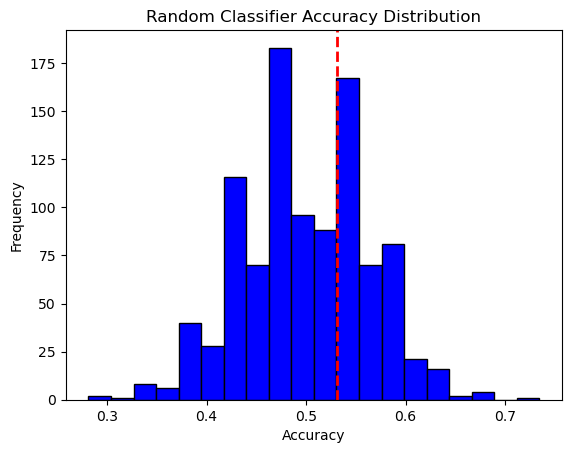

Confusion Matrix:
 [[14 19]
 [11 20]]
Class-specific Accuracy: [0.42424242 0.64516129]
(317, 41, 3)
 Test Accuracy = 54.69%, p-value = 0.2180


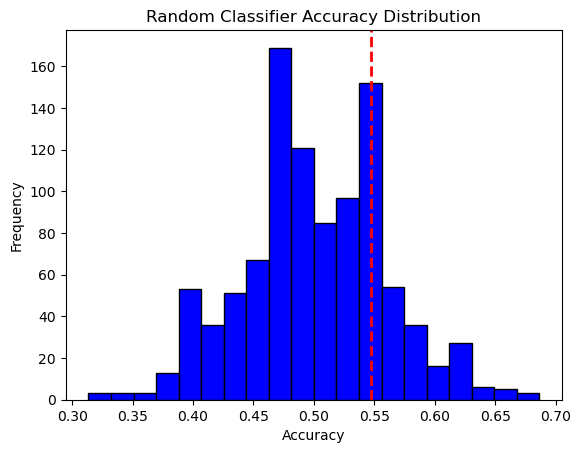

Confusion Matrix:
 [[20 15]
 [16 16]]
Class-specific Accuracy: [0.57142857 0.5       ]
(247, 41, 3)
 Test Accuracy = 58.33%, p-value = 0.1000


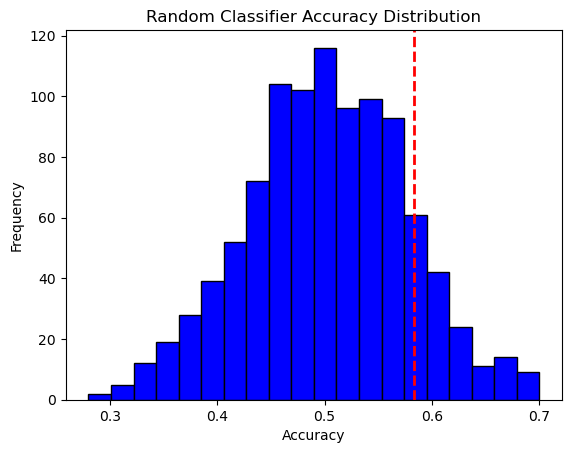

Confusion Matrix:
 [[15 11]
 [10 14]]
Class-specific Accuracy: [0.57692308 0.58333333]
(234, 41, 3)
 Test Accuracy = 64.58%, p-value = 0.0190


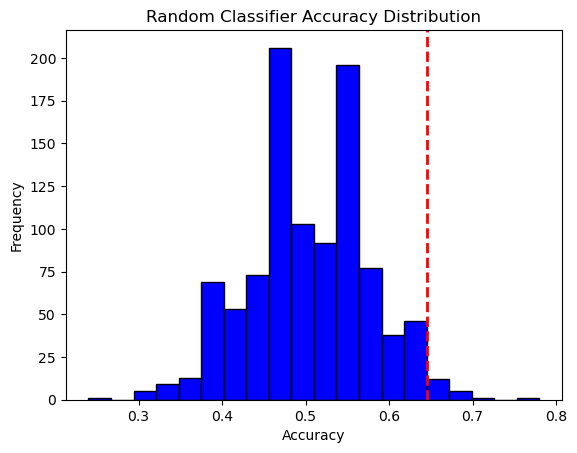

Confusion Matrix:
 [[18  8]
 [ 9 15]]
Class-specific Accuracy: [0.69230769 0.625     ]
(212, 41, 3)
 Test Accuracy = 53.12%, p-value = 0.4110


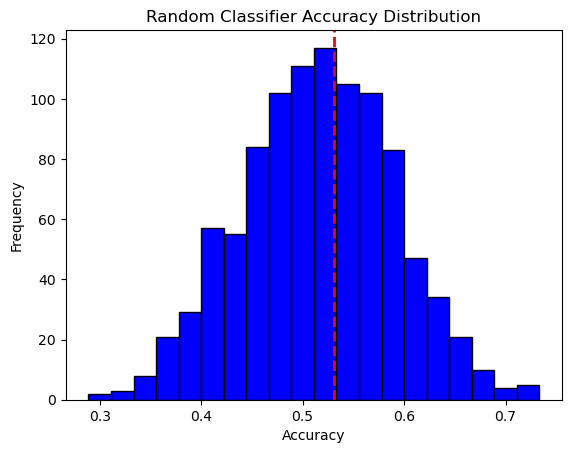

Confusion Matrix:
 [[15  6]
 [16  8]]
Class-specific Accuracy: [0.71428571 0.33333333]
(250, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.1730


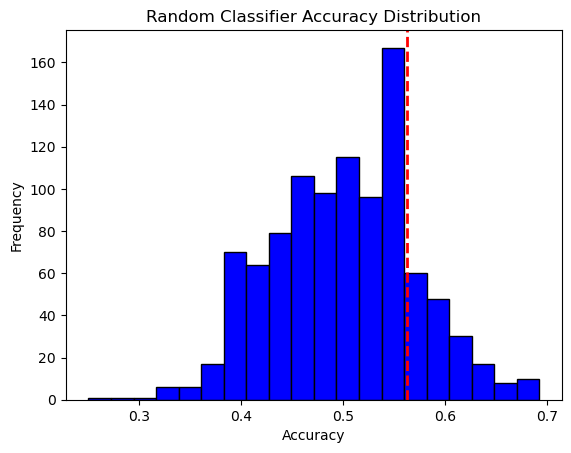

Confusion Matrix:
 [[16  8]
 [13 15]]
Class-specific Accuracy: [0.66666667 0.53571429]
(258, 41, 3)
 Test Accuracy = 39.58%, p-value = 0.9610


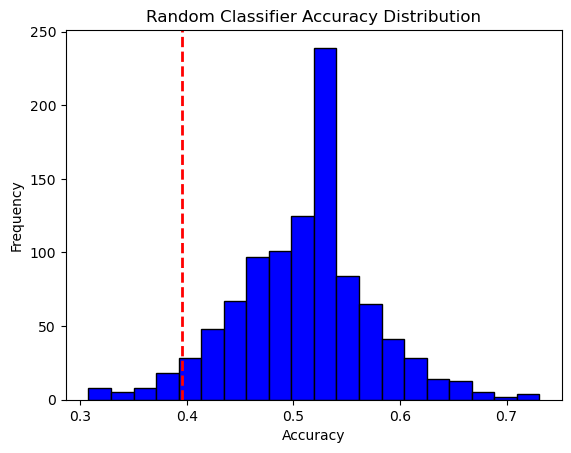

Confusion Matrix:
 [[11 18]
 [12 11]]
Class-specific Accuracy: [0.37931034 0.47826087]
(258, 41, 3)
 Test Accuracy = 52.08%, p-value = 0.4060


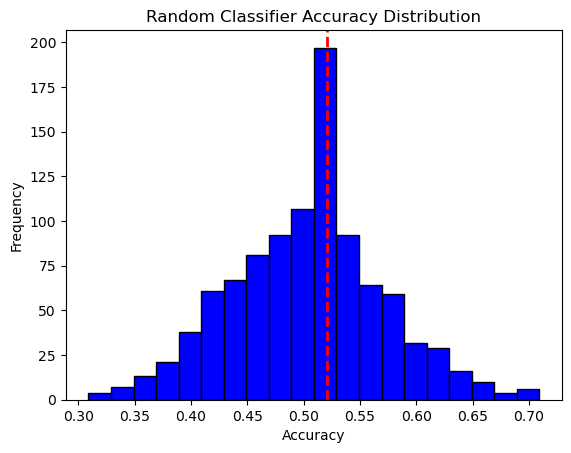

Confusion Matrix:
 [[12 17]
 [11 15]]
Class-specific Accuracy: [0.4137931  0.57692308]
(198, 41, 3)
 Test Accuracy = 40.62%, p-value = 0.8730


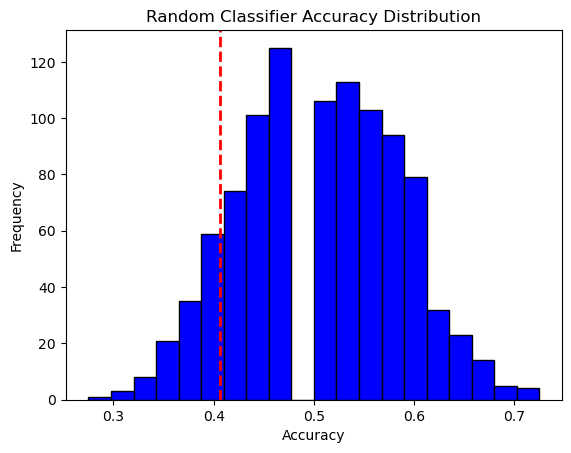

Confusion Matrix:
 [[ 9 12]
 [11  8]]
Class-specific Accuracy: [0.42857143 0.42105263]
(297, 41, 3)
 Test Accuracy = 43.75%, p-value = 0.8630


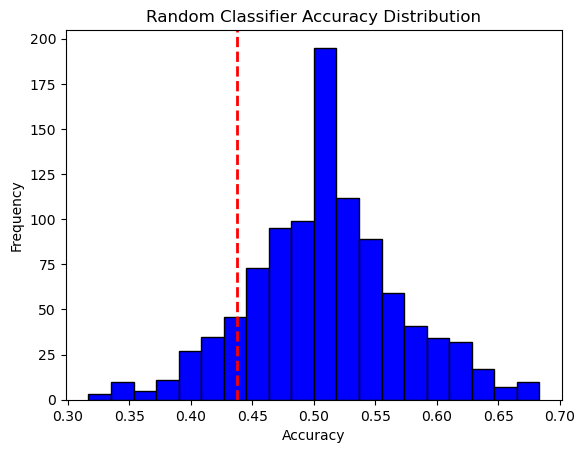

Confusion Matrix:
 [[14 20]
 [14 12]]
Class-specific Accuracy: [0.41176471 0.46153846]
(197, 41, 3)
 Test Accuracy = 40.62%, p-value = 0.8730


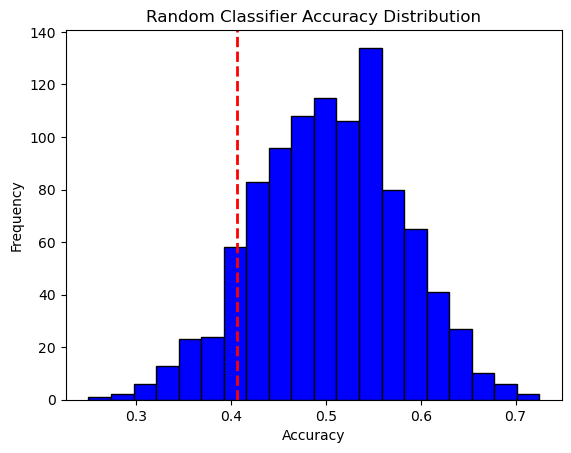

Confusion Matrix:
 [[11  8]
 [13  8]]
Class-specific Accuracy: [0.57894737 0.38095238]
(357, 41, 3)
 Test Accuracy = 46.88%, p-value = 0.7440


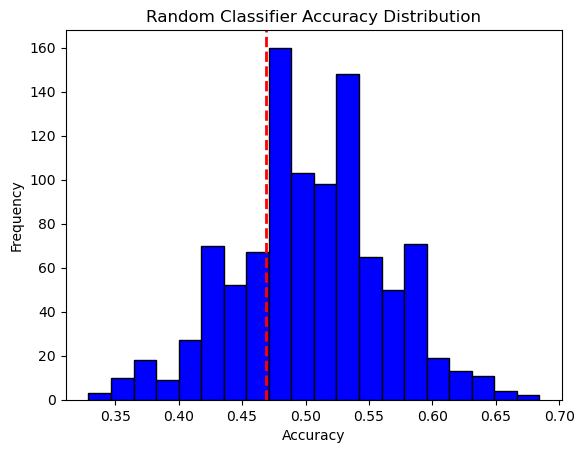

Confusion Matrix:
 [[17 24]
 [17 18]]
Class-specific Accuracy: [0.41463415 0.51428571]
Brain Area: S1naive, Analysis Type: LICK
(249, 41, 3)
Skipping session due to imbalance issues: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3
(249, 41, 3)
Skipping session due to imbalance issues: The target 'y' needs to have more than 1 class. Got 1 class instead
(317, 41, 3)
 Test Accuracy = 58.75%, p-value = 0.0710


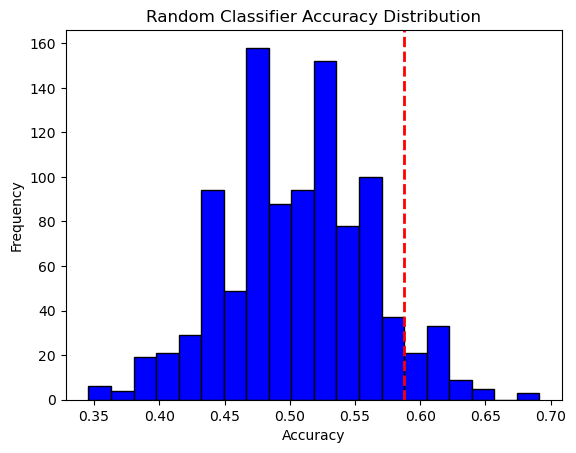

Confusion Matrix:
 [[24 21]
 [12 24]]
Class-specific Accuracy: [0.53333333 0.66666667]
(317, 41, 3)
 Test Accuracy = 53.75%, p-value = 0.2940


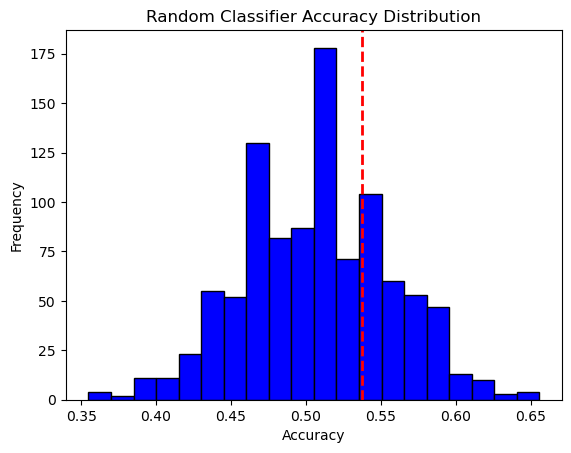

Confusion Matrix:
 [[30 21]
 [22 20]]
Class-specific Accuracy: [0.58823529 0.47619048]
(247, 41, 3)
Skipping session due to imbalance issues: The target 'y' needs to have more than 1 class. Got 1 class instead
(234, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.0330


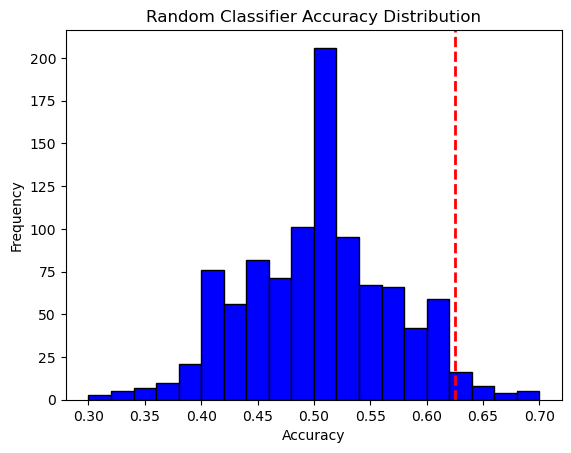

Confusion Matrix:
 [[23  6]
 [17 14]]
Class-specific Accuracy: [0.79310345 0.4516129 ]
(212, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.0230


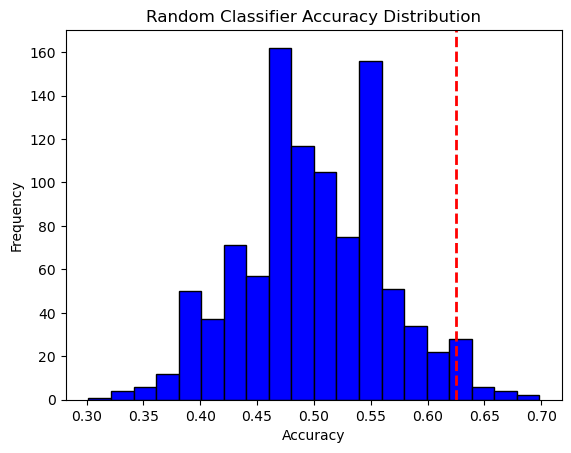

Confusion Matrix:
 [[12 19]
 [ 4 28]]
Class-specific Accuracy: [0.38709677 0.875     ]
(250, 41, 3)
 Test Accuracy = 65.62%, p-value = 0.0050


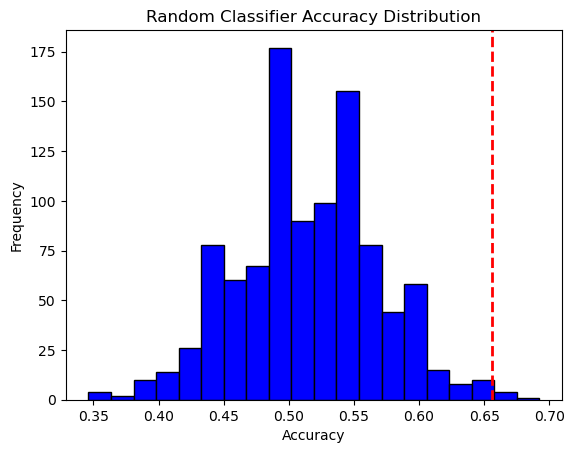

Confusion Matrix:
 [[26 20]
 [11 21]]
Class-specific Accuracy: [0.56521739 0.65625   ]
(258, 41, 3)
 Test Accuracy = 71.88%, p-value = 0.0000


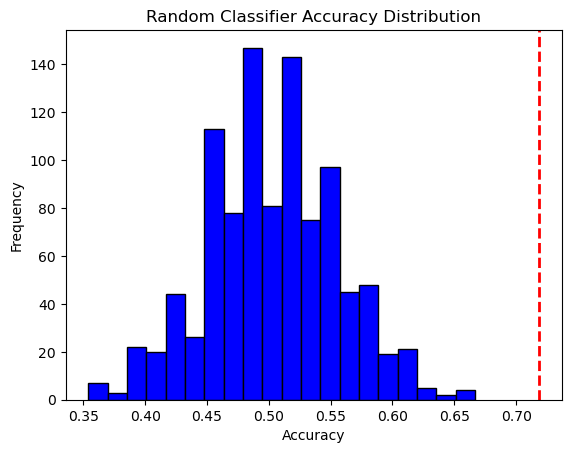

Confusion Matrix:
 [[32 15]
 [12 37]]
Class-specific Accuracy: [0.68085106 0.75510204]
(258, 41, 3)
 Test Accuracy = 45.31%, p-value = 0.7740


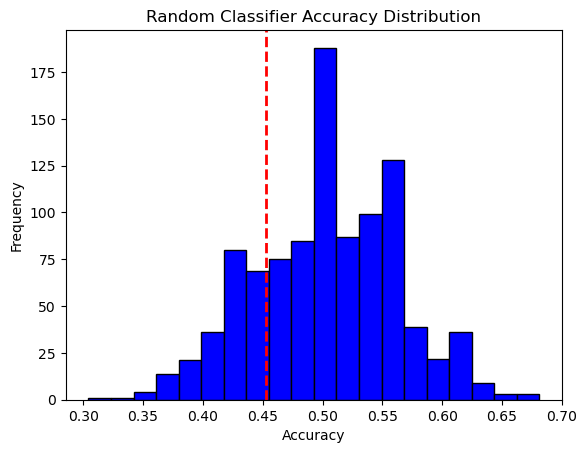

Confusion Matrix:
 [[17 20]
 [17 15]]
Class-specific Accuracy: [0.45945946 0.46875   ]
(198, 41, 3)
Skipping session due to imbalance issues: The target 'y' needs to have more than 1 class. Got 1 class instead
(297, 41, 3)
 Test Accuracy = 68.75%, p-value = 0.0010


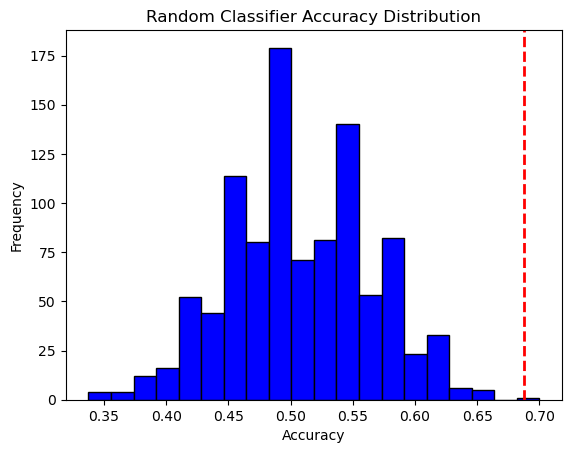

Confusion Matrix:
 [[36  8]
 [17 19]]
Class-specific Accuracy: [0.81818182 0.52777778]
(197, 41, 3)
 Test Accuracy = 68.75%, p-value = 0.0040


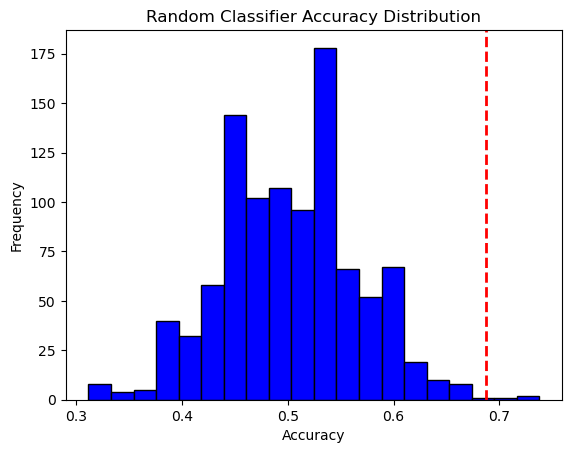

Confusion Matrix:
 [[23  8]
 [10 20]]
Class-specific Accuracy: [0.74193548 0.66666667]
(357, 41, 3)
 Test Accuracy = 73.21%, p-value = 0.0000


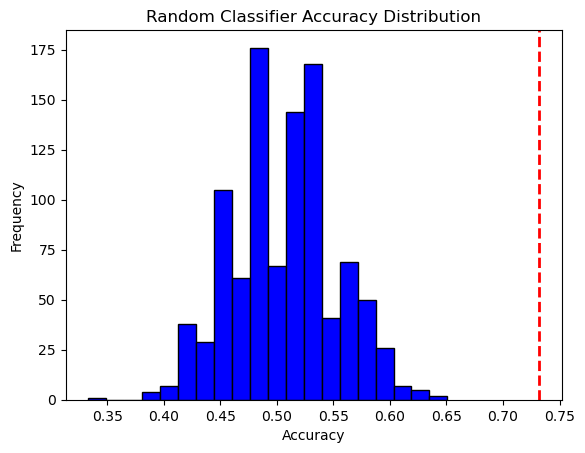

Confusion Matrix:
 [[52 19]
 [13 42]]
Class-specific Accuracy: [0.73239437 0.76363636]
Brain Area: PPC, Analysis Type: GO
(479, 41, 3)
 Test Accuracy = 53.12%, p-value = 0.2180


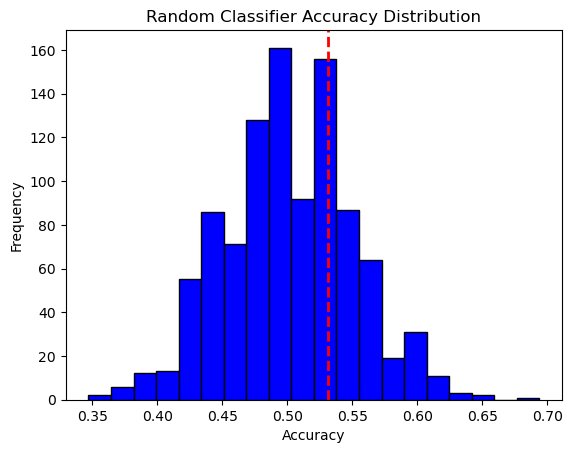

Confusion Matrix:
 [[33 16]
 [31 18]]
Class-specific Accuracy: [0.67346939 0.36734694]
(315, 41, 3)
 Test Accuracy = 51.56%, p-value = 0.4320


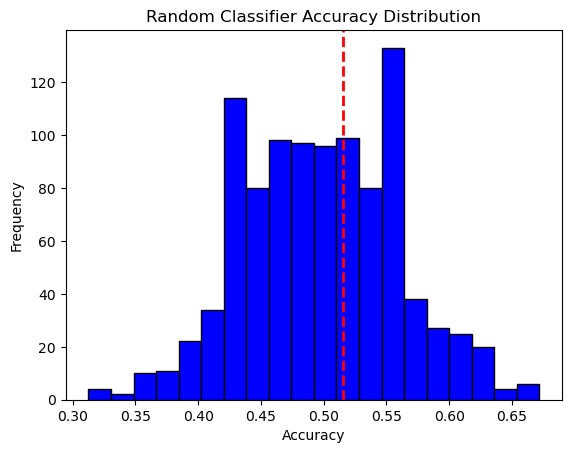

Confusion Matrix:
 [[15 17]
 [14 18]]
Class-specific Accuracy: [0.46875 0.5625 ]
(540, 41, 3)
 Test Accuracy = 49.11%, p-value = 0.6850


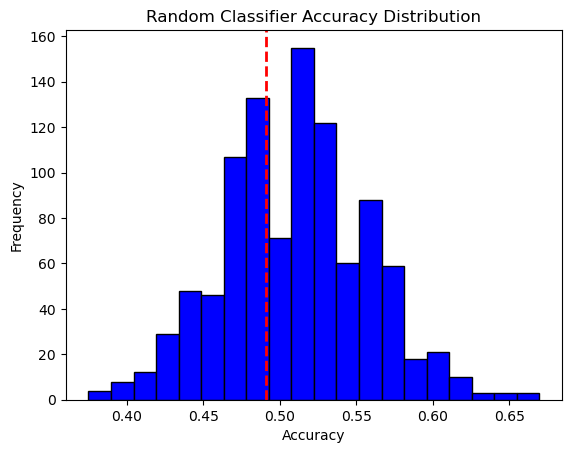

Confusion Matrix:
 [[21 43]
 [14 34]]
Class-specific Accuracy: [0.328125   0.70833333]
(336, 41, 3)
 Test Accuracy = 48.44%, p-value = 0.6670


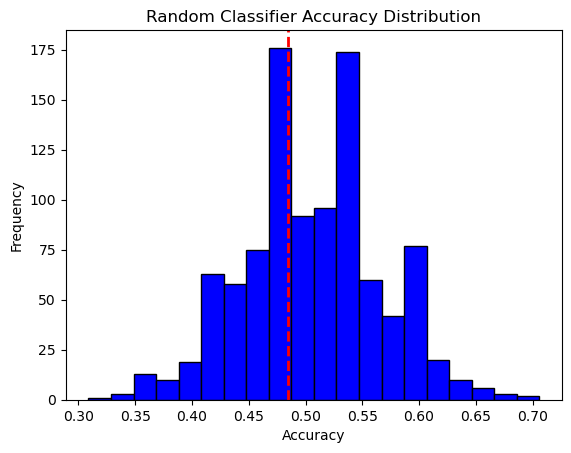

Confusion Matrix:
 [[ 9 28]
 [ 7 24]]
Class-specific Accuracy: [0.24324324 0.77419355]
(348, 41, 3)
 Test Accuracy = 42.19%, p-value = 0.9520


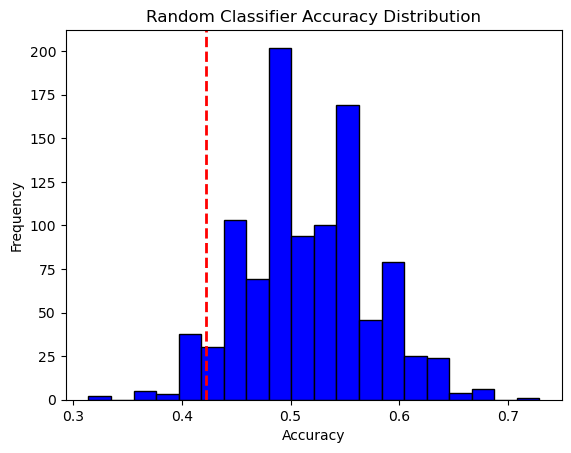

Confusion Matrix:
 [[14 27]
 [11 18]]
Class-specific Accuracy: [0.34146341 0.62068966]
(298, 41, 3)
 Test Accuracy = 62.50%, p-value = 0.0250


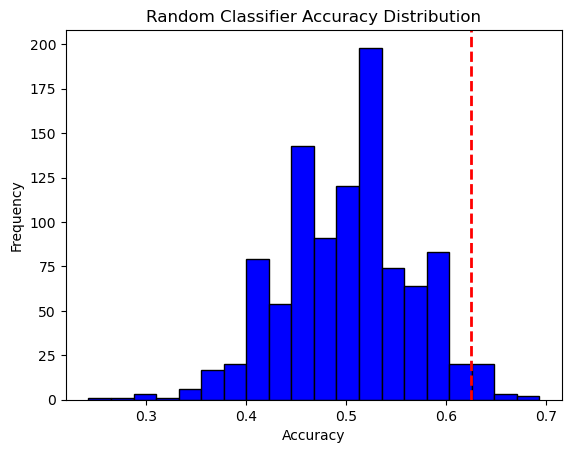

Confusion Matrix:
 [[20 12]
 [10 20]]
Class-specific Accuracy: [0.625      0.66666667]
(616, 41, 3)
 Test Accuracy = 52.68%, p-value = 0.3380


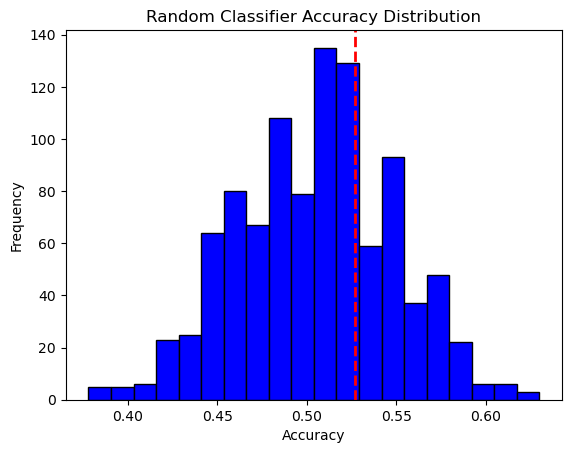

Confusion Matrix:
 [[35 31]
 [30 31]]
Class-specific Accuracy: [0.53030303 0.50819672]
(334, 41, 3)
 Test Accuracy = 48.44%, p-value = 0.5740


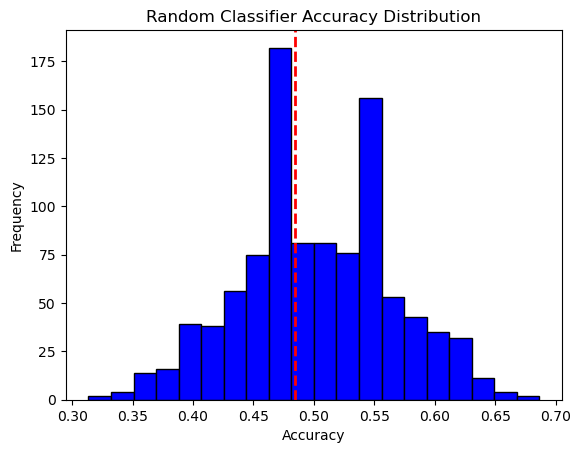

Confusion Matrix:
 [[25  9]
 [25  8]]
Class-specific Accuracy: [0.73529412 0.24242424]
(434, 41, 3)
 Test Accuracy = 47.50%, p-value = 0.6740


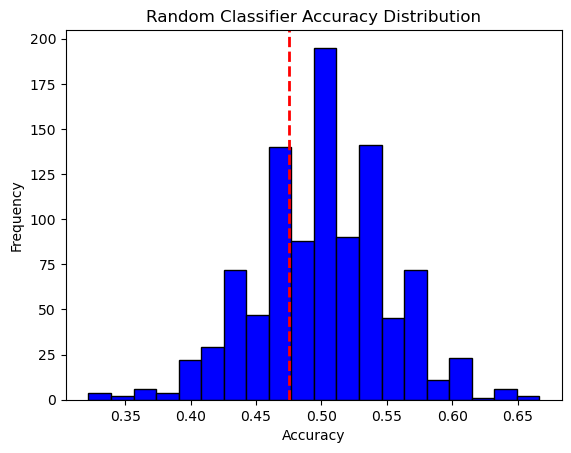

Confusion Matrix:
 [[15 29]
 [16 27]]
Class-specific Accuracy: [0.34090909 0.62790698]
(331, 41, 3)
 Test Accuracy = 53.12%, p-value = 0.4100


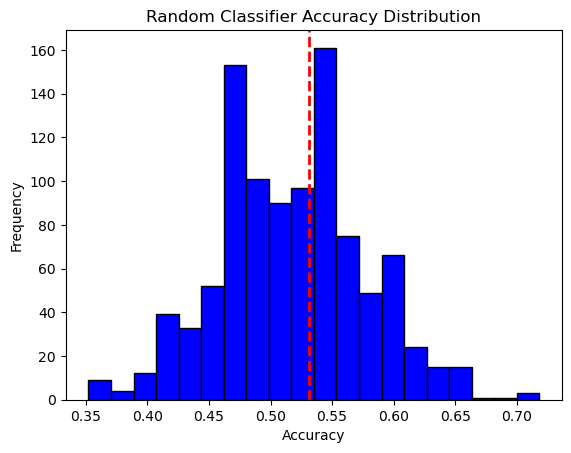

Confusion Matrix:
 [[21 21]
 [14 15]]
Class-specific Accuracy: [0.5        0.51724138]
(237, 41, 3)
 Test Accuracy = 54.17%, p-value = 0.3060


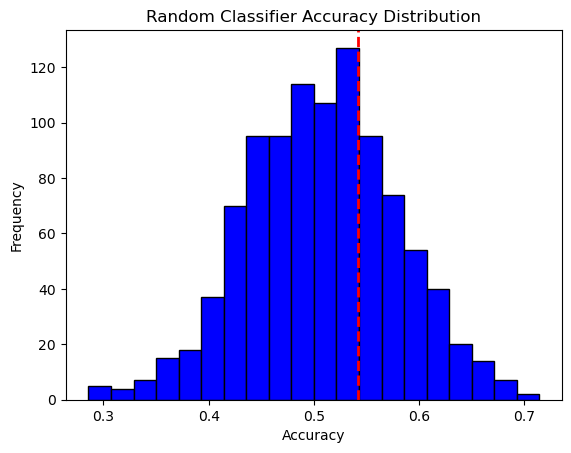

Confusion Matrix:
 [[18  9]
 [13  9]]
Class-specific Accuracy: [0.66666667 0.40909091]
(506, 41, 3)
 Test Accuracy = 44.79%, p-value = 0.8860


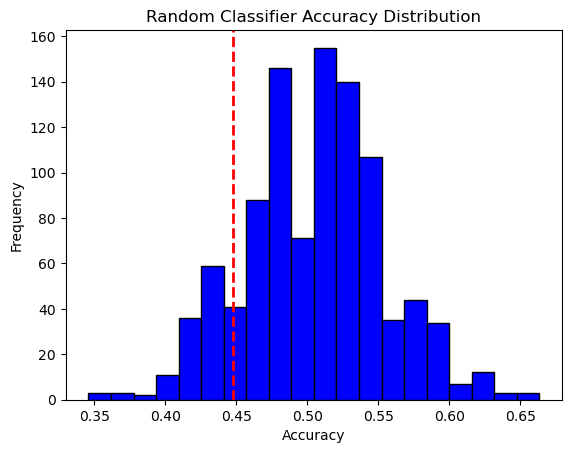

Confusion Matrix:
 [[26 33]
 [23 25]]
Class-specific Accuracy: [0.44067797 0.52083333]
(125, 41, 3)
 Test Accuracy = 43.75%, p-value = 0.8570


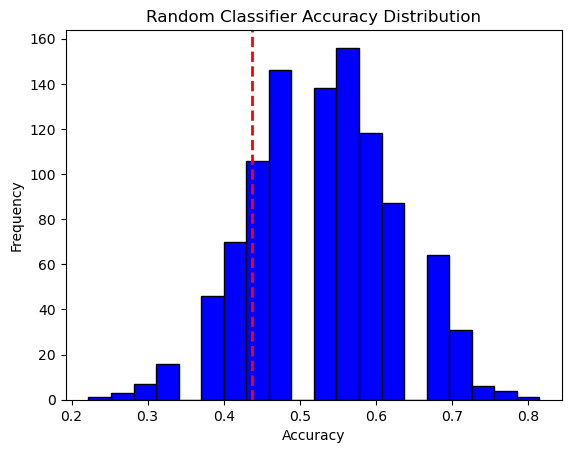

Confusion Matrix:
 [[ 5 12]
 [ 3  7]]
Class-specific Accuracy: [0.29411765 0.7       ]
(343, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.1380


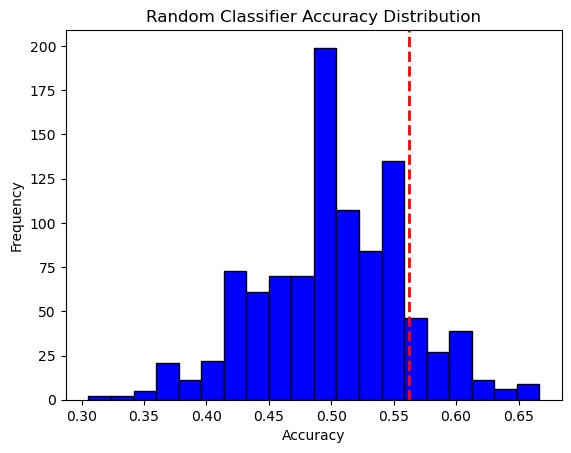

Confusion Matrix:
 [[23 14]
 [18 17]]
Class-specific Accuracy: [0.62162162 0.48571429]
(436, 41, 3)
 Test Accuracy = 45.00%, p-value = 0.8390


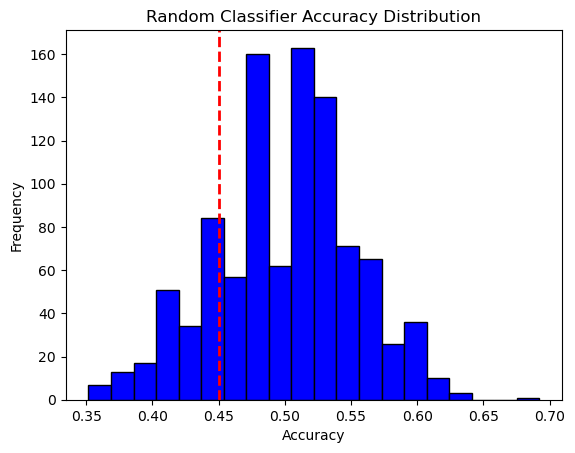

Confusion Matrix:
 [[21 24]
 [25 21]]
Class-specific Accuracy: [0.46666667 0.45652174]
(281, 41, 3)
 Test Accuracy = 56.25%, p-value = 0.1740


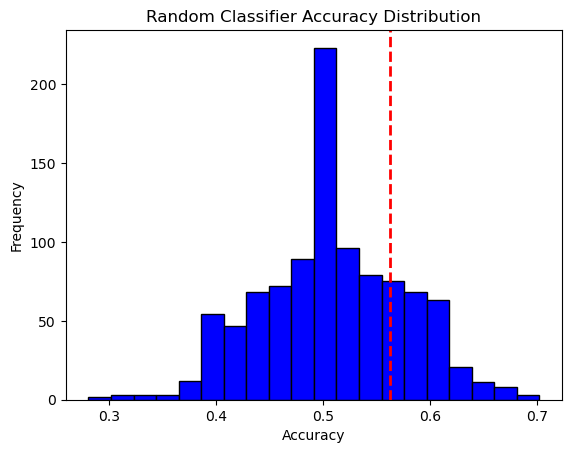

Confusion Matrix:
 [[15 11]
 [14 17]]
Class-specific Accuracy: [0.57692308 0.5483871 ]
Brain Area: PPC, Analysis Type: LICK
(479, 41, 3)
 Test Accuracy = 75.62%, p-value = 0.0000


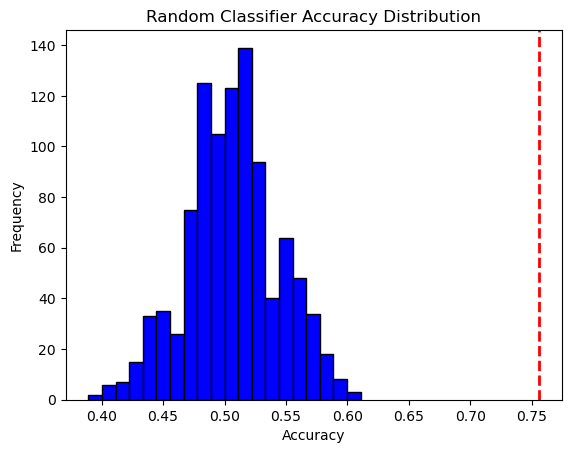

Confusion Matrix:
 [[62 13]
 [28 64]]
Class-specific Accuracy: [0.82666667 0.69565217]
(315, 41, 3)
 Test Accuracy = 67.86%, p-value = 0.0000


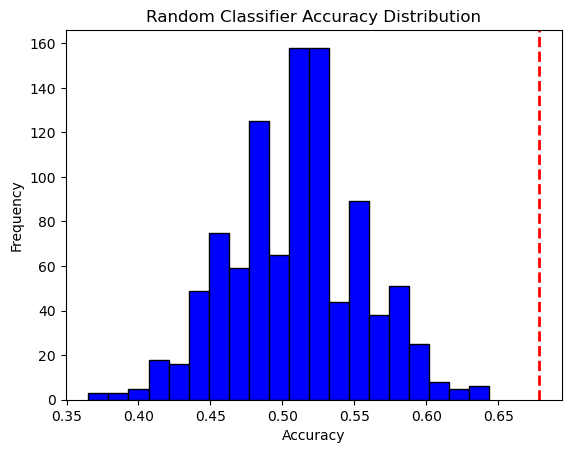

Confusion Matrix:
 [[56  9]
 [27 23]]
Class-specific Accuracy: [0.86153846 0.46      ]
(540, 41, 3)
 Test Accuracy = 55.00%, p-value = 0.0950


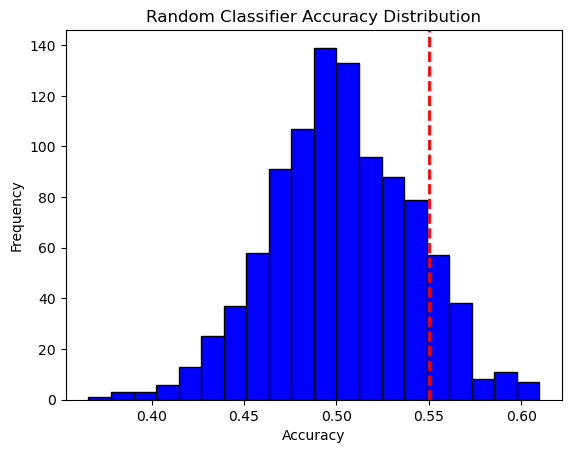

Confusion Matrix:
 [[46 36]
 [40 42]]
Class-specific Accuracy: [0.56097561 0.51219512]
(336, 41, 3)
 Test Accuracy = 70.54%, p-value = 0.0000


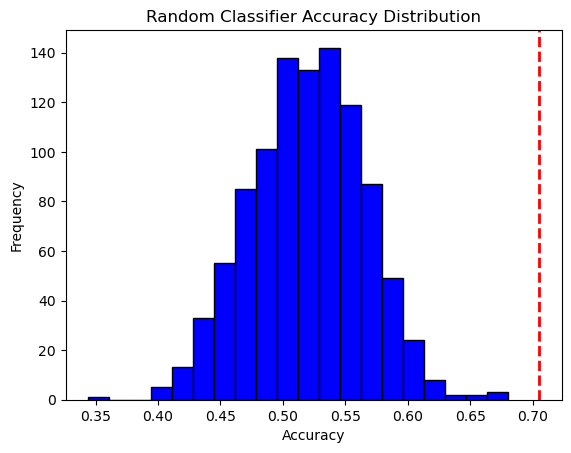

Confusion Matrix:
 [[50 23]
 [12 37]]
Class-specific Accuracy: [0.68493151 0.75510204]
(348, 41, 3)
 Test Accuracy = 58.75%, p-value = 0.0410


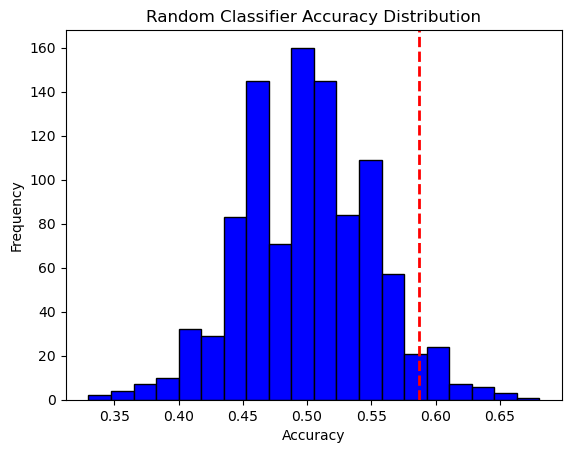

Confusion Matrix:
 [[26 19]
 [22 27]]
Class-specific Accuracy: [0.57777778 0.55102041]
(298, 41, 3)
 Test Accuracy = 63.54%, p-value = 0.0040


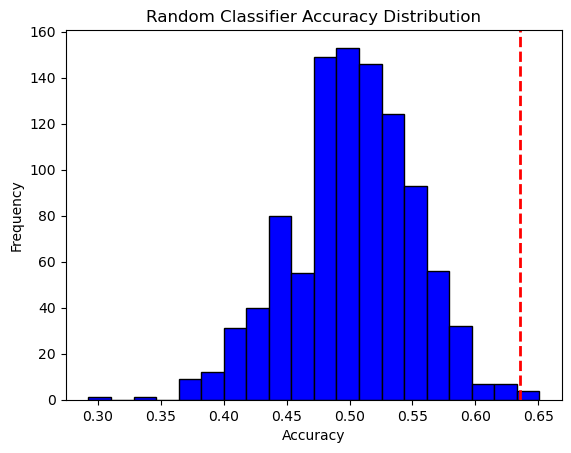

Confusion Matrix:
 [[45 11]
 [26 24]]
Class-specific Accuracy: [0.80357143 0.48      ]
(616, 41, 3)
 Test Accuracy = 55.73%, p-value = 0.0490


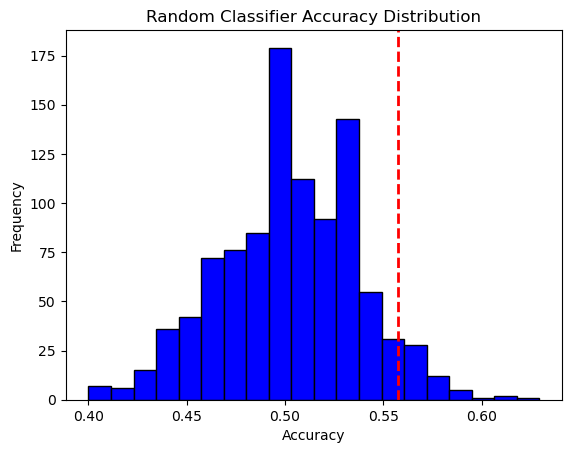

Confusion Matrix:
 [[69 33]
 [58 45]]
Class-specific Accuracy: [0.67647059 0.4368932 ]
(334, 41, 3)
Skipping session due to imbalance issues: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1
(434, 41, 3)
 Test Accuracy = 77.08%, p-value = 0.0000


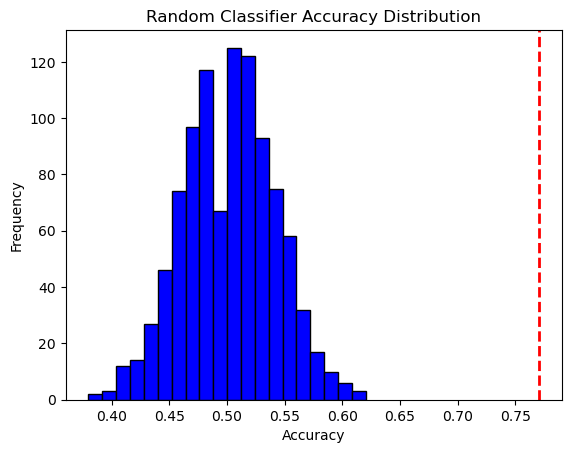

Confusion Matrix:
 [[52 23]
 [15 68]]
Class-specific Accuracy: [0.69333333 0.81927711]
(331, 41, 3)
 Test Accuracy = 85.71%, p-value = 0.0000


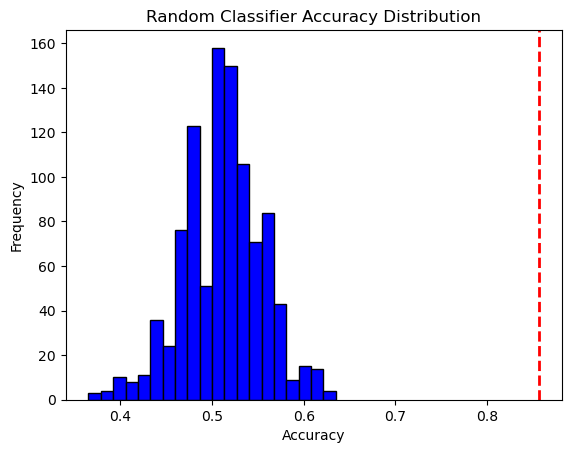

Confusion Matrix:
 [[63  8]
 [13 42]]
Class-specific Accuracy: [0.88732394 0.76363636]
(237, 41, 3)
 Test Accuracy = 91.25%, p-value = 0.0000


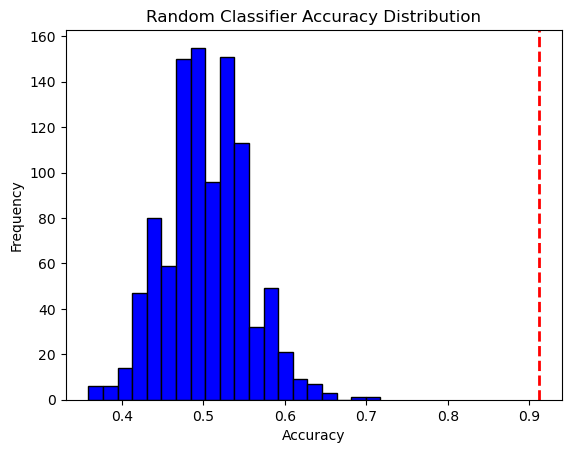

Confusion Matrix:
 [[48  1]
 [ 7 36]]
Class-specific Accuracy: [0.97959184 0.8372093 ]
(506, 41, 3)
 Test Accuracy = 97.40%, p-value = 0.0000


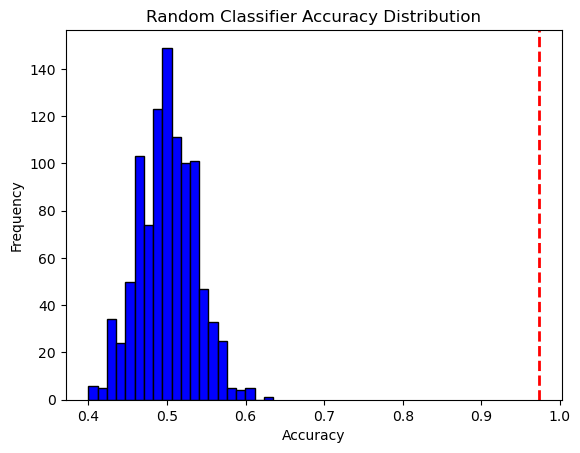

Confusion Matrix:
 [[96  0]
 [ 5 99]]
Class-specific Accuracy: [1.         0.95192308]
(125, 41, 3)
 Test Accuracy = 89.58%, p-value = 0.0000


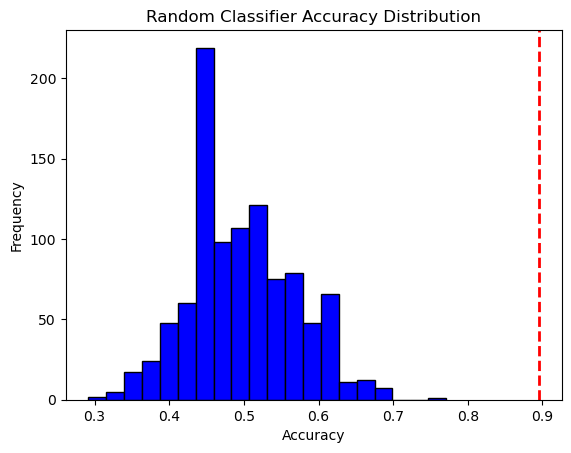

Confusion Matrix:
 [[25  0]
 [ 5 18]]
Class-specific Accuracy: [1.        0.7826087]
(343, 41, 3)
 Test Accuracy = 60.71%, p-value = 0.0120


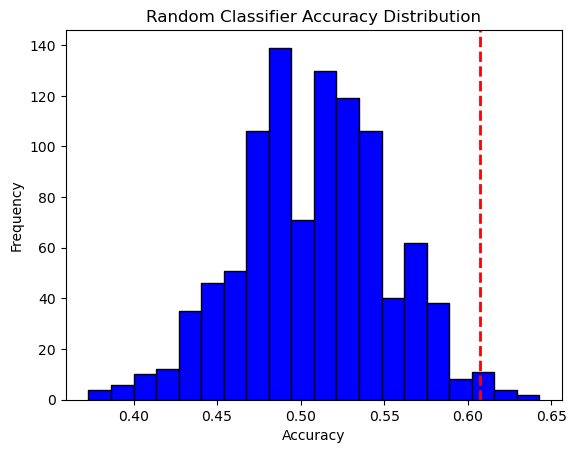

Confusion Matrix:
 [[45 26]
 [22 33]]
Class-specific Accuracy: [0.63380282 0.6       ]
(436, 41, 3)
Skipping session due to imbalance issues: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4
(281, 41, 3)
Skipping session due to imbalance issues: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4


In [91]:
# now applying SMOTE to the population so  we have balanced classes during "LICK" analysis
from imblearn.pipeline import Pipeline
##pop RNN
### gonna use SMOTE and skip sessions with too much of an imbalance 
# Number of random classifiers (null hypothesis testing)


num_permutations = 1000

# Brain areas and analysis types
results_population = []
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["GO", "LICK"]

# Define combinations
combinations = [('S1', 'GO'), ('S1', 'LICK'), ('S1naive', 'GO'), ('S1naive', 'LICK'), ('PPC', 'GO'), ('PPC', 'LICK')]


# Iterate through each combination
for comb in combinations:
    brain_area = comb[0]
    analysis_type = comb[1]
    print(f"Brain Area: {brain_area}, Analysis Type: {analysis_type}")
    # Containers for all data across sessions

    # Load data
    trial_list, trial_dff = get_pop_data_ready(brain_area, analysis_type)

    # Perform PCA
    pca_result_df, session_trial_ids = process_trials_for_pca(trial_list, trial_dff, n_components=3)
    sessions= np.unique(pca_result_df['session'])


    for session in sessions:
        #select the session specific data:
        mask=pca_result_df['session']==session
        all_session_X=pca_result_df[mask]
        all_X=all_session_X['pca_result']#get the PCA result from the session
        new_X=[]
        for trial in all_X:
           new_X.append(np.array(trial))
        new_X=np.array(new_X)
        X=np.transpose(new_X,(0,1,2))
        print(X.shape)
        #now select the session specific y
        indices = pca_result_df.index[pca_result_df['session'] == session].tolist()
        selected_trials = [session_trial_ids[i] for i in indices]
        all_session_y=selected_trials
        all_y=np.array(all_session_y)# Corresponding trial IDs (labels)
        
     
        # Flatten X for SMOTE (2D shape required)
        n_samples, timepoints, features = X.shape
        X_flat = X.reshape(n_samples, -1)  # Shape: (samples, timepoints * features)
    
        # Apply SMOTE and Random Undersampling
        smote = SMOTE(random_state=42)
        undersampler = RandomUnderSampler(random_state=42)
        pipeline = Pipeline([('smote', smote), ('undersample', undersampler)])
        
        try:
            X_balanced, y_balanced = pipeline.fit_resample(X_flat, all_y)
        except ValueError as e:
            print(f"Skipping session due to imbalance issues: {e}")
            continue  # Skip this session if SMOTE fails
    
        # Reshape X_balanced back to 3D for RNN
        X_balanced = X_balanced.reshape(-1, timepoints, features)
    
        # Split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)    
       
         # Convert to PyTorch tensors
        Xtrain = torch.from_numpy(X_train).float()
        ytrain = torch.from_numpy(y_train).long()
        Xtest = torch.from_numpy(X_test).float()
        ytest = torch.from_numpy(y_test).long()
    
            # Prepare DataLoader
        batch_size = 16
        n_iters = 1000
        num_epochs = int(n_iters // (len(X_train) // batch_size))
    
        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
    
            # Create the RNN model
        input_dim = X.shape[-1]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1
    
        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    
            # Loss function and optimizer
        error = nn.BCEWithLogitsLoss()  # No class weights, since oversampling handles imbalance
        learning_rate = 0.01
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
        # Training loop for the original model
        train_accuracy_list = []
        test_accuracy_list = []
        test_loss_list = []
    
        for epoch in range(num_epochs):
            model.train()
            total_train, correct_train = 0, 0
    
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()
                loss = error(outputs, y_batch.float())
                loss.backward()
                optimizer.step()
    
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).long()
                correct_train += (predicted.squeeze() == y_batch).sum().item()
                total_train += y_batch.size(0)
    
            train_accuracy = 100 * correct_train / total_train
            train_accuracy_list.append(train_accuracy)
            scheduler.step()
    
            # Evaluate on test set
            model.eval()
            total_test, correct_test = 0, 0
            with torch.no_grad():
                 for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch).squeeze()
                    probabilities = torch.sigmoid(outputs)
                    predicted = (probabilities > 0.5).long()
                    correct_test += (predicted == y_test_batch).sum().item()
                    total_test += y_test_batch.size(0)
                    loss_test = error(outputs, y_test_batch.float())
                    test_loss_list.append(loss_test)
    
            test_accuracy = 100 * correct_test / float(total_test)
            test_accuracy_list.append(test_accuracy)
    
            # Save the original model's test accuracy
        original_test_accuracy = test_accuracy
    
            # Random classifier: Match class distribution in the test set
        class_distribution = np.mean(y_test)  # proportion of class 1
    
        random_accuracies = []
        for _ in range(num_permutations):
            y_random = np.random.choice([0, 1], size=len(y_test), p=[1 - class_distribution, class_distribution])
            random_accuracy = accuracy_score(y_test, y_random)
            random_accuracies.append(random_accuracy)
    
            # Calculate p-value using a t-test (testing original model vs. random classifiers)
        random_accuracies = np.array(random_accuracies)
        p_value = np.mean(random_accuracies >= original_test_accuracy/100)
    
            # Store results
        results_population.append({
            'Session':session,
            'Brain Area': brain_area,
            'Analysis Type': analysis_type,
            'Train Accuracy': train_accuracy_list,
            'Test Accuracy': original_test_accuracy,
            'p value': p_value
            })
    
        print(f" Test Accuracy = {original_test_accuracy:.2f}%, p-value = {p_value:.4f}")
    
        # Visualize random classifier accuracy distribution
        plt.hist(random_accuracies, bins=20, color='blue', edgecolor='black')
        plt.axvline(original_test_accuracy/100, color='red', linestyle='dashed', linewidth=2)
        plt.title(f'Random Classifier Accuracy Distribution')
        plt.xlabel('Accuracy')
        plt.ylabel('Frequency')
        plt.show()
    
     
      # Check class-specific accuracy on the test set
            
        # Predict on the test set and calculate confusion matrix
        model.eval()
        with torch.no_grad():
            outputs = model(Xtest).squeeze()
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).long()
                
        conf_matrix = confusion_matrix(ytest, predictions)
        print("Confusion Matrix:\n", conf_matrix)
            
            # Calculate class-specific accuracy
        class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        print("Class-specific Accuracy:", class_accuracy)


/tmp/ipykernel_826/1608693703.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_brain_areas))  # Use tab10 colormap for up to 10 areas


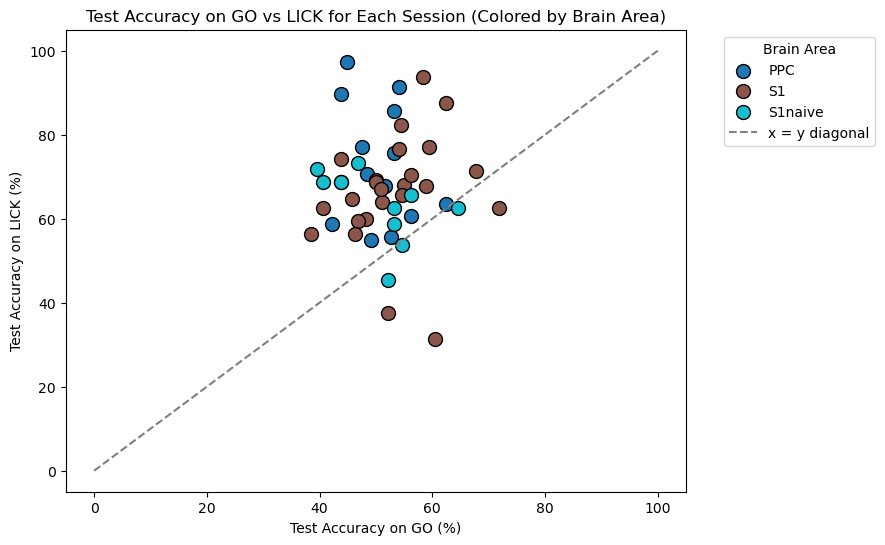

In [92]:
#lets plot what we have after sampling 
# Dictionaries to store test accuracies, brain areas, and p-values by neuron
go_accuracies = {}
lick_accuracies = {}
brain_areas = {}

# Populate dictionaries with test accuracies and brain area
for result in results_population:
    session = result['Session']
    if isinstance(session, np.ndarray):  # If neuron is a NumPy array, convert to a scalar value
        session = session.item()  # Extract the value from the NumPy array
    
    # Store test accuracy for "GO" and "LICK"
    if result['Analysis Type'] == 'GO':
        go_accuracies[session] = result['Test Accuracy']
    elif result['Analysis Type'] == 'LICK':
        lick_accuracies[session] = result['Test Accuracy']
    
    # Store brain area information
    if session not in brain_areas:
        brain_areas[session] = result['Brain Area']

# Now only include neurons that have both "GO" and "LICK" test accuracies
go_test_accuracies = []
lick_test_accuracies = []
neuron_brain_areas = []

for session in go_accuracies:
    if session in lick_accuracies:  # Only include neurons with both GO and LICK data
        go_test_accuracies.append(go_accuracies[session])
        lick_test_accuracies.append(lick_accuracies[session])
        neuron_brain_areas.append(brain_areas[session])  # Track brain area for each neuron

# Convert lists to numpy arrays for compatibility with plotting
go_test_accuracies = np.array(go_test_accuracies)
lick_test_accuracies = np.array(lick_test_accuracies)
neuron_brain_areas = np.array(neuron_brain_areas)

# Define unique brain areas for color coding
unique_brain_areas = np.unique(neuron_brain_areas)
colors = plt.cm.get_cmap('tab10', len(unique_brain_areas))  # Use tab10 colormap for up to 10 areas

# Plotting the scatter plot with color coding by brain area
plt.figure(figsize=(8, 6))
for i, brain_area in enumerate(unique_brain_areas):
    mask = neuron_brain_areas == brain_area
    plt.scatter(go_test_accuracies[mask], lick_test_accuracies[mask], label=brain_area,
                color=colors(i), s=100, edgecolor='k')

# Adding x=y diagonal line
plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='x = y diagonal')

# Adding labels and title
plt.xlabel('Test Accuracy on GO (%)')
plt.ylabel('Test Accuracy on LICK (%)')
plt.title('Test Accuracy on GO vs LICK for Each Session (Colored by Brain Area)')

# Adding legend for brain areas
plt.legend(title="Brain Area", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


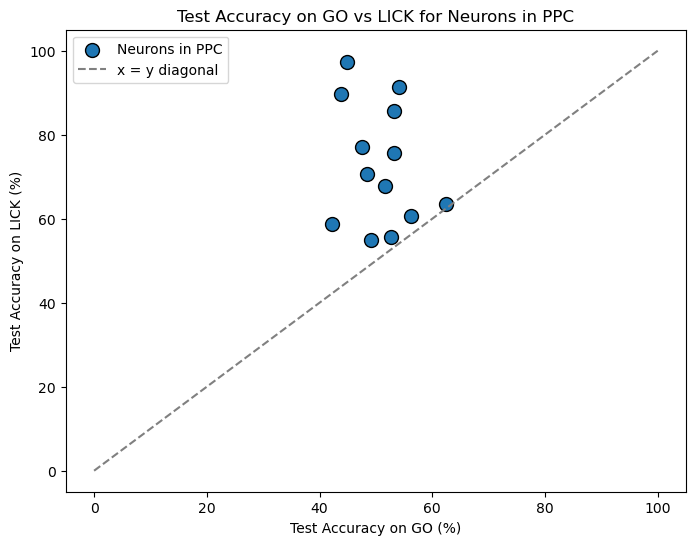

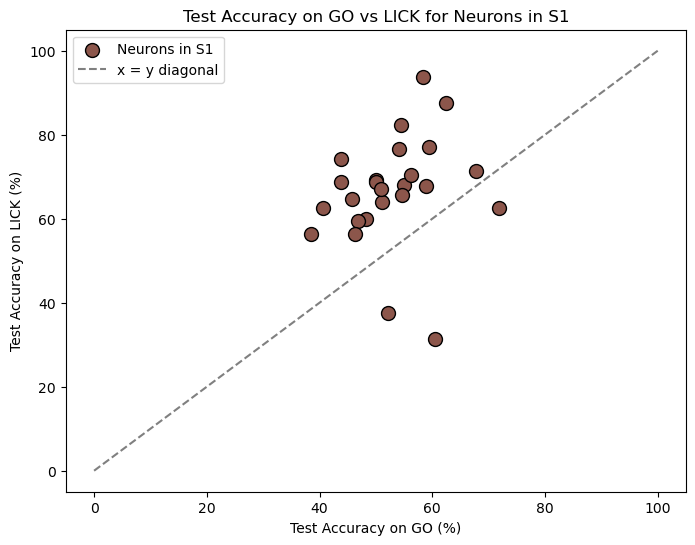

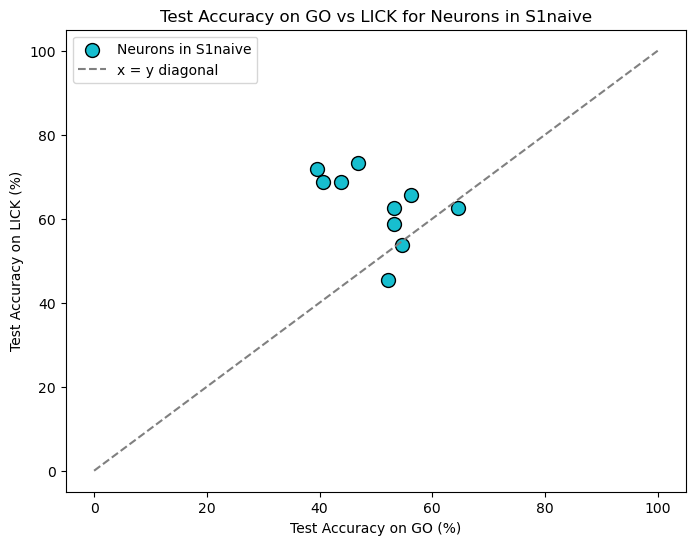

In [93]:
# Iterate over each unique brain area to create individual plots
for brain_area in unique_brain_areas:
    # Create a mask for the current brain area
    mask = neuron_brain_areas == brain_area
    
    # Create a new figure for each brain area
    plt.figure(figsize=(8, 6))
    
    # Plot GO vs. LICK test accuracies for the current brain area
    plt.scatter(go_test_accuracies[mask], lick_test_accuracies[mask], 
                color=colors(unique_brain_areas.tolist().index(brain_area)), s=100, edgecolor='k')
    
    # Adding x=y diagonal line
    plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='x = y diagonal')
    
    # Adding labels and title specific to each brain area
    plt.xlabel('Test Accuracy on GO (%)')
    plt.ylabel('Test Accuracy on LICK (%)')
    plt.title(f'Test Accuracy on GO vs LICK for Neurons in {brain_area}')
    
    # Adding legend for clarity
    plt.legend([f'Neurons in {brain_area}', 'x = y diagonal'])
    
    # Show the plot for the current brain area
    plt.show()
